# APPLICATIONS OF MACHINE LEARNING TO THE STUDY OF BRAIN METASTASES
THIS PROJECT HAS BEEN DEVELOPED INSIDE THE CONTEXT OF [SATURDAYS AI ASTURIAS](https://cursos.saturdays.ai/courses/aisatudays-asturias-ml), WE ARE:
* [Adrián Aguado](https://www.linkedin.com/in/adrianaguado/)
* [Raquel Martínez](https://www.linkedin.com/in/rakelmarmar/)
* [Arturo Linares](https://github.com/afouteza)
* [Olumayowa Onabanjo](https://www.linkedin.com/in/olumayowa-onabanjo-452b8143)
* [Mateo Rodríguez](http://www.linkedin.com/in/mateo-r-6az)

FOR ENQUIRIES ABOUT THE CODE: mateorsuarez@gmail.com

WE MUST THANK EVERY PERSON THAT HAS MADE THIS PROJECT POSSIBLE: [Sofía González](https://www.linkedin.com/in/sof%C3%ADa-gonz%C3%A1lez-arias/), every mentor we've had troughout the sesions, and finally Juan Belmonte and Beatriz Ocaña, from MOLAB.

UNFORTUNATELY, WE HAVE NOT BEEN ABLE TO ACHIEVE GREAT PREDICTION RESULTS, EVEN THOUGH SOME OF THEM ARE QUITE PROMISING. HOWEVER, THIS PROJECT IS, WITHOUT A SHADOW OF DOUBT, INCOMPLETE. AS TIME IS NOT UNLIMITED, WE LEAVE IT HERE FOR NOW. MUCH MORE CAN BE DONE FOLLOWING OUR STEPS, AS THIS IS JUST AN INTRODUCTION.

AN ULTIMATE REMARK HAS TO BE MADE. THE MOST IMPORTANT (AND TIME-CONSUMING) TASK HAS BEEN STUDYING THE DATA AND UNDERSTANDING WHAT CAN BE EXPECTED TO ACHIEVE FROM IT. THERE ARE TWO EXCELS WITH DIFFERENT FORMATS, AND BEFORE ANY MACHINE LEARNING MODEL COULD BE APPLIED IT WAS NECESSARY TO DO AN EXHAUSTIVE MANIPULATION IN ORDER TO OBTAIN A CLEAN DATAFRAME.

PD: BE CAREFUL WHEN RUNNING THE WHOLE CODE, AS IT TAKES A GREAT AMOUNT OF RAM MEMORY (AROUND 45-50 GB).

# INFORMATION ABOUT THE DATA

+ DATA FROM MOLAB: https://molab.es/datasets-brain-metastasis-1/?type=metasrd

**MORPHOLOGICAL MEASURES**

IMAGE PARAMETERS:
*   SBS = SPACE BETWEEN SLICES (mm)
*   SCS = SLICE THICKNESS (mm)
*   REPTIME = REPETITION TIME (msec)
* CEVOLUME = CONTRAST-ENHANCING VOLUME $V_{CE}$
* NECVOLUME = NECROTIC (NON-ENHANCING) VOLUME $V_{N}$
* TOTALVOLUME $V = V_{CE}+V_{N}$
*CERIMWIDTH = CONTRAST-ENHANCING (CE) SPHERICAL RIM WIDTH, function of volume
* SURFACEREGULARITY = the tumor's shape is more espherical as this parameter approaches 1.
*MAXDIAMETER3D = Max. longitudinal length
---
CLINICAL DATA

* PRIMARY TUMOR (naranja):
    * EGFR,ALK... molecular markers
    * TNM: tumor classification.
        * T: size.
        * N: expansion to the lymph glands.
        * M : metastasis to distant organs.

* GPA (yellow): GPA index, survival estimator for patients with brain metastasis.

# 0. IMPORTS

In [ ]:
pip install shap

In [ ]:
##################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.stats import linregress

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.model_selection import train_test_split
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


import xgboost as xgb
from xgboost import DMatrix

import shap

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Activation

from keras.callbacks import EarlyStopping
# Some data preprocessing:
from sklearn.preprocessing import MinMaxScaler # Values between 0 and 1
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Reduction of dimensionality

import joblib


# Save models
import pickle


import nibabel as nib
##################################################
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# 1. FUNCTIONS

In [ ]:
##################################################
# NANS
def columnas_nulas(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores faltantes', 1 : '% del Total de Valores'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% del Total de Valores', ascending=False).round(1)
        print ("El dataframe seleccionado tiene " + str(df.shape[1]) + " columnas.\n"
            "Hay " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas que tienen Valores nulos.")
        return mis_val_table_ren_columns



###############################################
# FUNCTION THAT PLOTS AN MRI IMAGE
def plot_mri_image(nii_file):
    # Cargar la imagen .nii
    nii_img = nib.load(nii_file)
    # Obtener los datos de la imagen
    nii_data = nii_img.get_fdata()

    # Calcular el punto medio del cerebro para cortes axiales
    mid_slice = nii_data.shape[2] // 2

    # Plotear las imágenes
    fig, axes = plt.subplots(1, 3, figsize=(15, 15))

    # Cortes Axiales
    axes[0].imshow(nii_data[:, :, mid_slice], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("Axial")

    # Cortes Sagitales
    sagittal_slice = nii_data.shape[0] // 2
    axes[1].imshow(nii_data[sagittal_slice, :, :].T, cmap='gray', origin='lower')
    axes[1].axis('off')
    axes[1].set_title("Sagittal")

    # Cortes Coronal
    coronal_slice = nii_data.shape[1] // 2
    axes[2].imshow(nii_data[:, coronal_slice, :].T, cmap='gray', origin='lower')
    axes[2].axis('off')
    axes[2].set_title("Coronal")

    plt.show()

####################################################
#DATE DIFFERENCE IN DAYS
def datesdiff(dfa,dfb):
  'FUNCIÓN QUE CALCULA LA DIFERENCIA DE FECHAS (EN DÍAS) ENTRE DOS ELEMENTOS DE UN DATAFRAME b-a'
  a = pd.to_datetime(dfa,format = "%Y%m%d") # Fecha 1
  b = pd.to_datetime(dfb,format = "%Y%m%d") # Fecha 2
  dif = (b-a).days
  return dif

# EXAMPLE OF USE: datesdiff(df['TIME POINT'][0],df['TIME POINT'][1])












# 2. OBTAIN THE DATASETS

##MORPHOLOGICAL MEASURES

In [ ]:
#DATAFRAME CONTAINING MORPHOLOGICAL MEASURES
df_MM = pd.read_excel(r'/content/OpenBTAI_MORPHOLOGICAL_MEASUREMENTS.xlsx')
df_MM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PATIENT            499 non-null    int64  
 1   TIME POINT         499 non-null    int64  
 2   PIXELSPACING       499 non-null    float64
 3   SBS                499 non-null    float64
 4   STH                499 non-null    float64
 5   STATION NAME       499 non-null    object 
 6   REPTIME            499 non-null    float64
 7   ECHOTIME           499 non-null    float64
 8   MAGNETIC FIELD     499 non-null    float64
 9   LESION             499 non-null    int64  
 10  TOTALVOLUME        499 non-null    float64
 11  CEVOLUME           499 non-null    float64
 12  NECVOLUME          499 non-null    float64
 13  CERIMWIDTH         499 non-null    float64
 14  MAXDIAMETER3D      499 non-null    float64
 15  TOTALSURFACE       499 non-null    float64
 16  RENDVOLUME         499 non

In [ ]:
df_MM.head(1)

PATIENT  TIME POINT  PIXELSPACING  SBS  STH             STATION NAME  \
0    10005    19010618      0.976562  1.0  2.0  Philips Medical Systems   

   REPTIME  ECHOTIME  MAGNETIC FIELD  LESION  TOTALVOLUME  CEVOLUME  \
0     25.0     5.139             1.5       1     0.162125  0.162125   

   NECVOLUME  CERIMWIDTH  MAXDIAMETER3D  TOTALSURFACE  RENDVOLUME  \
0        0.0    0.338262       0.783567      1.665688    0.154416   

   SURFACEREGULARITY  
0           0.763884

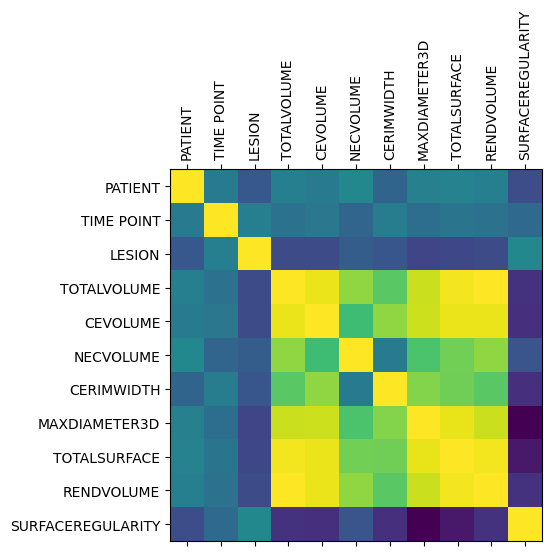

In [ ]:
#CORRELATION MATRIX
df_MM = df_MM.drop('STATION NAME',axis=1) # TIRAMOS DATOS IRRELEVANTES
df_MM = df_MM.drop(columns=['PIXELSPACING','SBS','STH','REPTIME','ECHOTIME','MAGNETIC FIELD'])
mat_MM = np.matrix(df_MM)
plt.matshow(df_MM.corr())
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],['PATIENT',	'TIME POINT',	'LESION',	'TOTALVOLUME',	'CEVOLUME',	'NECVOLUME',	'CERIMWIDTH',	'MAXDIAMETER3D',	'TOTALSURFACE',	'RENDVOLUME',	'SURFACEREGULARITY'],rotation = 90)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['PATIENT',	'TIME POINT',	'LESION',	'TOTALVOLUME',	'CEVOLUME',	'NECVOLUME',	'CERIMWIDTH',	'MAXDIAMETER3D',	'TOTALSURFACE',	'RENDVOLUME',	'SURFACEREGULARITY'],rotation = 0)
plt.show()

In [ ]:
df_MM.head(1)

PATIENT  TIME POINT  LESION  TOTALVOLUME  CEVOLUME  NECVOLUME  CERIMWIDTH  \
0    10005    19010618       1     0.162125  0.162125        0.0    0.338262   

   MAXDIAMETER3D  TOTALSURFACE  RENDVOLUME  SURFACEREGULARITY  
0       0.783567      1.665688    0.154416           0.763884

NEW CORRELATION MATRIX

In [ ]:
corr = df_MM.corr()
corr.style.background_gradient(cmap='coolwarm')

If we look at the TOTALVOLUME column, we can see there is important correlation for almost every other variable. CERIMWIDTH and SURFACEREGULARITY are the only variables that have an R low enough.

####TOTAL VALUES OF MORPHOLOGICAL MEASURES (COMMENTED BECAUSE IT'S PROBABLY USELESS)
AT FIRST, WE WANTED TO CONSIDER THE PATIENT AS A WHOLE, BUT WE WILL SEE THAT IT IS NOT POSSIBLE AS THE DIFFERENT LESIONS OF EACH PATIENT DON'T OCCUR AT THE SAME TIMES

In [ ]:
'''
d2 = pd.DataFrame() # Creamos un DataFrame vacío

# d.count nos da el número de elementos, y d.mean la media de esos elementos. Ergo, count*mean da la suma de todos los elementos.

# Hacemos la suma para cada columna.
d = df.groupby(['PATIENT','TIME POINT'])['TOTALVOLUME'].describe()
totvol = d['count']*d['mean']
d2['totvol'] = totvol

d = df.groupby(['PATIENT','TIME POINT'])['CEVOLUME'].describe()
totcevol = d['count']*d['mean']
d2['totcevol'] = totcevol

d = df.groupby(['PATIENT','TIME POINT'])['NECVOLUME'].describe()
totnecvol = d['count']*d['mean']
d2['totnecvol'] = totnecvol

d = df.groupby(['PATIENT','TIME POINT'])['CERIMWIDTH'].describe()
totwidth = d['count']*d['mean']
d2['totcerimwidth'] = totwidth

d = df.groupby(['PATIENT','TIME POINT'])['MAXDIAMETER3D'].describe()
totdiam = d['count']*d['mean']
d2['totmaxdiam'] = totdiam

d = df.groupby(['PATIENT','TIME POINT'])['TOTALSURFACE'].describe()
totsurf = d['count']*d['mean']
d2['totsurf'] = totsurf

d = df.groupby(['PATIENT','TIME POINT'])['RENDVOLUME'].describe()
totrend = d['count']*d['mean']
d2['totrendvol'] = totrend

#SURFACEREGULARITY NO ES SUSCEPTIBLE DE ESTE MODELO, SE PUEDE HACER LA MEDIA

d = df.groupby(['PATIENT','TIME POINT'])['SURFACEREGULARITY'].describe()
totreg = d['mean']
d2['surfacereg'] = totreg

#d2 tiene los valores totales
#d tiene las estadísticas

d2.head()
'''

"\nd2 = pd.DataFrame() # Creamos un DataFrame vacío\n\n# d.count nos da el número de elementos, y d.mean la media de esos elementos. Ergo, count*mean da la suma de todos los elementos.\n\n# Hacemos la suma para cada columna.\nd = df.groupby(['PATIENT','TIME POINT'])['TOTALVOLUME'].describe()\ntotvol = d['count']*d['mean']\nd2['totvol'] = totvol\n\nd = df.groupby(['PATIENT','TIME POINT'])['CEVOLUME'].describe()\ntotcevol = d['count']*d['mean']\nd2['totcevol'] = totcevol\n\nd = df.groupby(['PATIENT','TIME POINT'])['NECVOLUME'].describe()\ntotnecvol = d['count']*d['mean']\nd2['totnecvol'] = totnecvol\n\nd = df.groupby(['PATIENT','TIME POINT'])['CERIMWIDTH'].describe()\ntotwidth = d['count']*d['mean']\nd2['totcerimwidth'] = totwidth\n\nd = df.groupby(['PATIENT','TIME POINT'])['MAXDIAMETER3D'].describe()\ntotdiam = d['count']*d['mean']\nd2['totmaxdiam'] = totdiam\n\nd = df.groupby(['PATIENT','TIME POINT'])['TOTALSURFACE'].describe()\ntotsurf = d['count']*d['mean']\nd2['totsurf'] = totsurf\n

##CLINICAL DATA



In [ ]:
#DATAFRAME CONTAINING CLINICAL DATA

df_CD = pd.read_excel(r'/content/OpenBTAI_METS_ClinicalData_Nov2023.xlsx',header=14)
df_CD = df_CD.drop(index=[160,161,162,163])
df_CD.head(1)

Unnamed: 0  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0     010005        40.0         1.0         1.0         1.0         1.0   

   Unnamed: 6  EGFR  ALK  ROS1  KRAS  TTF1  Sinaptofisina  PDL1  BRCA1  RE  \
0         1.0   NaN  NaN   NaN   NaN   NaN            NaN   NaN    NaN NaN   

   RP  HER2  BRAF  NRAS  CKIT  TNM Stage  Dose/Frac  Nfrac Begin End  \
0 NaN   NaN   NaN   NaN   NaN  NaN   NaN        3.0   10.0     0  13   

   Dose/Frac.1  Nfrac.1 Begin.1 End.1  Dosis/Frac  Nfrac.2 Begin.2 End.2  \
0          NaN      NaN                       5.5      3.0     781   785   

   Dosis/Frac.1  Nfrac.3 Begin.3 End.3  Dosis/Frac.2  Nfrac.4 Begin.4 End.4  \
0           NaN      NaN                         NaN      NaN                 

  Time  Unnamed: 44 Unnamed: 45          Drug Begin.5 End.5  \
0               NaN              Capecitabine     -19   104   

                                  Drug.1 Begin.6 End.6  \
0  Cisplatin + Gemcitabine + bevacizumab     104   407   

                   Drug.2 Begin.7 End.7       Drug.3 Begin.8 End.8  \
0  bevacizumab + letrozol     424   531  Vinorelbine     538   658   

        Drug.4 Begin.9 End.9 Drug.5  Begin.10  End.10 Drug.6  Begin.11  \
0  Doxorubicin     676   732    NaN       NaN     NaN    NaN       NaN   

   End.11 Drug.7  Begin.12  End.12 Unnamed: 70  Unnamed: 71  Unnamed: 72  \
0     NaN    NaN       NaN     NaN         NaN          1.0       1084.0   

  Unnamed: 73        MR1        MR2        MR3        MR4  \
0           1 1900-01-01 1900-03-04 1900-03-11 1901-06-18   

                   MR5                  MR6                  MR7 MR8 MR9 MR10  \
0  1901-10-11 00:00:00  1902-01-28 00:00:00  1902-04-13 00:00:00                

  MR11 MR12 MR13 MR14 MR15 MR16 MR17 MR18 MR19  
0                           NaN  NaN

NOW WE RENAME UNNAMED COLUMNS

UNNAMEDS:
* 0 = ID
* 1 = AGE AT MR1
* 2 = SEX, 1= FEMALE,2 = MALE
* 3 = GPA
* 4 = LESION
* 5 = TYPE
* 6 = SUBTYPE
* 44 = SURGERY TYPE
* 45 = SURGERY TIME
* 70 = COMMENTS
* 71 = DEATH OCURRENCE (1 = YES,0=NO)
* 72 = DEATH TIME
* 73 = DEATH CAUSE (1 BRAIN PROGRESSION, 2 SYSTEMIC ILLNESS, 3 = 1+2, 4 OTHER)



In [ ]:
df_CD = df_CD.rename(columns={'Unnamed: 0':'ID','Unnamed: 1':'AGE','Unnamed: 2':'SEX','Unnamed: 3':'GPA','Unnamed: 4':'LESION','Unnamed: 5':'TYPE','Unnamed: 6':'SUBTYPE','Unnamed: 44':'SURGERY TYPE','Unnamed: 45':'SURGERY TIME','Unnamed: 70':'COMMENTS','Unnamed: 71':'DEATH','Unnamed: 72':'DEATH TIME','Unnamed: 73':'DEATH CAUSE'})
df_CD.head(1)

ID   AGE  SEX  GPA  LESION  TYPE  SUBTYPE  EGFR  ALK  ROS1  KRAS  TTF1  \
0  010005  40.0  1.0  1.0     1.0   1.0      1.0   NaN  NaN   NaN   NaN   NaN   

   Sinaptofisina  PDL1  BRCA1  RE  RP  HER2  BRAF  NRAS  CKIT  TNM Stage  \
0            NaN   NaN    NaN NaN NaN   NaN   NaN   NaN   NaN  NaN   NaN   

   Dose/Frac  Nfrac Begin End  Dose/Frac.1  Nfrac.1 Begin.1 End.1  Dosis/Frac  \
0        3.0   10.0     0  13          NaN      NaN                       5.5   

   Nfrac.2 Begin.2 End.2  Dosis/Frac.1  Nfrac.3 Begin.3 End.3  Dosis/Frac.2  \
0      3.0     781   785           NaN      NaN                         NaN   

   Nfrac.4 Begin.4 End.4 Time  SURGERY TYPE SURGERY TIME          Drug  \
0      NaN                              NaN               Capecitabine   

  Begin.5 End.5                                 Drug.1 Begin.6 End.6  \
0     -19   104  Cisplatin + Gemcitabine + bevacizumab     104   407   

                   Drug.2 Begin.7 End.7       Drug.3 Begin.8 End.8  \
0  bevacizumab + letrozol     424   531  Vinorelbine     538   658   

        Drug.4 Begin.9 End.9 Drug.5  Begin.10  End.10 Drug.6  Begin.11  \
0  Doxorubicin     676   732    NaN       NaN     NaN    NaN       NaN   

   End.11 Drug.7  Begin.12  End.12 COMMENTS  DEATH  DEATH TIME DEATH CAUSE  \
0     NaN    NaN       NaN     NaN      NaN    1.0      1084.0           1   

         MR1        MR2        MR3        MR4                  MR5  \
0 1900-01-01 1900-03-04 1900-03-11 1901-06-18  1901-10-11 00:00:00   

                   MR6                  MR7 MR8 MR9 MR10 MR11 MR12 MR13 MR14  \
0  1902-01-28 00:00:00  1902-04-13 00:00:00                                    

  MR15 MR16 MR17 MR18 MR19  
0       NaN  NaN

In [ ]:
columnas_nulas(df_CD)

El dataframe seleccionado tiene 93 columnas.
Hay 71 columnas que tienen Valores nulos.


Valores faltantes  % del Total de Valores
TTF1                         160                   100.0
HER2                         160                   100.0
Sinaptofisina                160                   100.0
Nfrac.4                      159                    99.4
PDL1                         159                    99.4
Dosis/Frac.2                 159                    99.4
RP                           158                    98.8
KRAS                         158                    98.8
COMMENTS                     158                    98.8
RE                           158                    98.8
CKIT                         157                    98.1
End.11                       156                    97.5
Begin.12                     156                    97.5
BRCA1                        156                    97.5
Drug.7                       156                    97.5
End.12                       156                    97.5
BRAF                         155                    96.9
ROS1                         155                    96.9
NRAS                         155                    96.9
Stage                        154                    96.2
Drug.6                       153                    95.6
Begin.11                     153                    95.6
End.10                       151                    94.4
SURGERY TYPE                 150                    93.8
Nfrac.3                      145                    90.6
Dosis/Frac.1                 145                    90.6
Nfrac.1                      144                    90.0
Dose/Frac.1                  144                    90.0
Begin.10                     143                    89.4
Drug.5                       143                    89.4
Drug.4                       131                    81.9
ALK                          123                    76.9
EGFR                         115                    71.9
Drug.3                       115                    71.9
Drug.2                        87                    54.4
TNM                           64                    40.0
Nfrac                         47                    29.4
Dose/Frac                     47                    29.4
Dosis/Frac                    43                    26.9
Nfrac.2                       42                    26.2
Drug.1                        37                    23.1
SUBTYPE                       31                    19.4
MR16                          22                    13.8
MR17                          21                    13.1
GPA                           20                    12.5
DEATH CAUSE                   20                    12.5
Drug                          18                    11.2
Time                          13                     8.1
End.2                         10                     6.2
MR7                           10                     6.2
MR15                          10                     6.2
MR10                           9                     5.6
MR8                            7                     4.4
MR12                           7                     4.4
MR5                            6                     3.8
MR9                            5                     3.1
MR13                           5                     3.1
Begin.2                        4                     2.5
MR6                            4                     2.5
Begin.6                        3                     1.9
End.6                          3                     1.9
Begin.3                        3                     1.9
Begin                          2                     1.2
MR14                           2                     1.2
End                            2                     1.2
Begin.5                        2                     1.2
Begin.1                        1                     0.6
End.7                          1                     0.6
SURGERY TIME                   1                     0.6
End.3                    

WE ASIGN A NUMERICAL VALUE TO EACH DRUG

In [ ]:
#PROBABLY EASIER TO USE LABELENCODER: from sklearn.preprocessing import LabelEncoder: ENCODING CATEGORIAL DATA AS A DUMMY VARIABLE

drugs = pd.unique(df_CD['Drug']) # With unique we eliminate the ones that are repeated
drugs1 = pd.unique(df_CD['Drug.1'])
drugs2 = pd.unique(df_CD['Drug.2'])
drugs3 = pd.unique(df_CD['Drug.3'])
drugs4 = pd.unique(df_CD['Drug.4'])
drugs5 = pd.unique(df_CD['Drug.5'])
drugs6 = pd.unique(df_CD['Drug.6'])
drugs7 = pd.unique(df_CD['Drug.7'])

dd = np.concatenate((drugs,drugs1,drugs2,drugs3,drugs4,drugs5,drugs6,drugs7)) # We concatenate the different drugs
dd = pd.unique(dd) # We eliminate again the repeated
dd = np.delete(dd,8) # We eliminate nan


df_CD = df_CD.replace(dd,np.arange(1,len(dd)+1)) # We replace in the original DataFrame

# We drop useless columns
df_CD= df_CD.drop(columns=['MR1','MR2','MR3','MR4','MR5','MR6','MR7','MR8','MR9','MR10','MR11','MR12','MR13','MR14','MR15','MR16','MR17','MR18','MR19']) # Tiramos las últimas columnas que contienen las fechas de los MRIs
df_CD = df_CD.drop(columns=['COMMENTS','EGFR',	'ALK',	'ROS1',	'KRAS',	'TTF1',	'Sinaptofisina',	'PDL1',	'BRCA1',	'RE',	'RP',	'HER2',	'BRAF',	'NRAS',	'CKIT','Stage']) # Tiramos columnas con muchos valores nulos (e.g. marcadores moleculares)


df_CD.head()

ID   AGE  SEX  GPA  LESION  TYPE  SUBTYPE  TNM  Dose/Frac  Nfrac Begin  \
0  010005  40.0  1.0  1.0     1.0   1.0      1.0  NaN        3.0   10.0     0   
1  010005  40.0  1.0  1.0     3.0   1.0      1.0  NaN        3.0   10.0     0   
2  010020  44.0  1.0  NaN     1.0   1.0      4.0  NaN        3.0   10.0     3   
3  010020  44.0  1.0  NaN     2.0   1.0      4.0  NaN        3.0   10.0     3   
4  010020  44.0  1.0  NaN     3.0   1.0      4.0  NaN        3.0   10.0     3   

  End  Dose/Frac.1  Nfrac.1 Begin.1 End.1  Dosis/Frac  Nfrac.2 Begin.2 End.2  \
0  13          NaN      NaN                       5.5      3.0     781   785   
1  13          NaN      NaN                       NaN      NaN                 
2  16          NaN      NaN                       NaN      NaN                 
3  16          NaN      NaN                       NaN      NaN                 
4  16          NaN      NaN                       NaN      NaN                 

   Dosis/Frac.1  Nfrac.3 Begin.3 End.3  Dosis/Frac.2  Nfrac.4 Begin.4 End.4  \
0           NaN      NaN                         NaN      NaN                 
1           NaN      NaN                         NaN      NaN                 
2           NaN      NaN                         NaN      NaN                 
3           NaN      NaN                         NaN      NaN                 
4           NaN      NaN                         NaN      NaN                 

  Time  SURGERY TYPE SURGERY TIME  Drug Begin.5 End.5  Drug.1 Begin.6 End.6  \
0                NaN                1.0     -19   104    63.0     104   407   
1                NaN                1.0     -19   104    63.0     104   407   
2                NaN                2.0      23   129     4.0     150   591   
3                NaN                2.0      23   129     4.0     150   591   
4                NaN                2.0      23   129     4.0     150   591   

   Drug.2 Begin.7 End.7  Drug.3 Begin.8 End.8  Drug.4 Begin.9 End.9  Drug.5  \
0    99.0     424   531    66.0     538   658   125.0     676   732     NaN   
1    99.0     424   531    66.0     538   658   125.0     676   732     NaN   
2   100.0     612   696   123.0     725  1062     NaN                   NaN   
3   100.0     612   696   123.0     725  1062     NaN                   NaN   
4   100.0     612   696   123.0     725  1062     NaN                   NaN   

   Begin.10  End.10  Drug.6  Begin.11  End.11  Drug.7  Begin.12  End.12  \
0       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   
1       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   
2       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   
3       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   
4       NaN     NaN     NaN       NaN     NaN     NaN       NaN     NaN   

   DEATH  DEATH TIME DEATH CAUSE  
0    1.0      1084.0           1  
1    1.0      1084.0           1  
2    1.0      1625.0         NaN  
3    1.0      1625.0         NaN  
4    1.0      1625.0         NaN

THERE ARE SOME LESIONS OF WHICH WE DON'T HAVE MORPHOLOGICAL INFORMATION, BUT APPEAR IN THE CLINICAL DATA EXCEL

In [ ]:
# PATIENT 40156 1
# PATIENT 40109 2
# PATIENT 40084 2
# PATIENT 40058 2
# PATIENT 40011 1
# PATIENT 40001 2

# THEREFORE, WE ACTUALLY HAVE 160 - 6 = 154 LESIONS(TUMORS)

df_CD = df_CD.drop([65,73,90,105,115,145])

mat_CD = np.matrix(df_CD)

In [ ]:
#WE'LL USE THIS FOR OBJECTIVE 2
df_CD2 = df_CD[['ID','LESION','GPA','SEX','AGE']]
df_CD2['ID'] = df_CD2['ID'].astype(int)

## -RADIOMIC DATA

PROBABLY WE CAN'T DO ANYTHING WITH IT, JUST TRYING WITH PCA (THERE ARE MORE THAN 1000 COLUMNS)

In [ ]:
# df_R = pd.read_excel(r'/content/OpenBTAI_RADIOMICS.xlsx')
# df_R = df_R[df_R['Segment']=='Total']
# df_R.head()

# 3. FIRST APPROACH TO THE DATA

## PATIENT DATA

###NOT REALLY IMPORTANT INFO

DAYS BETWEEN FIRST AND LAST MRI

In [ ]:
a = np.array(df_MM['TIME POINT']) # DATES ARRAY
b = np.array(df_MM['PATIENT'])    # PATIENTS ARRAY

c = np.column_stack((a,b))

days_MRI0 = np.zeros_like(b) # DAYS BETWEEN CONSECUTIVE MRIS

days_MRI = np.zeros(75) # DAYS BETWEEN FIRST AND LAST MRI
j = 0
k = 0
for i in range(1,len(c)):
  if c[i][1] == c[i-1][1]:
    days_MRI[j] +=  datesdiff(c[i-1][0],c[i][0])
    days_MRI0[k] = datesdiff(c[i-1][0],c[i][0])
  elif c[i][1] != c[i-1][1]:
    j += 1
  k += 1


Mean = 281.4533333333333
Desviation = 225.01106896229695


Text(0, 0.5, '# of patients')

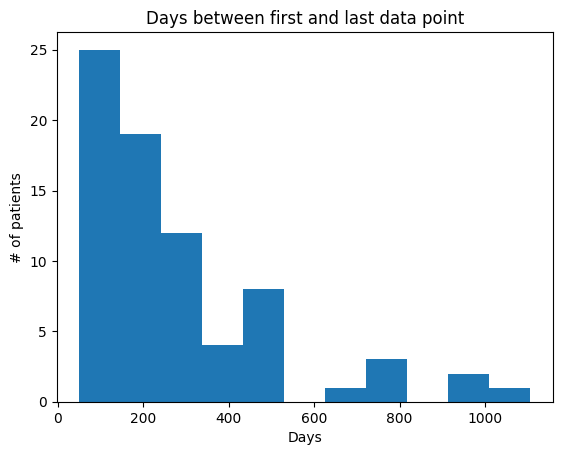

In [ ]:
plt.hist(days_MRI,bins='auto')

print('Mean = ' + str(np.mean(days_MRI)))
print('Desviation = ' + str(np.sqrt(np.var(days_MRI))))
plt.title('Days between first and last data point')
plt.xlabel('Days')
plt.ylabel('# of patients')

Text(0, 0.5, '#')

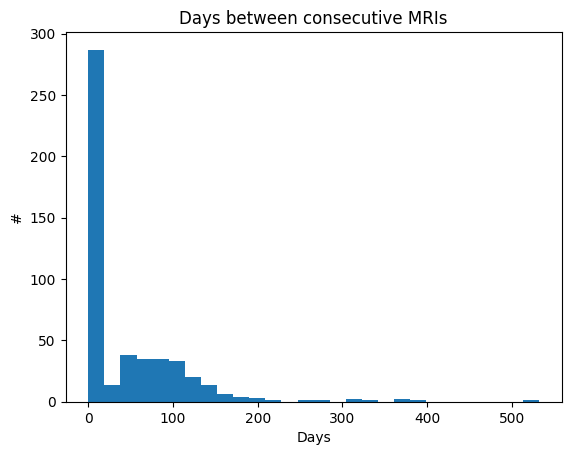

In [ ]:
plt.hist(days_MRI0,bins='auto')
plt.title('Days between consecutive MRIs')
plt.xlabel('Days')
plt.ylabel('#')

### MORE INTERESTING INFO

DAYS UNTIL DEATH

Text(0.5, 1.0, 'SURVIVAL DISTRIBUTION')

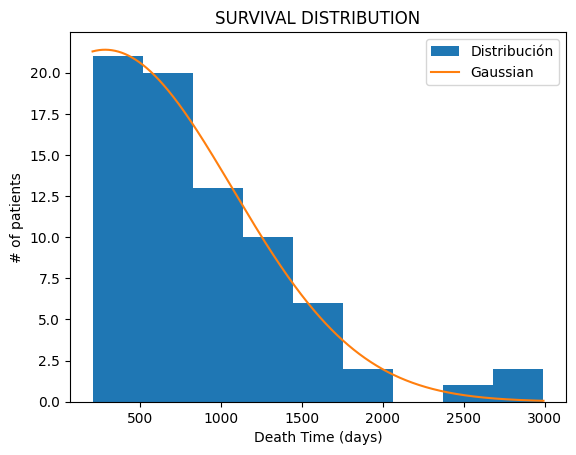

In [ ]:
# Array with survival days, but repeated for every tumor of the different patients:
deaths = np.array(df_CD['DEATH TIME'])
patients = np.array(df_CD['ID'])

death_matrix = np.column_stack((deaths,patients))

death_array = np.zeros(75)

j = 0

for i in range(1,len(death_matrix)):
  if death_matrix[i][1] != death_matrix[i-1][1]:
    death_array[j] = death_matrix[i-1][0]
    j += 1
death_array[-1] = deaths[-1]


# We define gaussian distribution
def gaussian(x,mu,sigma2,A):
    return A*norm.pdf(x,mu,sigma2)


x = death_array

mu = np.mean(x) # Mean of the distribution
sigma2 = np.var(x) # Variance


bin_heights, bin_borders, _ = plt.hist(x, bins='auto', label='Distribución') # We divide in bins
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2 # We calc. the centres
popt, _ = curve_fit(gaussian, bin_centers, bin_heights,maxfev=10000,p0=[mu, sigma2,1000]) # We fit with curve_fit

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000) # Interval
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian') # We plot the fit
plt.legend()

plt.xlabel('Death Time (days)')
plt.ylabel('# of patients')
plt.title('SURVIVAL DISTRIBUTION')

LOGNORMAL SURVIVAL DISTRIBUTION

In [ ]:
'''
deaths2 = np.log(x)
mu = np.mean(deaths2)
sigma = np.var(deaths2)

bin_heights, bin_borders, _ = plt.hist(deaths2, bins='auto', label='Distribution')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, maxfev=10000)

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='LogNormal')
plt.legend()

plt.xlabel(r'Death Time ( $log(days)$ )')
plt.ylabel('# of patients')
'''

"\ndeaths2 = np.log(x)\nmu = np.mean(deaths2)\nsigma = np.var(deaths2)\n\nbin_heights, bin_borders, _ = plt.hist(deaths2, bins='auto', label='Distribution')\nbin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2\npopt, _ = curve_fit(gaussian, bin_centers, bin_heights, maxfev=10000)\n\nx_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)\nplt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='LogNormal')\nplt.legend()\n\nplt.xlabel(r'Death Time ( $log(days)$ )')\nplt.ylabel('# of patients')\n"

OBTAINING 75 LENGTH ARRAYS WITH THE INFO FOR THE PATIENTS

In [ ]:
'''
RIGHT NOW THE INFORMATION WE'VE GOT FROM CLINICAL DATA IS, IN FACT, USELESS DUE TO ITS FORMAT
WE HAVE EVERY PATIENT'S PIECE OF DATA REPEATED FOR EACH OF ITS LESIONS, SO NOW WE WANT ARRAYS
WITH JUST 75 POINTS, 1 FOR EACH PATIENT.
'''
# FIRST WE GET THE ARRAYS FROM CD
patients = np.array(df_CD['ID'])
age = np.array(df_CD['AGE'])
sex = np.array(df_CD['SEX'])
gpa = np.array(df_CD['GPA'])
lesion = np.array(df_CD['LESION'])
type_array0 = np.array(df_CD['TYPE'])
tnm = np.array(df_CD['TNM'])
dc = np.array(df_CD['DEATH CAUSE'])

########## A MATRIX TO COMPARE

age_matrix = np.column_stack((age,patients))

age_array = np.zeros(75)

sex_array = np.zeros(75)

gpa_array = np.zeros(75)

type_array = np.zeros(75)

patient_array = np.zeros(75)

dc_array=np.zeros(75) #DEATH CAUSE

j = 0

for i in range(1,len(age_matrix)):
  if age_matrix[i][1] != age_matrix[i-1][1]:
    age_array[j] = age_matrix[i-1][0]
    sex_array[j] = sex[i-1]
    gpa_array[j] = gpa[i-1]
    type_array[j] = type_array0[i-1]
    patient_array[j] = patients[i-1]
    if type(dc[i-1]) != str:
      dc_array[j]= dc[i-1]
    else:
      dc_array[j]=1

    j += 1

#NOW WE GOT THE ARRAYS WITH JUST ONE PIECE OF DATA FOR EACH PATIENT
age_array[-1] = age[-1]
sex_array[-1] = sex[-1]
gpa_array[-1] = gpa[-1]
type_array[-1] = type_array0[-1]
patient_array[-1] = patients[-1]
dc_array[-1] = dc[-1]

LET'S SEE WHAT WE'VE GOT

AGE DISTRIBUTION

Text(0.5, 1.0, 'Age distribution')

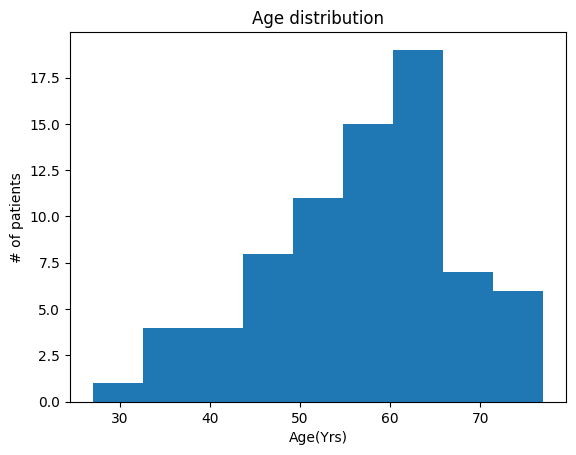

In [ ]:
plt.hist(age_array,bins='auto')
plt.xlabel('Age(Yrs)')
plt.ylabel('# of patients')
plt.title('Age distribution')

SEX DISTRIBUTION

array([47., 28.])

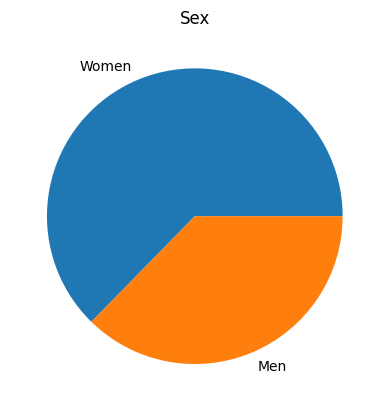

In [ ]:
sex_pie = np.zeros(2)
for i in sex_array:
  if i ==1:
    sex_pie[0] += 1
  else:
    sex_pie[1] += 1
plt.pie(sex_pie,labels=['Women','Men'])
plt.title('Sex')
sex_pie

PRIMARY TYPE TUMORS

Text(0.5, 1.0, 'PRIMARY TUMORS')

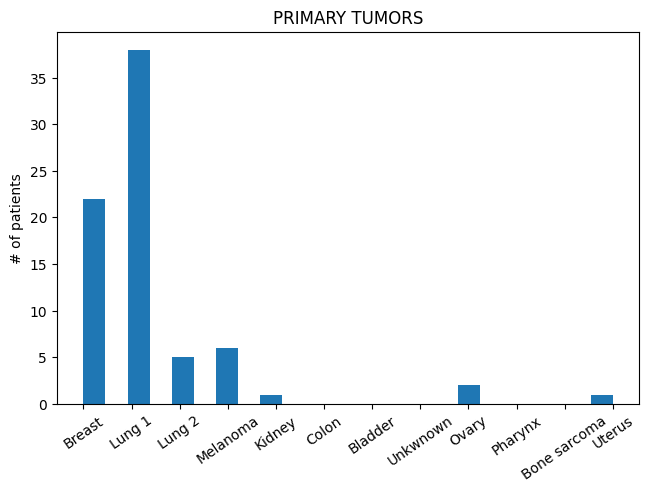

In [ ]:
plt.hist(type_array,bins='auto')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],['Breast','Lung 1','Lung 2','Melanoma','Kidney','Colon','Bladder','Unkwnown','Ovary','Pharynx','Bone sarcoma','Uterus',],rotation=35)
plt.tight_layout()
plt.ylabel('# of patients')
plt.title('PRIMARY TUMORS')

GPA DISTRIBUTION

Text(0.5, 1.0, 'GPA distribution')

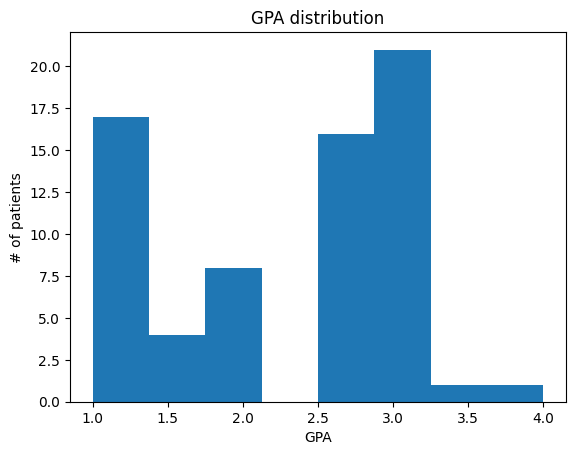

In [ ]:
plt.hist(gpa_array,bins='auto')
plt.xlabel('GPA')
plt.ylabel('# of patients')
plt.title('GPA distribution')

NUMBER OF LESIONS

Text(0.5, 1.0, '# Lesion distribution ')

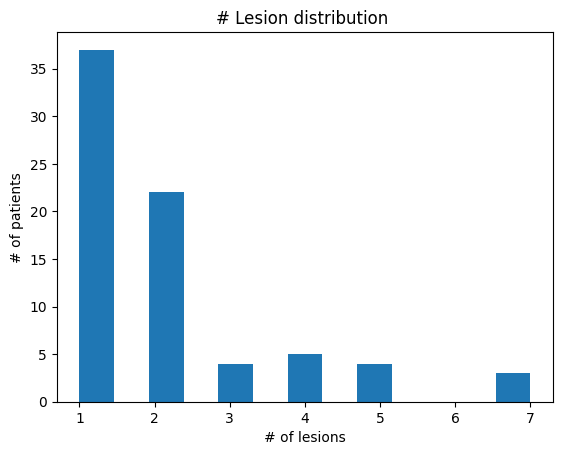

In [ ]:
nlesions = np.ones(75) #ARRAY CON EL NÚMERO DE LESIONES


j = 0
for u in range(1,len(mat_CD)):
  if mat_CD[u,0]== mat_CD[u-1,0]:
    nlesions[j] +=1
    nlesions[j] = int(nlesions[j])
  else:
    j +=1

plt.hist(nlesions,bins='auto')
plt.xlabel('# of lesions')
plt.ylabel('# of patients')
plt.title('# Lesion distribution ')

CAUSE OF DEATH

([<matplotlib.axis.XTick at 0x7b400d4c7fa0>,
 [Text(1, 0, 'Brain progression'),
  Text(2, 0, 'Systemic Illness'),
  Text(3, 0, 'Systemic+Brain Progr'),
  Text(4, 0, 'Other')])

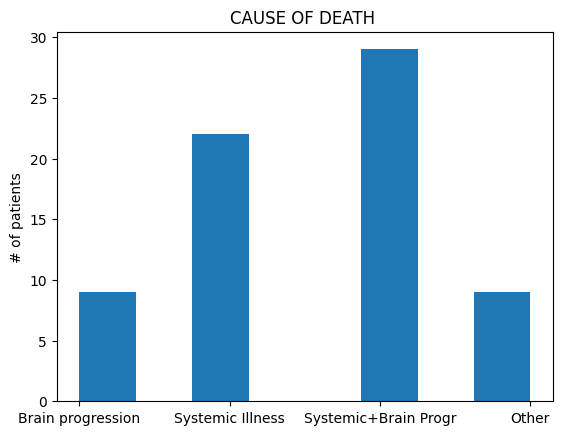

In [ ]:
plt.hist(dc_array,bins = 'auto')
plt.ylabel('# of patients')
plt.title('CAUSE OF DEATH ')
plt.xticks([1,2,3,4],['Brain progression','Systemic Illness','Systemic+Brain Progr','Other'],rotation=0)

SURVIVAL TIME VS AGE

Text(0, 0.5, 'Survival (Days)')

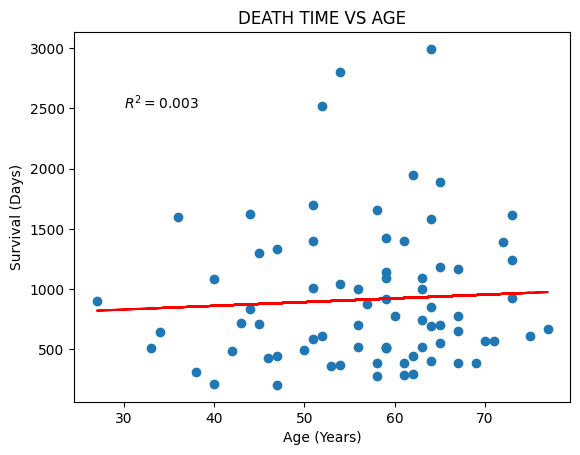

In [ ]:
# THERE'S NO CORRELATION BETWEEN SURVIVAL TIME AND AGE
age_time_corr = pearsonr(x = age_array,y = death_array)
r2 = round(age_time_corr[0]**2,3)

ajuste_age_time = linregress(age_array,death_array)
slope = ajuste_age_time[0]
intercept = ajuste_age_time[1]

plt.scatter(age_array,death_array)
plt.title('DEATH TIME VS AGE')

plt.text(30,2500,r'$R^2 = $'+ str(r2))
plt.plot(age_array,intercept + slope*age_array,'r')
plt.xlabel('Age (Years)')
plt.ylabel('Survival (Days)')

## LESIONS DATA

### SOME MANIPULATIONS (NOT ESSENTIAL)

HERE WE OBTAIN MATRICES FOR THE EVOLUTION OF THE DATA FOR EACH LESION\
BUT IN THE END WE WILL ONLY USE ONE OF THEM (PROBABLY) MAYBE USE MORE OF THEM FOR PREDICTING SURVIVAL/CAUSE OF DEATH, ADDING COLUMNS LIKE A TIME SERIES

In [ ]:
# MORPHOLOGICAL MEASURES MATRIX: mat_MM
# CLINICAL DATA MATRIX: mat_CD
'''
WE HAVE A MATRIX THAT CONTAINS THE SAME INFORMATION
AS THE DATAFRAME. TO PICK AN ELEMENT OF THE MATRIX,
mat_MM[i,j], i IS DE ROW INDEX, j IS THE COLUMN
INDEX. IF WE WANT THE LESION THAT CORRESPONDS TO THE
2ND ROW, WE PICK mat_MM[2,2].
'''
# PATIENT IDS IN CLINICAL DATA ARE STRS, WE CHANGE THEM TO NUMERICAL VALUES

for i in range(mat_CD.shape[0]):
  mat_CD[i,0] = int(mat_CD[i,0])


#OUR START MATRIX
mat = mat_CD[:,[0,4]]

mat = np.column_stack((mat,mat_CD[:,[1,2,3]])) #WE ADD COLUMNS TO OUR MATRIX

# FOR NOW WE HAVE IN THE MATRIX mat AGE, GPA & SEX


mat2 = mat[:,:2]

vol = np.zeros((154,6)) #TOTALVOLUME

times = np.zeros((154,6)) #DATES

width = np.zeros((154,6)) #CERIMWIDTH

totsurf = np.zeros((154,6)) #TOTALSURFACE

surfreg = np.zeros((154,6)) #SURFACE REGULARITY

#ROW INDEX
i = 0
#COLUMN INDEX
j = 0
#IF mat2[i,1]==mat_MM[k,1] & mat2[i,0]==mat_MM[k,0] WE ARE TALKING ABOUT THE SAME LESION FROM THE SAME PATIENT

for u in range(154):
  for k in range(1,len(mat_MM)+1):
    if mat2[u,0] == mat_MM[k-1,0]:
      if mat2[u,1] == mat_MM[k-1,2]:
        vol[u,j] = mat_MM[k-1,3]
        times[u,j] = mat_MM[k-1,1]
        width[u,j] = mat_MM[k-1,6]
        totsurf[u,j] = mat_MM[k-1,8]
        surfreg[u,j] = mat_MM[k-1,10]
        j = j+1

  j = 0

Text(0.5, 1.0, 'VOLUME EVOLUTION OF THE LESIONS')

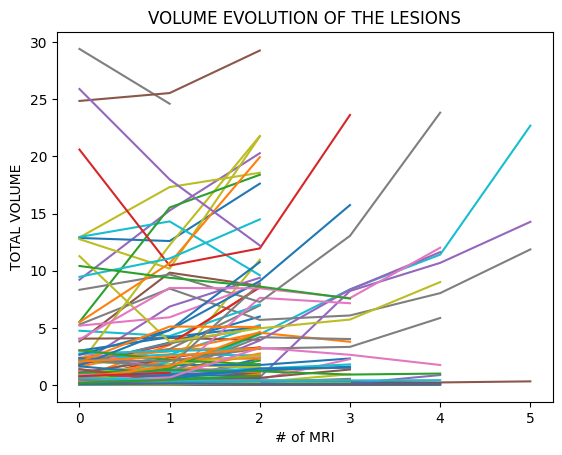

In [ ]:
for i in vol:
  plt.plot(np.delete(i,np.where(i==0)))

plt.xlabel('# of MRI')
plt.ylabel('TOTAL VOLUME')
plt.title('VOLUME EVOLUTION OF THE LESIONS')

Text(0.5, 1.0, 'WIDTH EVOLUTION OF THE LESIONS')

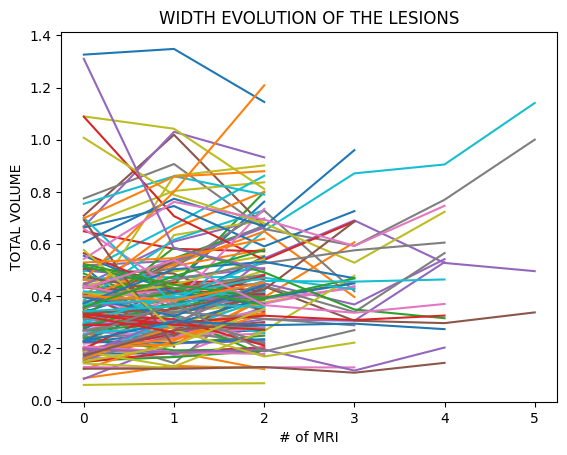

In [ ]:
for i in width:
  plt.plot(np.delete(i,np.where(i==0)))

plt.xlabel('# of MRI')
plt.ylabel('TOTAL VOLUME')
plt.title('WIDTH EVOLUTION OF THE LESIONS')

Text(0.5, 1.0, 'SURFACE REGULARITY EVOLUTION OF THE LESIONS')

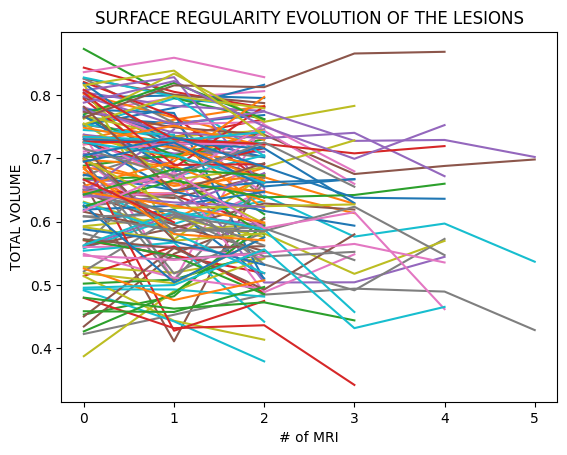

In [ ]:
for i in surfreg:
  plt.plot(np.delete(i,np.where(i==0)))

plt.xlabel('# of MRI')
plt.ylabel('TOTAL VOLUME')
plt.title('SURFACE REGULARITY EVOLUTION OF THE LESIONS')

### MORE IMPORTANT MANIPULATIONS

**TIMES**\
RIGHT NOW OUR CLINCAL DATA IS NOT COMPATIBLE WITH MORPHOLOGICAL MEASURES
AS CD HAS ITS DATES IN RELATIVE DAYS SINCE MR1 AND MM HAS ABSOLUTE DAYS. NOW WE WILL CHANGE OUR MRIS' DATES TO DAYS  

In [ ]:
times_new = np.zeros_like(times)
times_new0 = np.zeros_like(times)

for u in range(len(times)):
  if mat_CD[u-1,0]!= mat_CD[u,0]:
    fecha0 = times[u,0]

    arr11 = np.delete(times[u],np.where(times[u]==0))
    arr2 = np.zeros_like(arr11)

    for i in range(1,len(arr11)):
      arr2[i] = datesdiff(arr11[i-1],arr11[i])+arr2[i-1]
    l = len(arr2)
    times_new0[u,:l] = arr2

  else:
    arr12 = np.delete(times[u],np.where(times[u]==0))

    arr2 = np.zeros_like(arr12)
    for i in range(1,len(arr12)):
      arr2[i] = datesdiff(arr12[i-1],arr12[i])+ arr2[i-1]

    arr2 = arr2 + datesdiff(fecha0,arr12[0])

    l = len(arr2)
    times_new0[u,:l] = arr2

NOW WE WANT THE DAYS BETWEEN CONSECUTIVE MRIS, AS WE WILL NEED IT FOR THE MODEL

In [ ]:
times_rel = [] #DAYS BETWEEN CONSECUTIVE MRIS

for i in times_new0:
  for j in range(len(i)-1):
    if i[j+1]!=0:
      times_rel.append(i[j+1]-i[j])

#### VOLUME EVOLUTION FOR EVERY LESION

AN EXAMPLE OF A PATIENT, ITS LESIONS AND ITS TREATMENTS

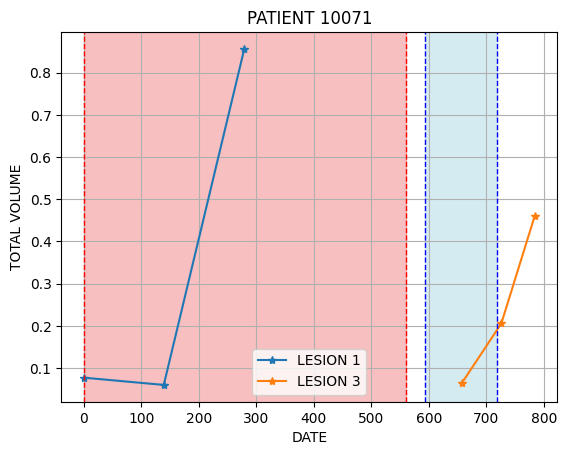

In [ ]:
u = 46

arr11 = np.delete(times[u],np.where(times[u]==0))

arr2 = np.zeros_like(arr11)
for i in range(1,len(arr11)):
  arr2[i] = datesdiff(arr11[i-1],arr11[i])+arr2[i-1]
times_new[u,:3] = arr2

plt.plot(arr2,np.delete(vol[u],np.where(vol[u]==0)),'*-',label='LESION 1')

u = 47

arr12 = np.delete(times[u],np.where(times[u]==0))

arr2 = np.zeros_like(arr12)
for i in range(1,len(arr12)):
  arr2[i] = datesdiff(arr12[i-1],arr12[i])+ arr2[i-1]

arr2 = arr2 + datesdiff(arr11[0],arr12[0])

times_new[u,:3] = arr2

plt.plot(arr2,np.delete(vol[u],np.where(vol[u]==0)),'*-',label='LESION 3')


plt.title('PATIENT 10071')
plt.grid()
plt.legend()
plt.xlabel('DATE')
plt.ylabel('TOTAL VOLUME')


# VERTICAL LINES
plt.axvline(0, color = "red", linewidth = 1, linestyle = "dashed"); # BEGIN TREATMENT 1
plt.axvline(561, color = "red", linewidth = 1, linestyle = "dashed"); # END TREATMENT 1
plt.axvline(594, color = "blue", linewidth = 1, linestyle = "dashed"); # BEGIN TREATMENT 2
plt.axvline(718, color = "blue", linewidth = 1, linestyle = "dashed"); # END TREATMENT 2

# FRANJAS DE COLOR
plt.axvspan(0, 561, alpha=0.5, color='lightcoral') # TREATMENT 1
plt.axvspan(594, 718, alpha=0.5, color='lightblue') # TREATMENT 2


NOW WE WILL PLOT, FOR EACH PATIENT, HOW THE LESIONS EVOLVE

WE CAN SEE 2 IMPORTANT FEATURES OF OUR DATASET:
* REGARDING THE TOTAL VOLUME (SUMMING EVERY LESION) OF EACH PATIENT, WE CANNOT TREAT THE PATIENT AS A WHOLE. WE MUST TREAT THE EVOLUTION OF EACH LESION INDEPENDENTLY.  
* CHAOS & VARIABILITY: SOME LESIONS APPEAR, OTHERS DISAPPEAR... NOT ENOUGH DATA

<ipython-input-41-bee2f214f5c7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


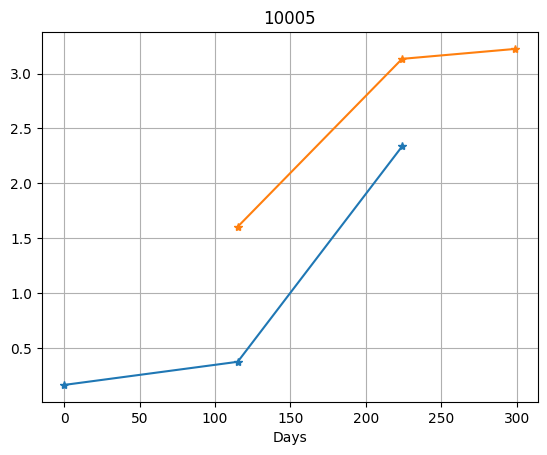

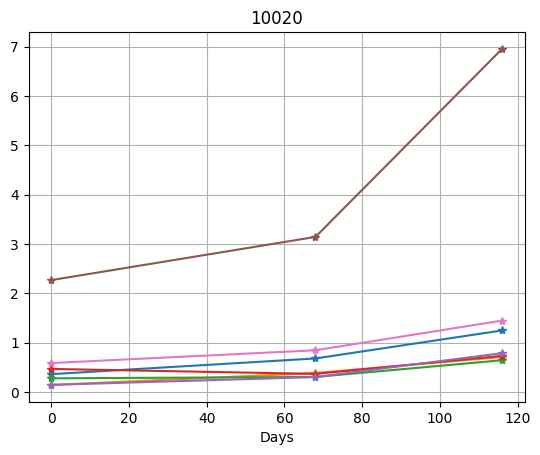

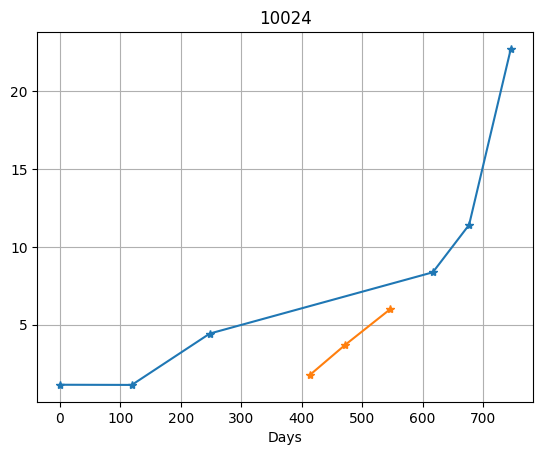

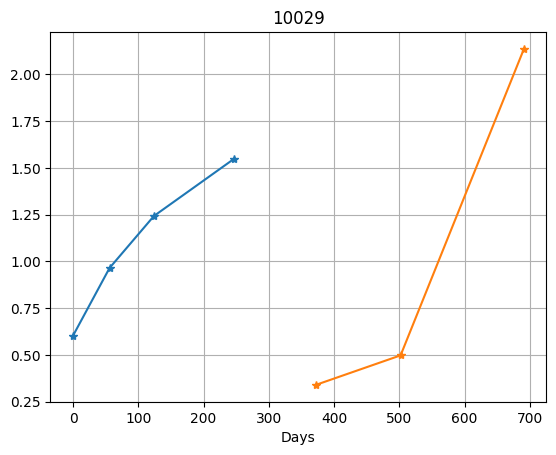

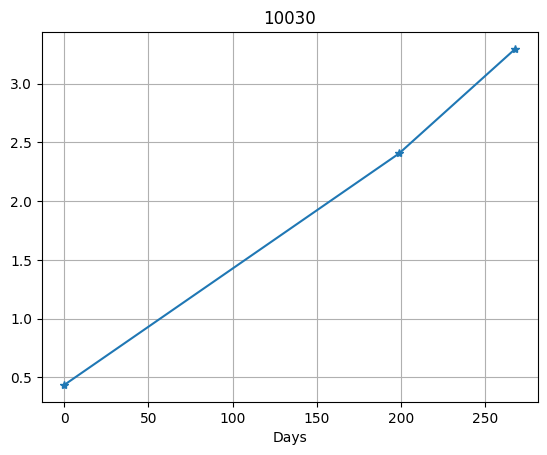

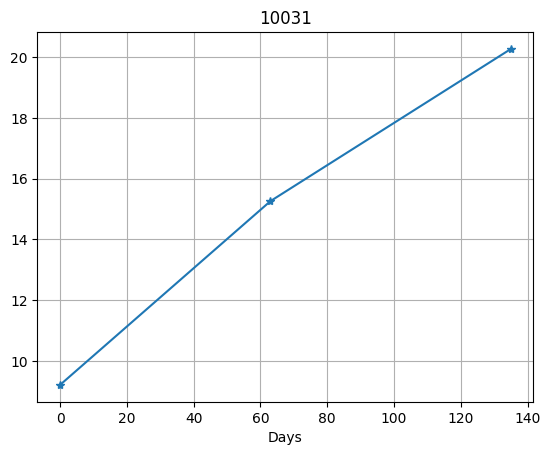

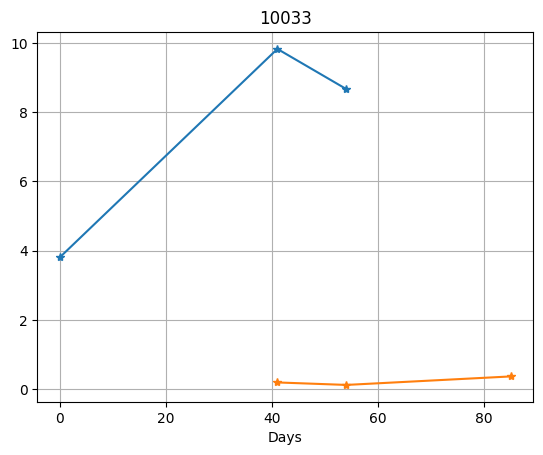

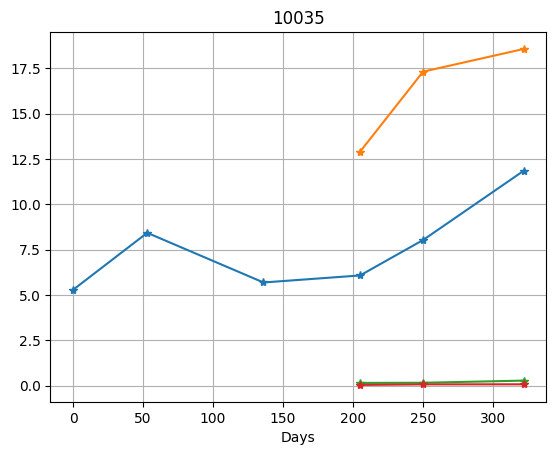

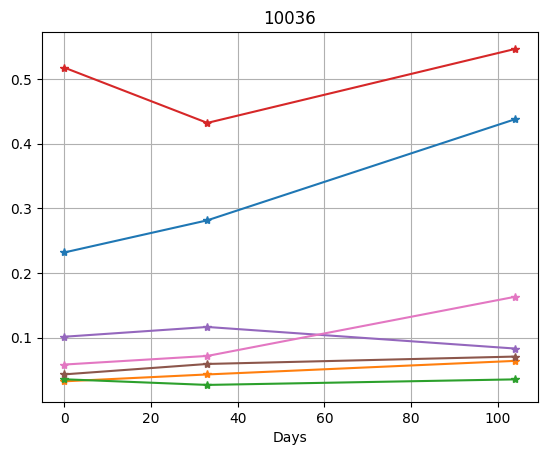

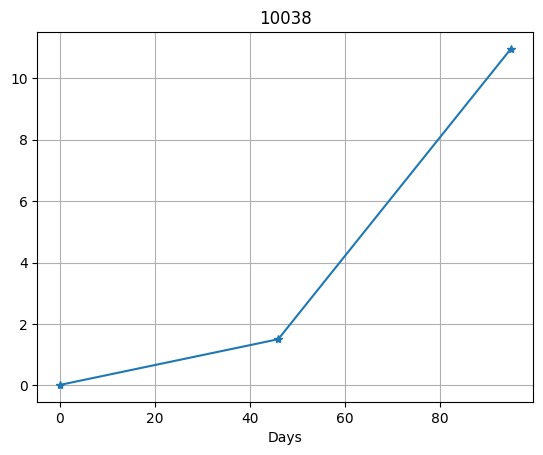

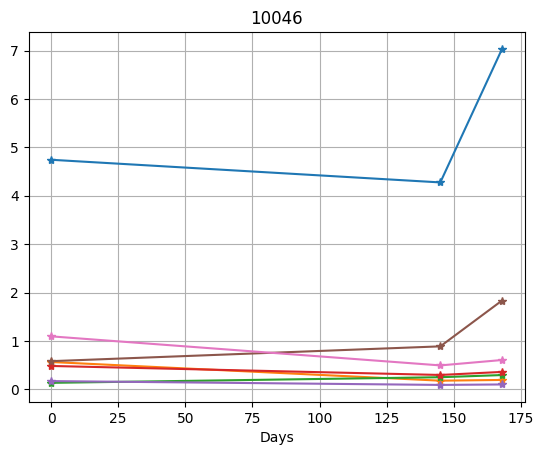

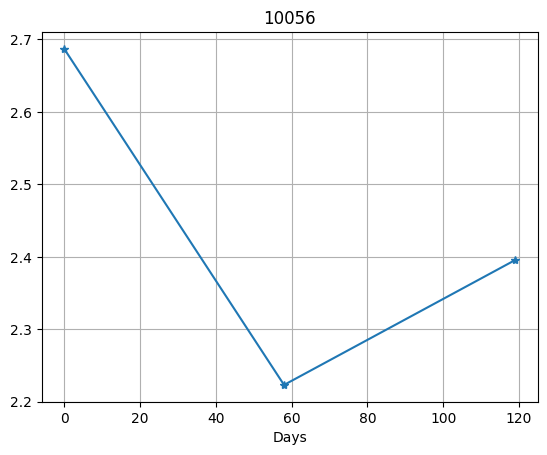

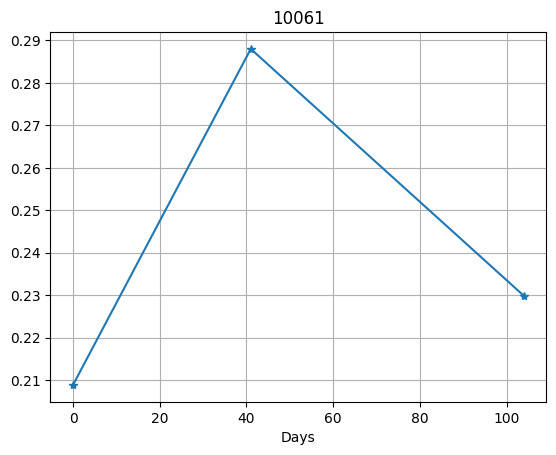

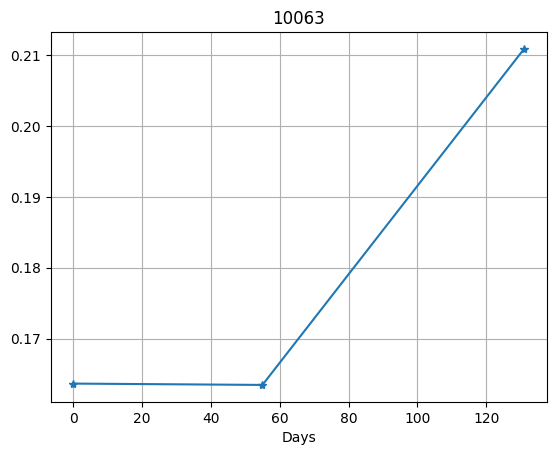

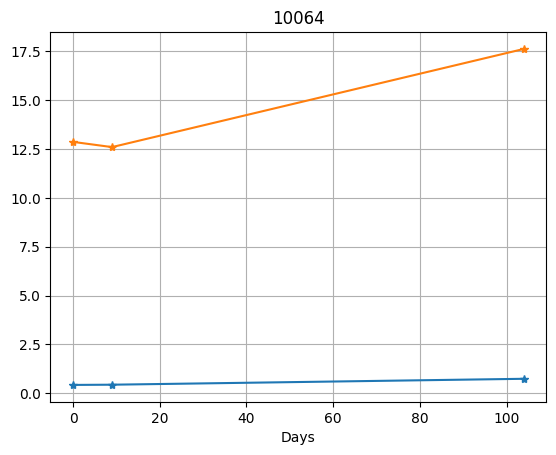

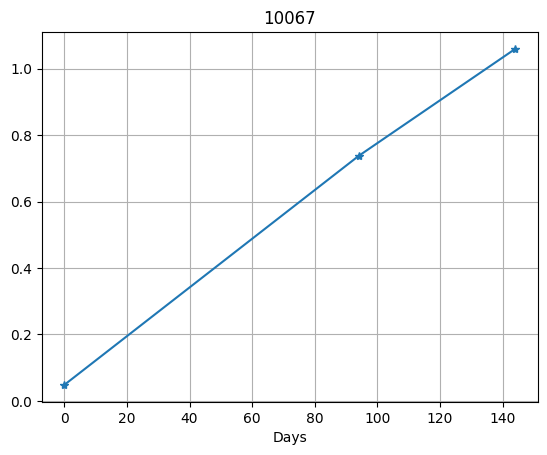

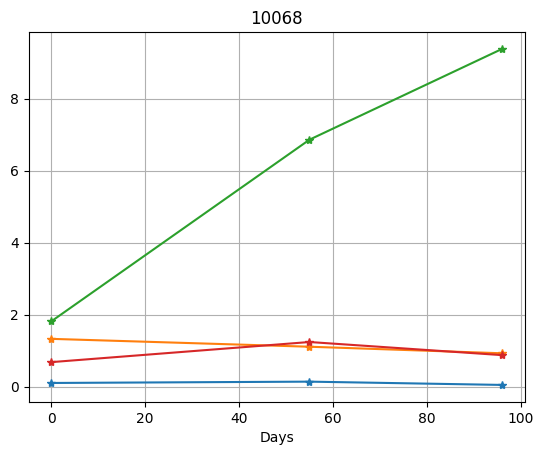

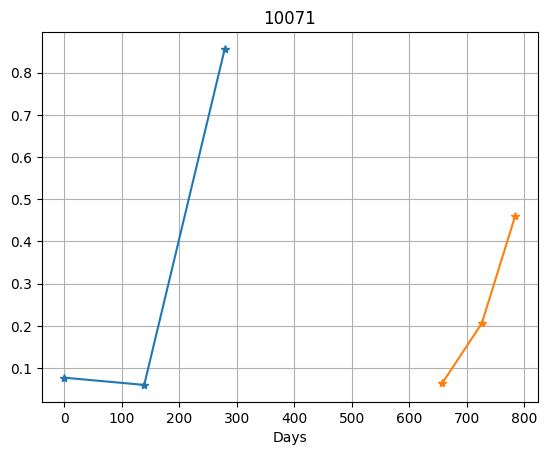

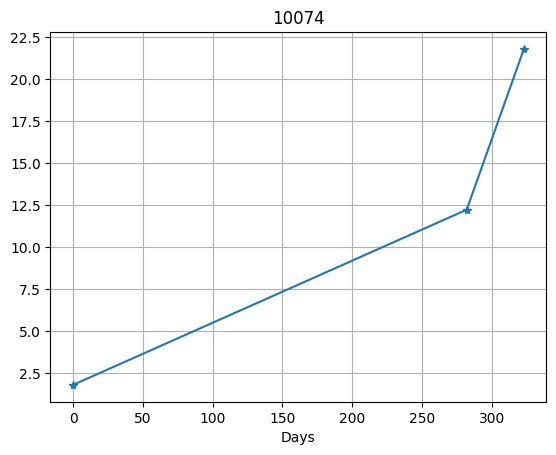

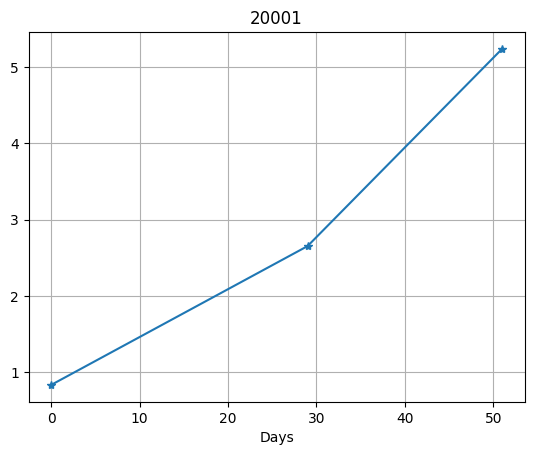

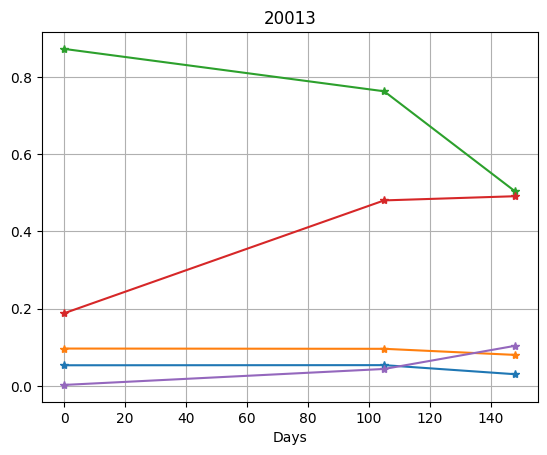

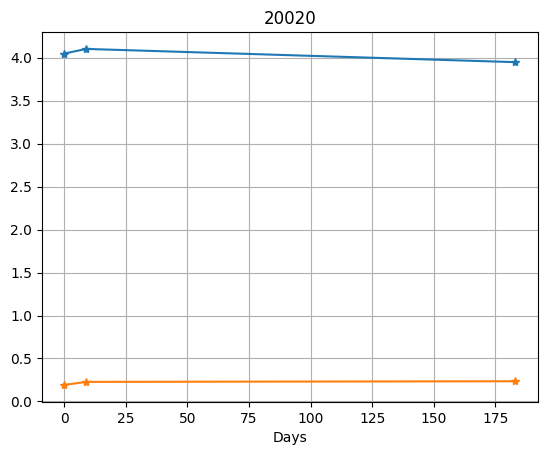

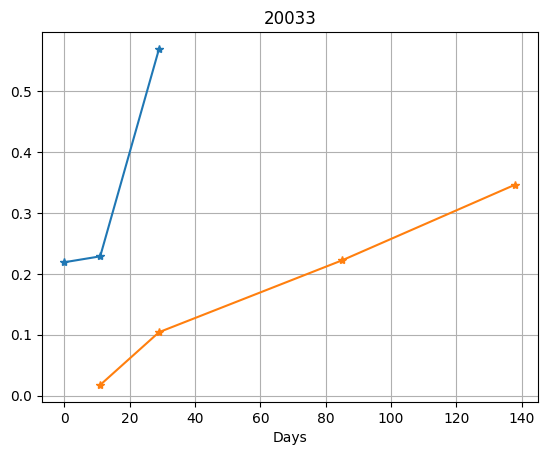

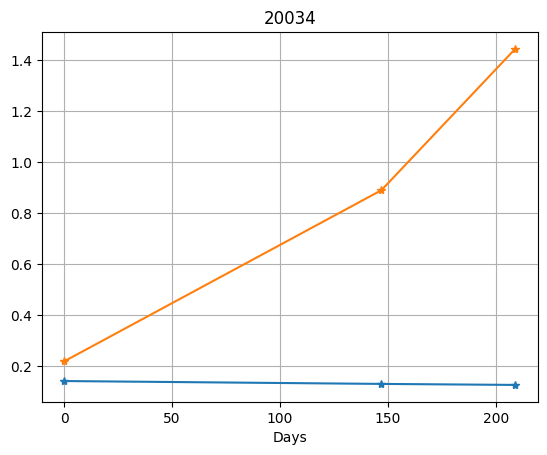

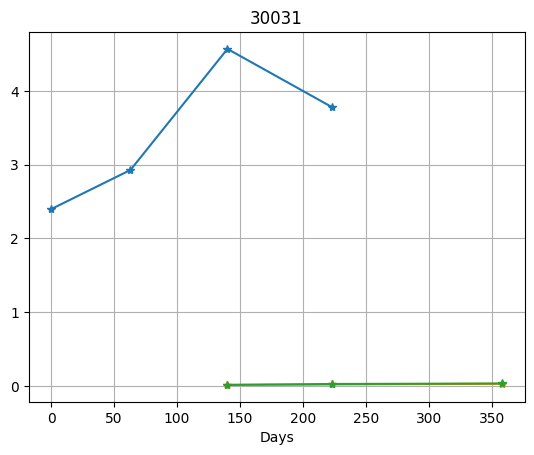

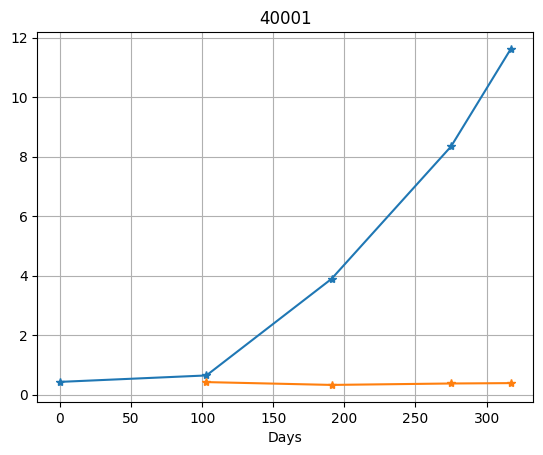

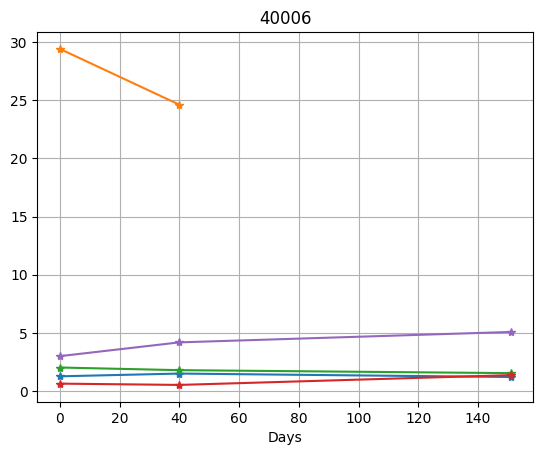

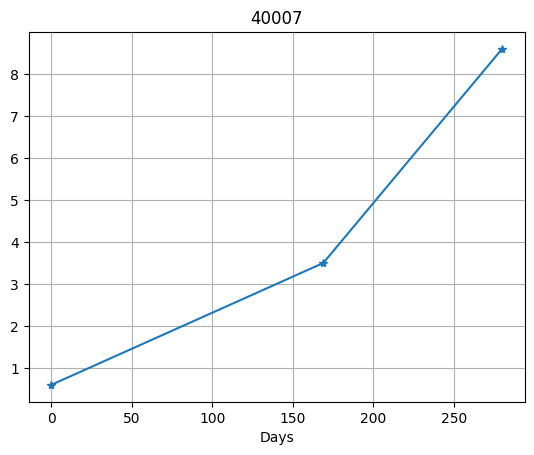

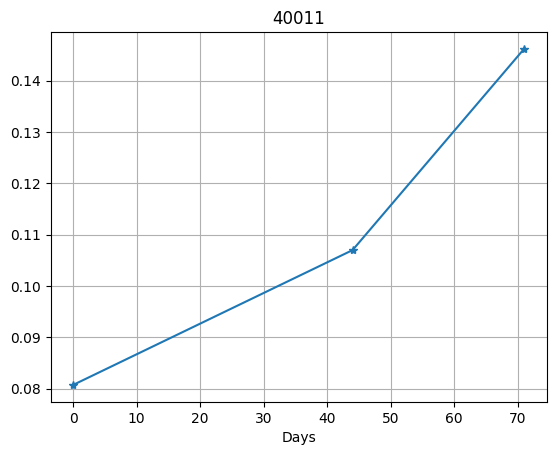

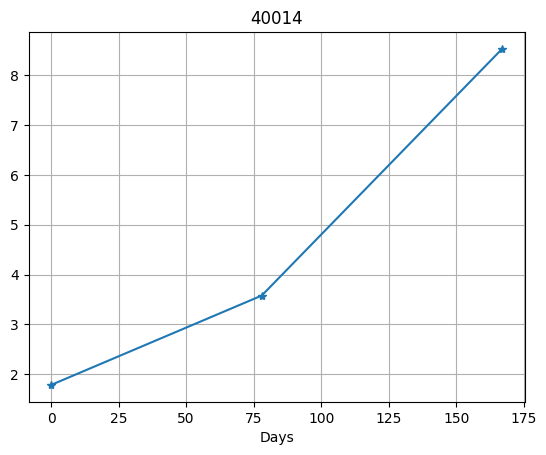

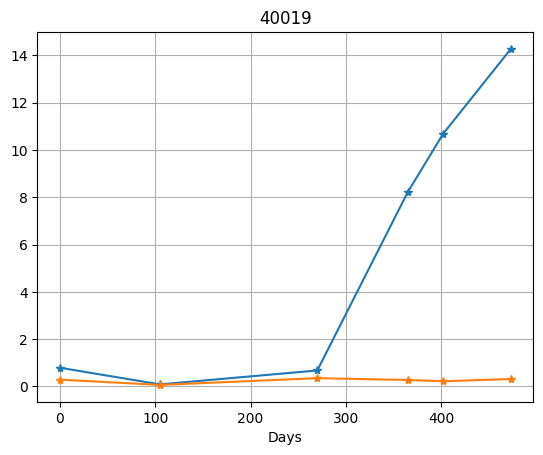

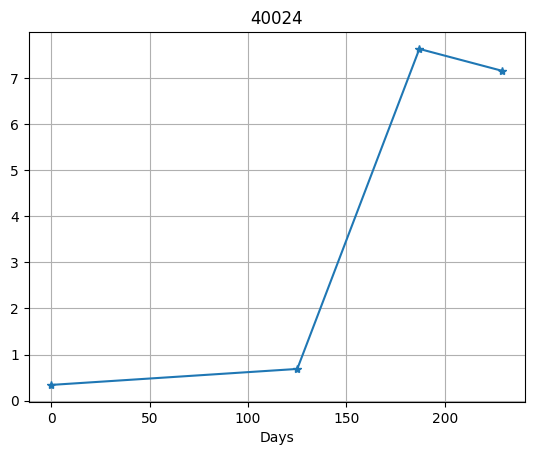

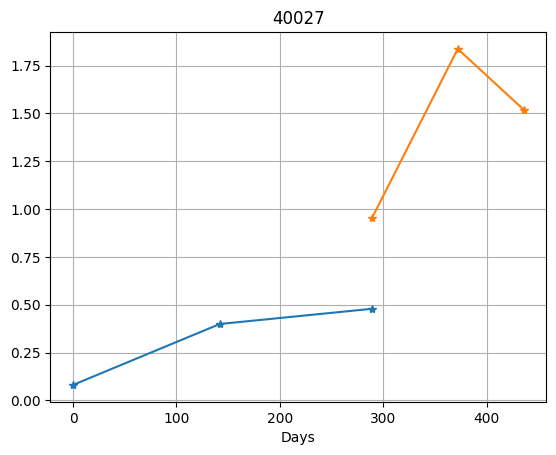

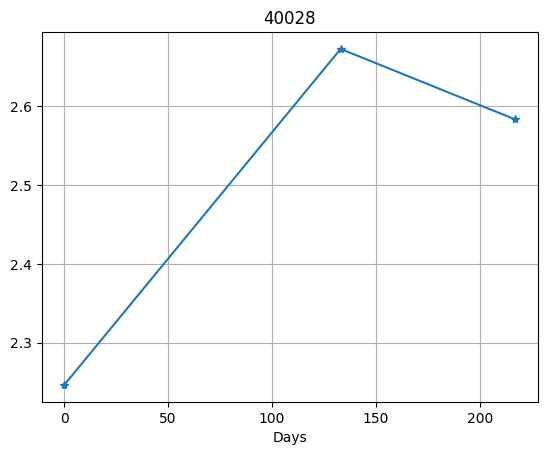

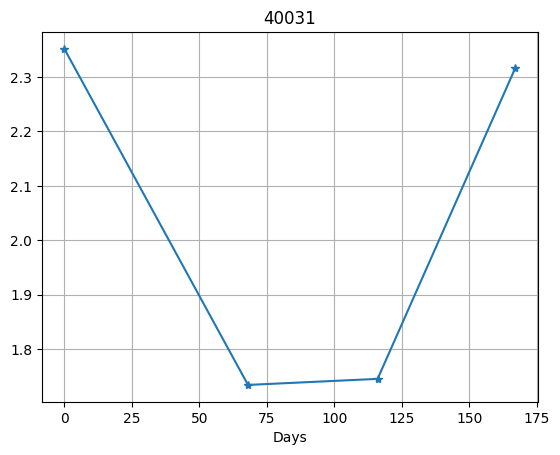

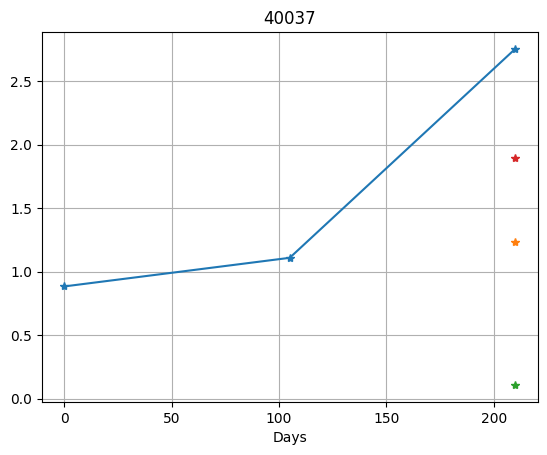

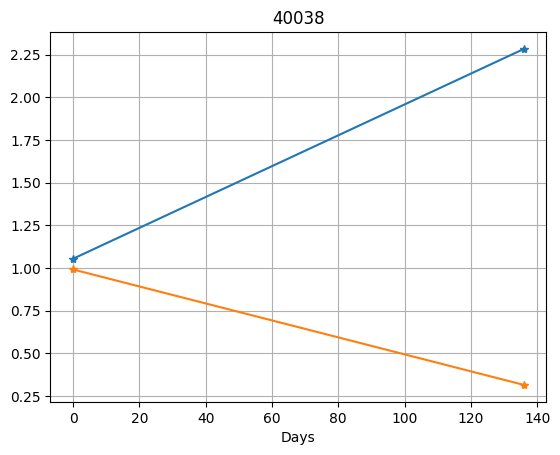

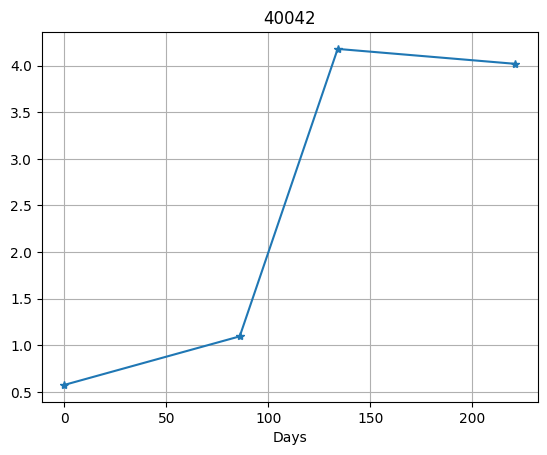

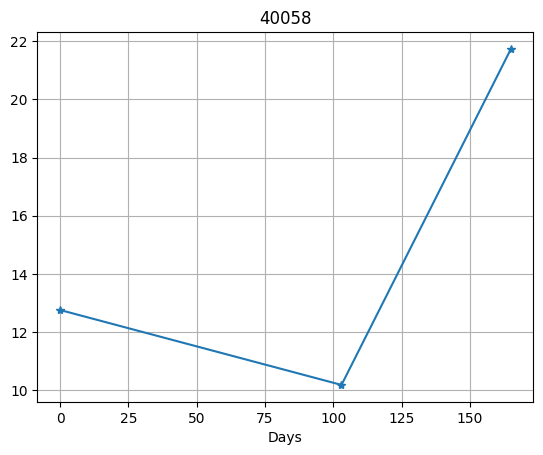

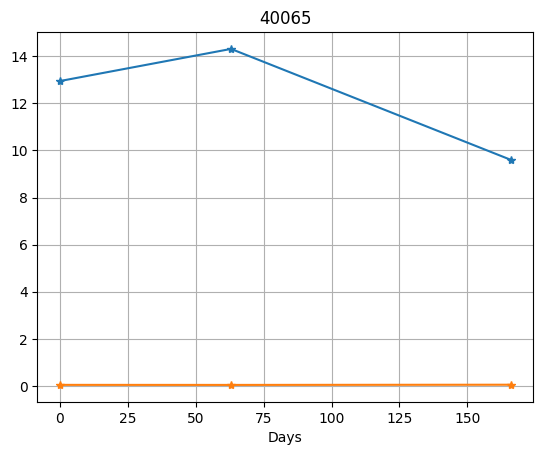

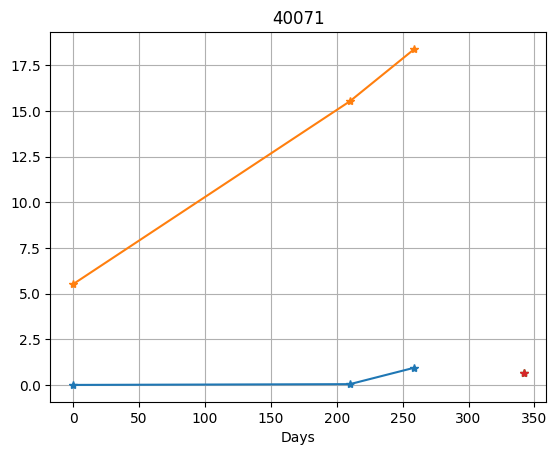

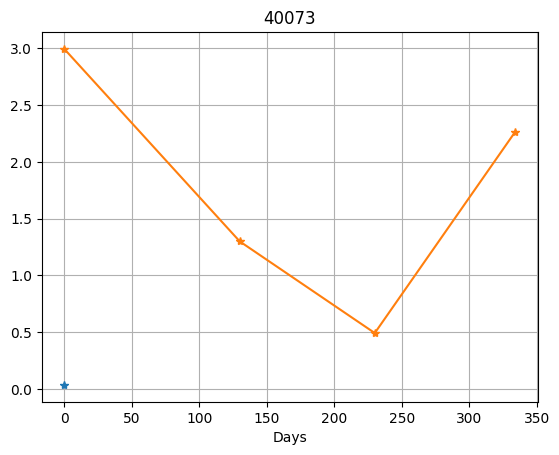

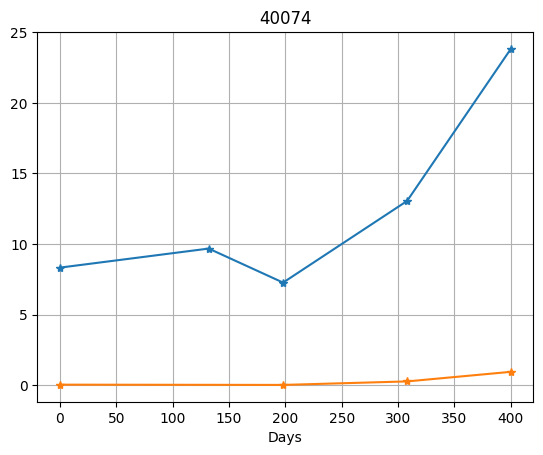

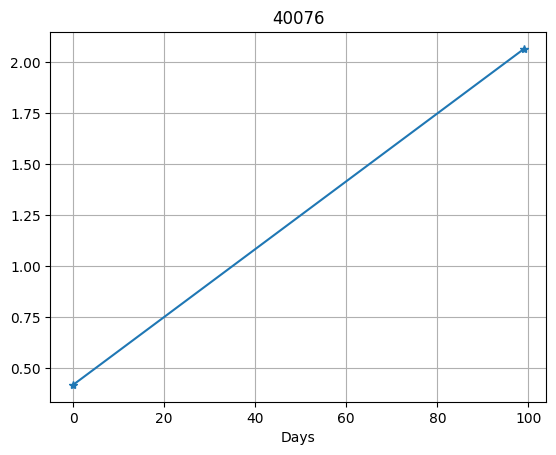

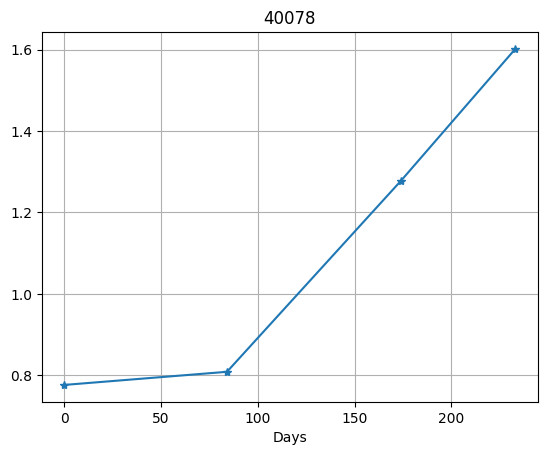

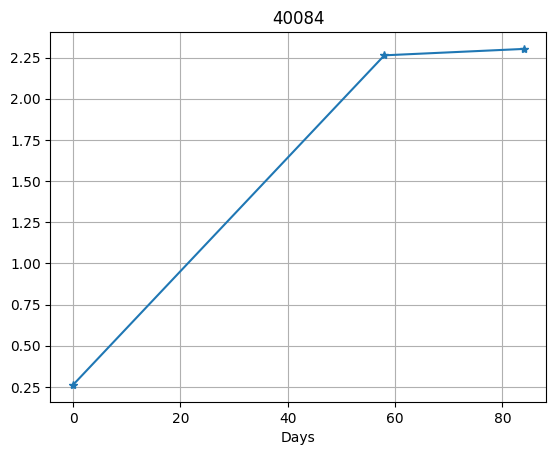

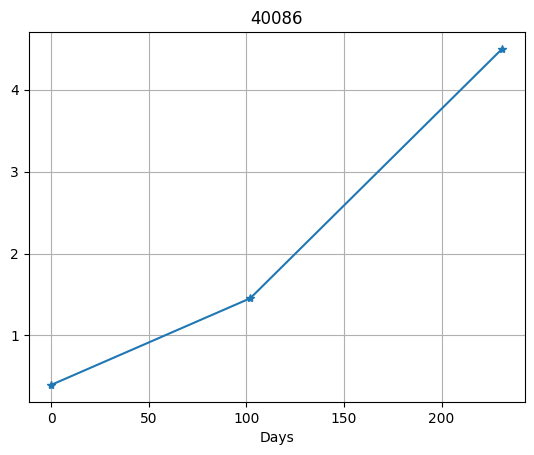

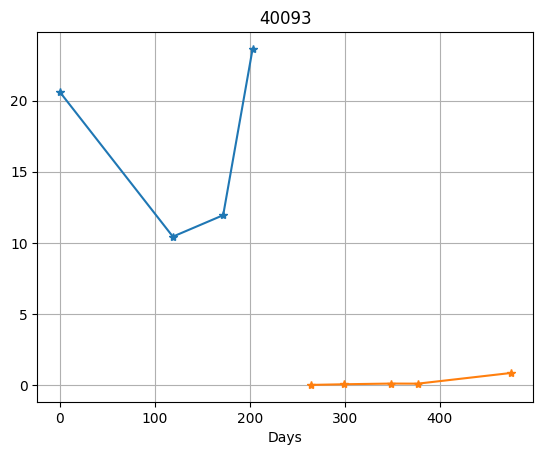

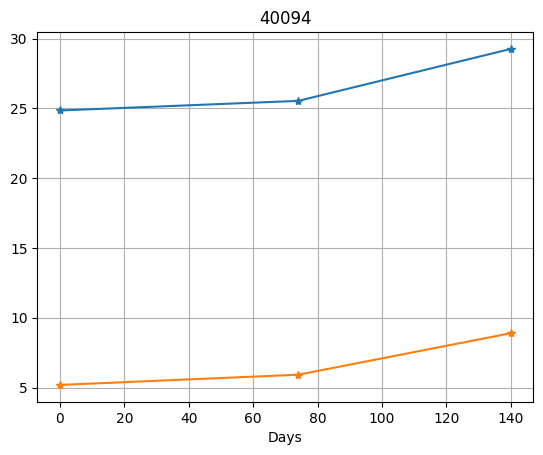

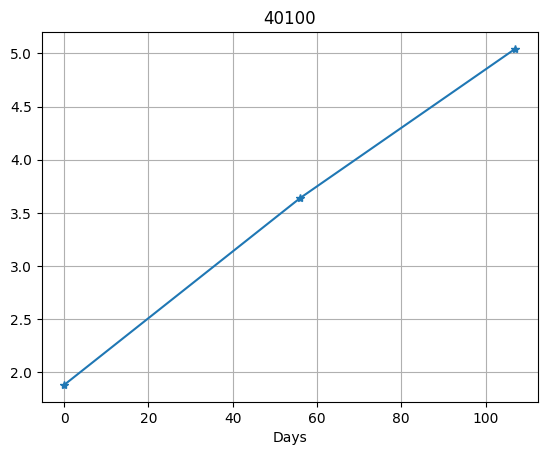

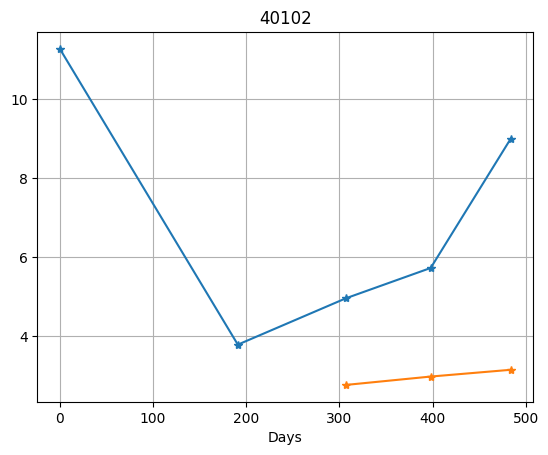

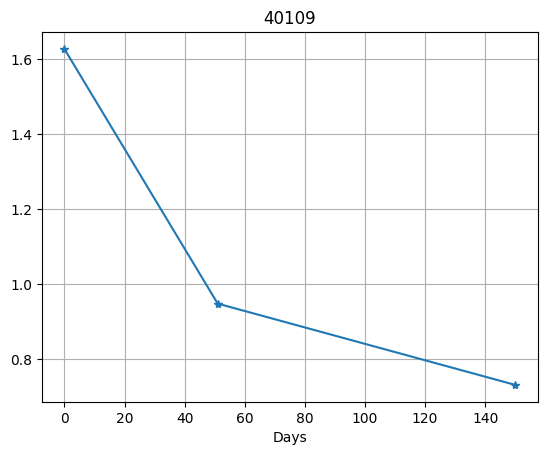

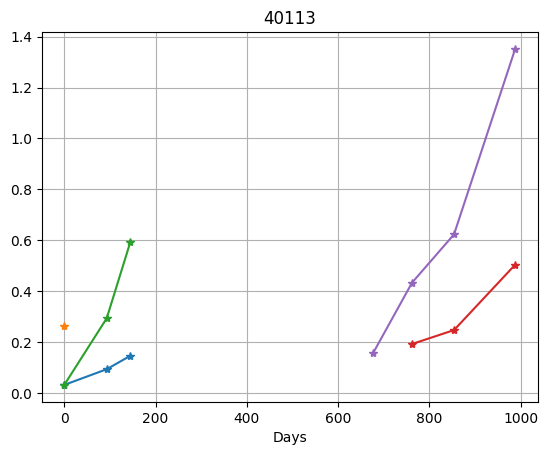

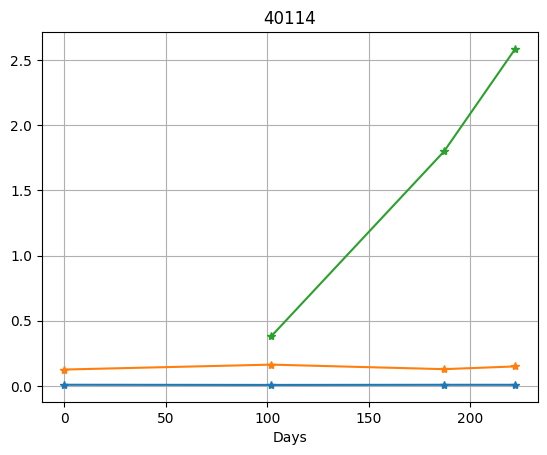

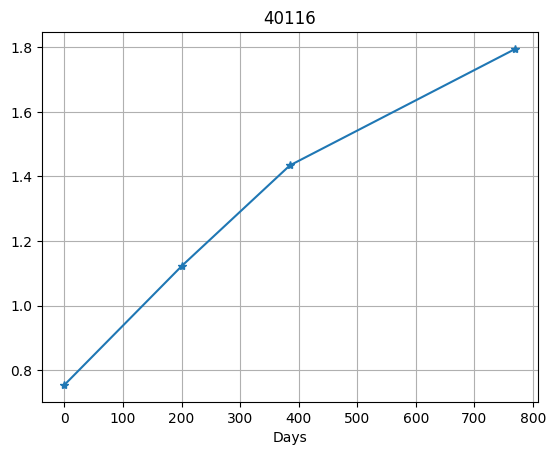

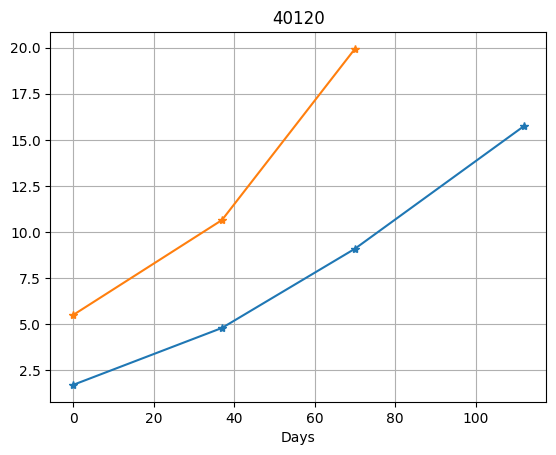

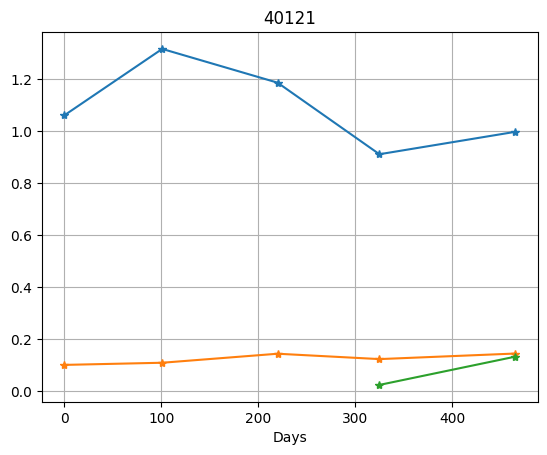

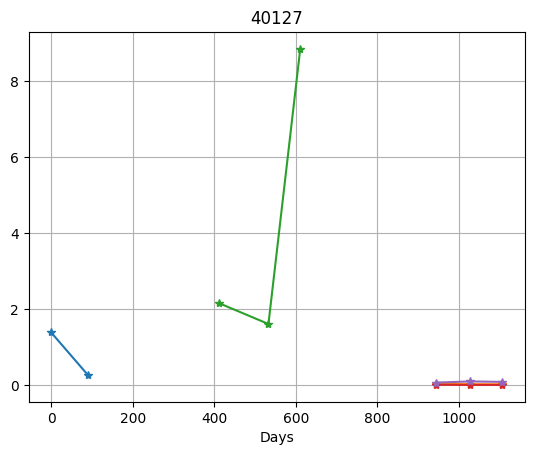

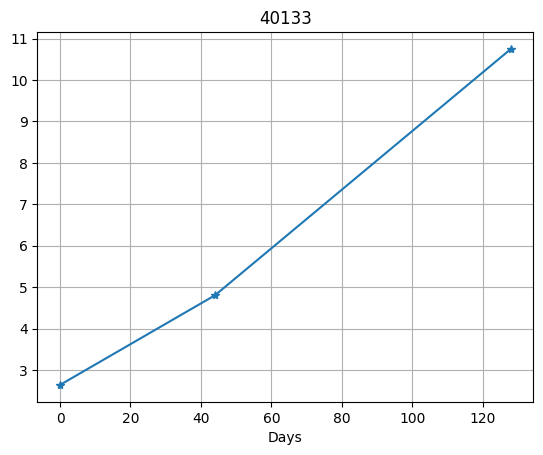

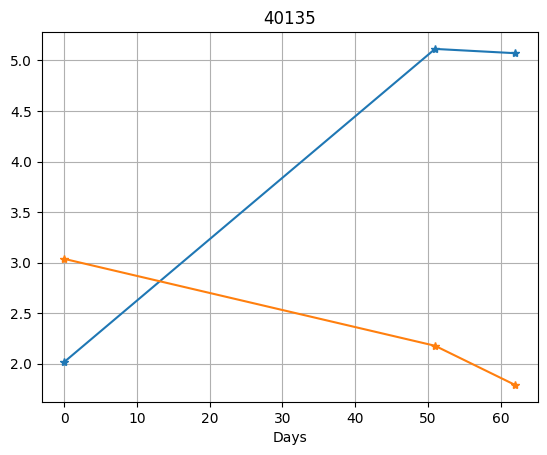

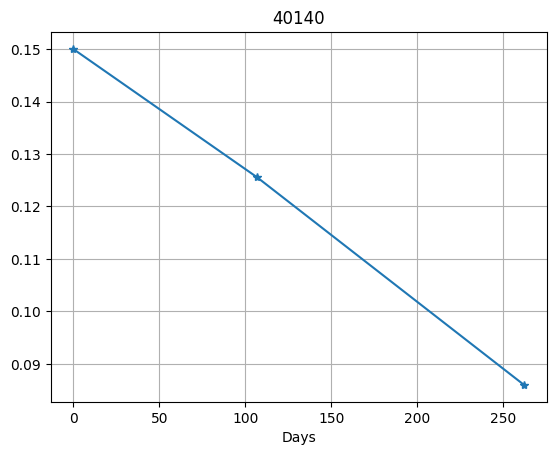

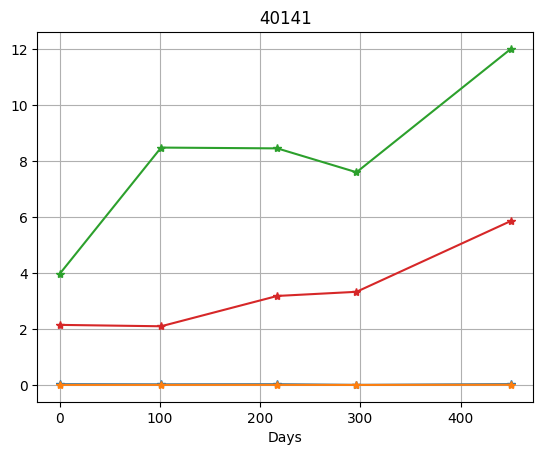

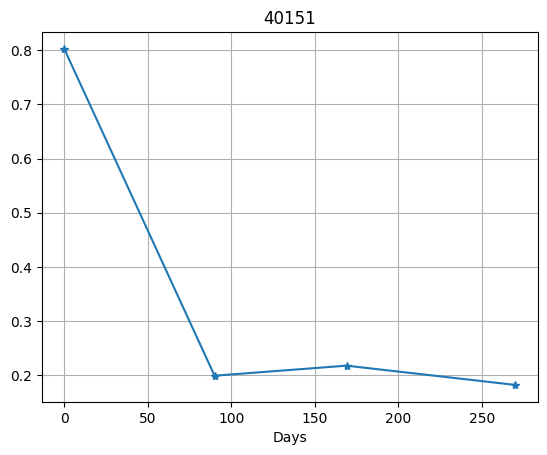

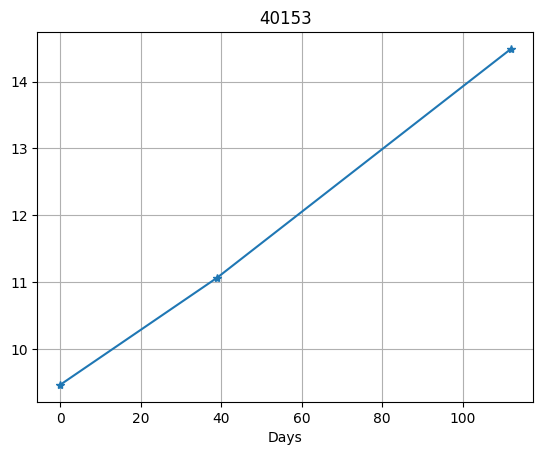

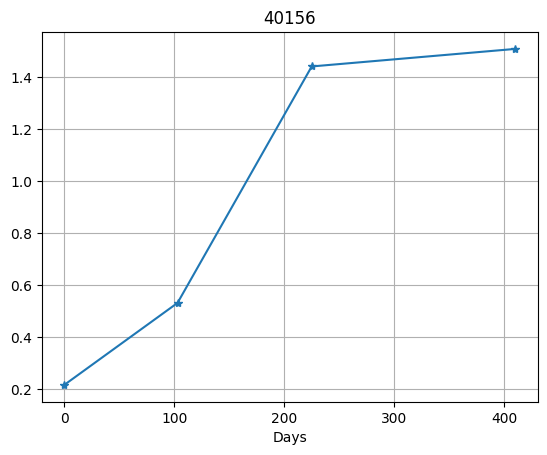

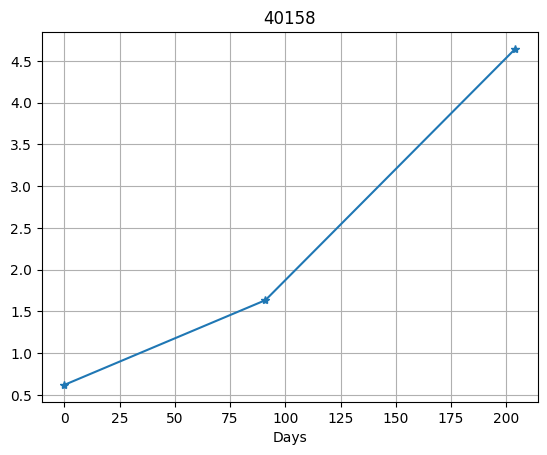

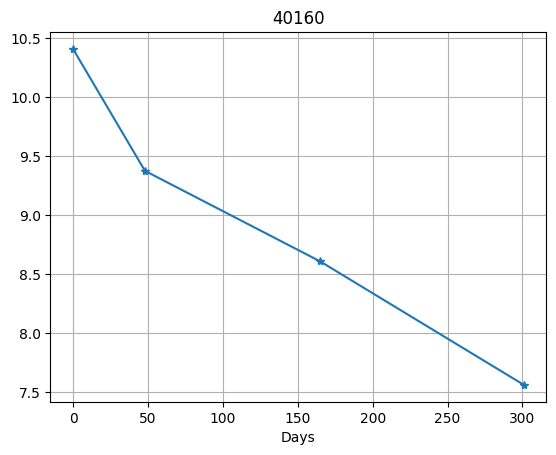

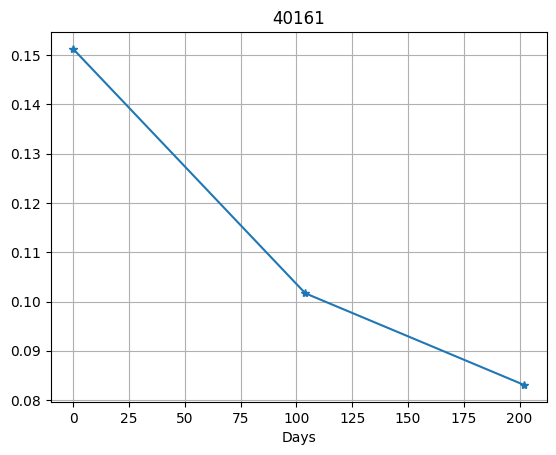

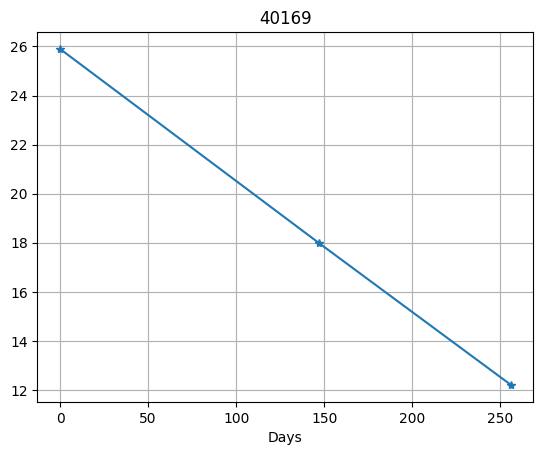

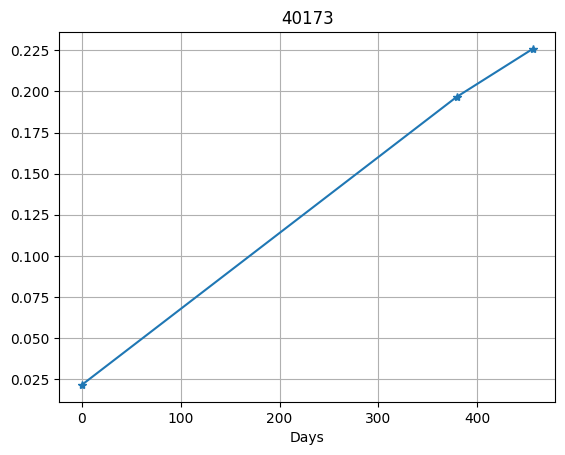

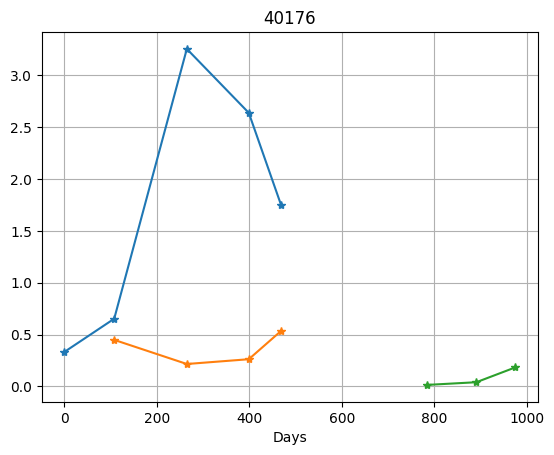

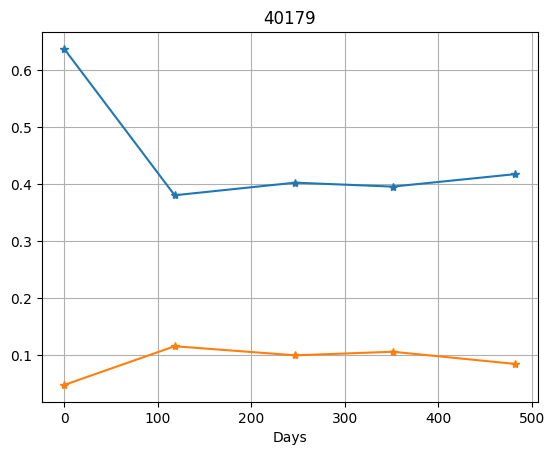

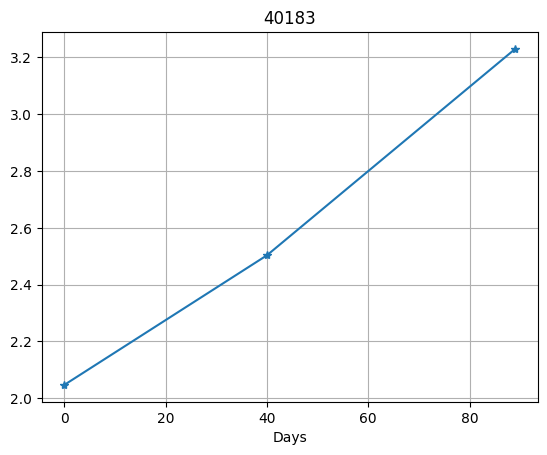

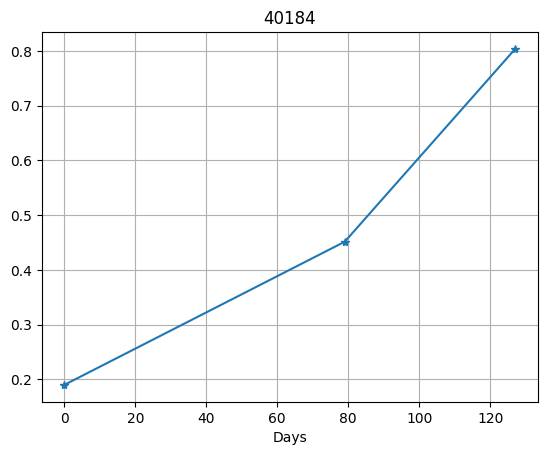

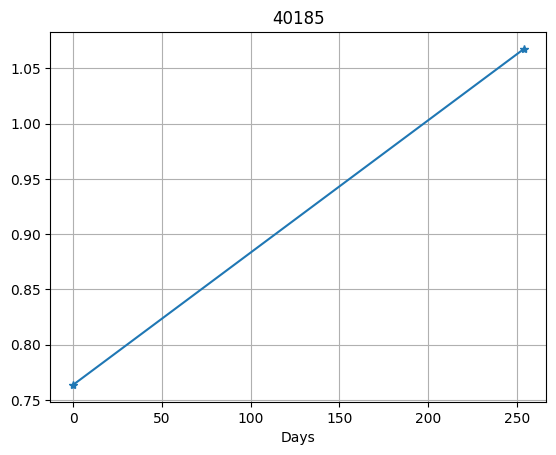

In [ ]:
u = 0
for i in range(len(patient_array)):
  plt.figure()
  plt.title('%i'%patient_array[i])
  plt.xlabel('Days')
  plt.grid()
  for j in range(int(nlesions[i])):
    plt.plot(times_new0[u,:len(np.delete(vol[u],np.where(vol[u]==0)))],np.delete(vol[u],np.where(vol[u]==0)),'*-')

    u = u+1


# 4. OBTAINING NEW VARIABLES FOR THE MODELS

NOW WE WILL OBTAIN NEW VARIABLES FOR THE SECTION 6: OBJECTIVE 2. OUR GOAL IS TO PREDICT IF, FROM THE DATA OF ONE MRI, THE VOLUME OF A LESION WILL GROW MORE THAN 30%. THEREFORE, NOW WE HAVE 499 ROWS, FOR EACH DATA POINT FROM EACH LESION

## STEREOTACTIC RADIOSURGERY & DAYS SINCE SURGERY

In [ ]:
df_MM2 = df_MM.sort_values(by=['PATIENT', 'LESION', 'TIME POINT'])

mat_MM2 = np.matrix(df_MM2)

array_times = []
for i in times_new0:
  array_times.append(0)
  for j in range(1,len(i)):
    if i[j] != 0:
      array_times.append(i[j])


df_srs = df_CD[['ID','LESION','Dosis/Frac','Nfrac.2','Begin.2','End.2']]
df_srs = df_srs.fillna(0)
mat_srs = np.matrix(df_srs)

# IF THERE HAS BEEN SRS BEFORE THE MRI
srs=np.zeros(499)

# DAYS SINCE SURGERY (0 IF NO SURGERY) ----> PROBLEM!!!

srsd = np.zeros(499)

for i in mat_srs:
  if i[0,3]!= 0:
    for k in range(len(mat_MM2)):
      if int(i[0,0]) == mat_MM2[k,0] and i[0,1] == mat_MM2[k,2]:
        if i[0,5]== ' ' and i[0,4]!= ' ':
          if i[0,4]< array_times[k]:
            srs[k] = 1
            srsd[k] = array_times[k]-i[0,4]
        elif i[0,5]!=' ':
          if i[0,5]< array_times[k]:
            srs[k] = 1
            srsd[k] = array_times[k]-i[0,5]

## WHOLE BRAIN RADIATION THERAPY

In [ ]:
df_wbrt = df_CD[['ID','LESION','Dose/Frac','Nfrac','Begin','End']]
df_wbrt = df_wbrt.fillna(0)
df_wbrt.head()

mat_wbrt = np.matrix(df_wbrt)


# IF THERE HAS BEEN WBRT BEFORE THE MRI
wbrt=np.zeros(499)

# DAYS SINCE THERAPY (0 IF NO THERAPY) ----> PROBLEM!!!
wbrtd = np.zeros(499)


for i in mat_wbrt:
  if i[0,3]!= 0:
    for k in range(len(mat_MM2)):
      if int(i[0,0]) == mat_MM2[k,0] and i[0,1] == mat_MM2[k,2]:
        if i[0,5]== ' ' and i[0,4]!= ' ':
          if i[0,4]< array_times[k]:
            wbrt[k] = 1
            wbrtd[k] = array_times[k]-i[0,4]
        elif i[0,5]!=' ':
          if i[0,5]< array_times[k]:
            wbrt[k] = 1
            wbrtd[k] = array_times[k]-i[0,5]

## SYSTEMIC TREATMENT 1

In [ ]:
df_med1 = df_CD[['ID','LESION','Drug','Begin.5','End.5']]
df_med1= df_med1.fillna(0) # NAN -> 0


#HERE WE WILL NEED TO USE TIMES_NEW0
mat_st1 = np.matrix(df_med1)
mat_st1[mat_st1 == ' ']=0 # NO_DATA -> 0
len(mat_st1)==len(times_new0)

True

In [ ]:
mat_st1[0]

matrix([['010005', 1.0, 1.0, -19, 104]], dtype=object)

In [ ]:
times_new0[0]

array([  0., 115., 224.,   0.,   0.,   0.])

A LITTLE FIGURE THAT SHOWS VISUALLY THE CODE BELOW

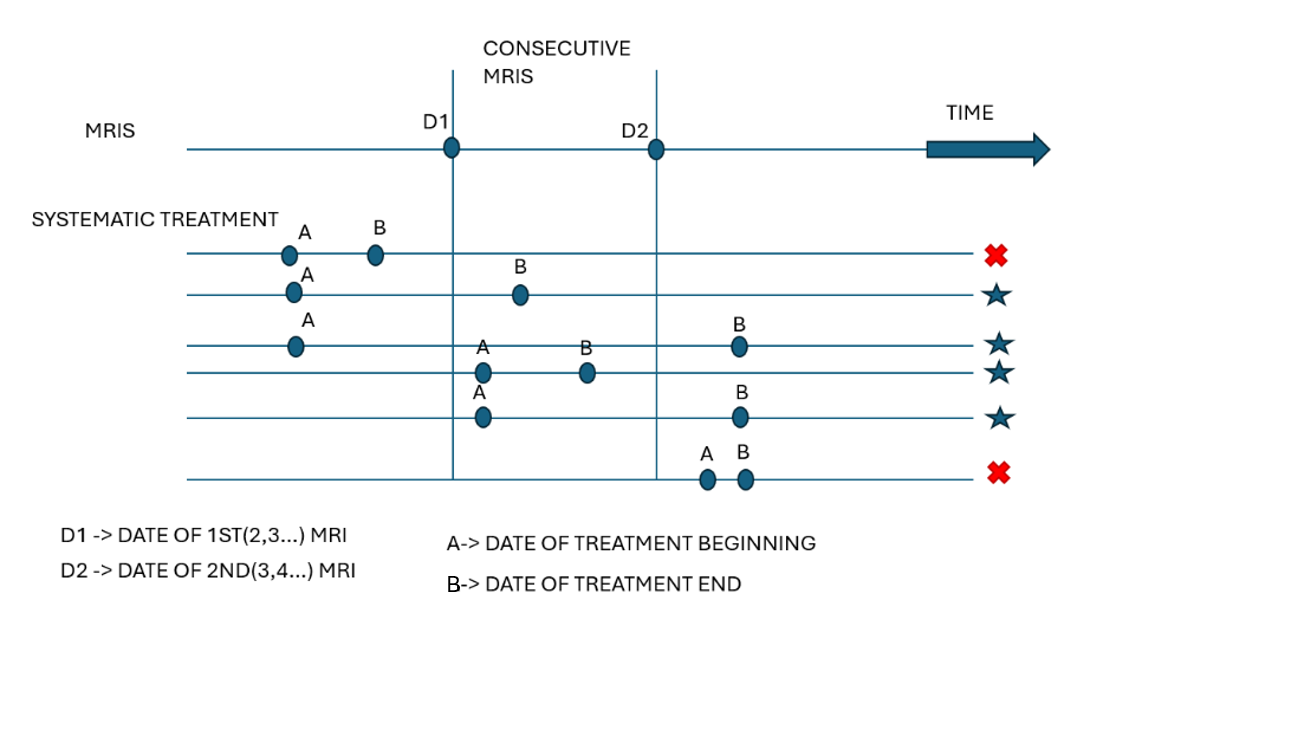

In [ ]:
# TREATMENT BETWEEN CONSECUTIVE MRIS

drug = []

#DURATION OF THE TREATMENT

drug_days = []


for i in range(len(mat_st1)):
  A = mat_st1[i,3]
  B = mat_st1[i,4]
  d = mat_st1[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug.append(0)
        drug_days.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug.append(d)
          drug_days.append(B-D1)
        elif B>= D2:
          drug.append(d)
          drug_days.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug.append(d)
          drug_days.append(D2-A)
        elif B< D2:
          drug.append(d)
          drug_days.append(B-A)
      else:
        drug.append(0)
        drug_days.append(0)

Text(0.5, 1.0, 'Distribution of Sys. Treatment 1 between consecutive MRIs')

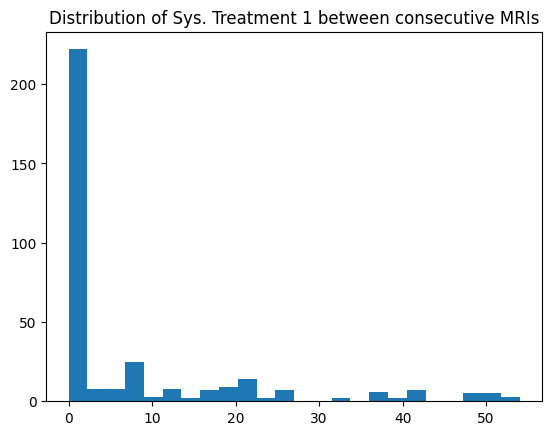

In [ ]:
plt.hist(drug,bins='auto')
plt.title('Distribution of Sys. Treatment 1 between consecutive MRIs')

WE SEE THAT MOST OF THE TIMES THERE IS NOT TREATMENT, AT LEAST TREATMENT 1

## MORE TREATMENTS

THIS DATA IS NOT APPLIED IN THIS CODE, BECAUSE IT DID NOT HAVE MUCH INFLUENCE ON THE RESULTS. FOR THE SAKE OF SIMPLICITY, WE WILL ONLY CONSIDER SYSTEMATIC TREATMENT 1. HOWEVER, THE FOLLOWING INFORMATION WOULD BE ESSENTIAL FOR A MORE EXHAUSTIVE STUDY, AS CONTAINS IMPORTANT FEATURES OF THE DATA.




HERE WE REPEAT THE SAME FOR OTHER SYSTEMATIC TREATMENTS

In [ ]:
df_med2 = df_CD[['ID','LESION','Drug.1','Begin.6','End.6']]
df_med2= df_med2.fillna(0)
mat_st2 = np.matrix(df_med2)
mat_st2[mat_st2 == ' ']=0

In [ ]:
drug2 = []

#DURATION OF THE TREATMENT

drug_days2 = []


for i in range(len(mat_st2)):
  A = mat_st2[i,3]
  B = mat_st2[i,4]
  d = mat_st2[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug2.append(0)
        drug_days2.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug2.append(d)
          drug_days2.append(B-D1)
        elif B>= D2:
          drug2.append(d)
          drug_days2.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug2.append(d)
          drug_days2.append(D2-A)
        elif B< D2:
          drug2.append(d)
          drug_days2.append(B-A)
      else:
        drug2.append(0)
        drug_days2.append(0)


In [ ]:
df_med3 = df_CD[['ID','LESION','Drug.2','Begin.7','End.7']]
df_med3= df_med3.fillna(0)
mat_st3 = np.matrix(df_med3)
mat_st3[mat_st3 == ' ']=0


drug3 = []

#DURATION OF THE TREATMENT

drug_days3 = []


for i in range(len(mat_st3)):
  A = mat_st3[i,3]
  B = mat_st3[i,4]
  d = mat_st3[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug3.append(0)
        drug_days3.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug3.append(d)
          drug_days3.append(B-D1)
        elif B>= D2:
          drug3.append(d)
          drug_days3.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug3.append(d)
          drug_days3.append(D2-A)
        elif B< D2:
          drug3.append(d)
          drug_days3.append(B-A)
      else:
        drug3.append(0)
        drug_days3.append(0)



In [ ]:
df_med4 = df_CD[['ID','LESION','Drug.3','Begin.8','End.8']]
df_med4= df_med4.fillna(0)
mat_st4 = np.matrix(df_med4)
mat_st4[mat_st4 == ' ']=0


drug4 = []

#DURATION OF THE TREATMENT

drug_days4 = []


for i in range(len(mat_st4)):
  A = mat_st4[i,3]
  B = mat_st4[i,4]
  d = mat_st4[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug4.append(0)
        drug_days4.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug4.append(d)
          drug_days4.append(B-D1)
        elif B>= D2:
          drug4.append(d)
          drug_days4.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug4.append(d)
          drug_days4.append(D2-A)
        elif B< D2:
          drug4.append(d)
          drug_days4.append(B-A)
      else:
        drug4.append(0)
        drug_days4.append(0)


In [ ]:
df_med5 = df_CD[['ID','LESION','Drug.4','Begin.9','End.9']]
df_med5= df_med5.fillna(0)
mat_st5 = np.matrix(df_med5)
mat_st5[mat_st5 == ' ']=0


drug5 = []

#DURATION OF THE TREATMENT

drug_days5 = []


for i in range(len(mat_st5)):
  A = mat_st5[i,3]
  B = mat_st5[i,4]
  d = mat_st5[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug5.append(0)
        drug_days5.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug5.append(d)
          drug_days5.append(B-D1)
        elif B>= D2:
          drug5.append(d)
          drug_days5.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug5.append(d)
          drug_days5.append(D2-A)
        elif B< D2:
          drug5.append(d)
          drug_days5.append(B-A)
      else:
        drug5.append(0)
        drug_days5.append(0)


In [ ]:
df_med6 = df_CD[['ID','LESION','Drug.5','Begin.10','End.10']]
df_med6= df_med6.fillna(0)
mat_st6 = np.matrix(df_med6)
mat_st6[mat_st6 == ' ']=0


drug6 = []

#DURATION OF THE TREATMENT

drug_days6 = []


for i in range(len(mat_st6)):
  A = mat_st6[i,3]
  B = mat_st6[i,4]
  d = mat_st6[i,2]
  for j in range(len(times_new0[i])-1):
    if times_new0[i,j+1]!=0:
      D2 = times_new0[i,j+1]
      D1 = times_new0[i,j]
      if A ==0 or B == 0 or d == 0:
        drug6.append(0)
        drug_days6.append(0)
      elif A < D1 and B > D1:
        if B < D2:
          drug6.append(d)
          drug_days6.append(B-D1)
        elif B>= D2:
          drug6.append(d)
          drug_days6.append(D2-D1)
      elif D1<A<D2:
        if B >= D2:
          drug6.append(d)
          drug_days6.append(D2-A)
        elif B< D2:
          drug6.append(d)
          drug_days6.append(B-A)
      else:
        drug6.append(0)
        drug_days6.append(0)


In [ ]:
drugs = np.column_stack((drug,drug2,drug3,drug4,drug5,drug6))
drugs_total = np.zeros((345,2))
for i in range(len(drugs)):
  if np.sum(drugs[i])!= 0:
    k = 0
    for j in drugs[i]:
      if j!=0:
        drugs_total[i,k]= j
        k +=1

In [ ]:
# IN DRUGSD WE HAVE EVERY TREATMENT WE HAVE CONSIDERED
drugsd = np.column_stack((drug_days,drug_days2,drug_days3,drug_days4,drug_days5,drug_days6,))

drugs_totald = np.zeros((345,2)) #THE MAX IS 2 DIFFERENT TREATMENTS BETWEEN CONSECUTIVE MRIS

for i in range(len(drugsd)):
  if np.sum(drugsd[i])!= 0:
    k = 0
    for j in drugsd[i]:
      if j!=0:
        drugs_totald[i,k]= j
        k +=1

In [ ]:
drugs_total_days = np.zeros(345)

for i in range(len(drugs_totald)):
  drugs_total_days[i] = np.sum(drugs_totald[i])

drugs_total_days # DAYS OF TREATMENT BETWEEN CONSECUTIVE MRIS

array([115., 109., 109.,  75.,  45.,  48.,  45.,  48.,  45.,  48.,  45.,
        48.,  45.,  48.,  45.,  48.,  45.,  48.,   0.,   0., 272.,   0.,
         0.,  58.,  65.,  56.,  68., 123., 130., 189., 166.,  69.,  63.,
        72.,  41.,  13.,  13.,  31.,  30.,  83.,  69.,  45.,  72.,  45.,
        72.,  45.,  72.,  45.,  72.,  26.,  71.,  26.,  71.,  26.,  71.,
        26.,  71.,  26.,  71.,  26.,  71.,  26.,  71.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  21.,  61.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,  44.,  41.,  44.,  41.,  44.,  41.,  44.,  41.,
         0.,   0.,  69.,  58.,  94.,  41.,  22.,   8.,   7.,   0.,   7.,
         0.,   7.,   0.,   7.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,  28., 147.,  62., 147.,  62.,  63.,  77.,
        83.,  83., 135.,  83., 135., 103.,  88.,  20.,   0.,  88.,  20.,
         0.,  40., 111.,  40.,  40., 111.,  40., 11

In [ ]:
drugs_total2 = np.zeros(149)
drugs_total2 = list(drugs_total2)

for i in drugs_total:
  for j in i:
    drugs_total2[int(j)] +=1

# The most repeated meds are:
# 0 = no med, 247 times
# 8 , 22 times
# 2 , 14 times
# 7 , 11 times
# WE ARE GOING TO CONSIDER ONLY THESE



# 0 = no med
# 1 = 8
# 2 = 2
# 3 = 7
# 4 = other


# RN IN drugs_total_days we have for the period between two consecutive mris the time of treatment,
# if there have been two treaments the time is sumed,
# if it is 0 there has been no treatment


drugs_ult = np.zeros(345)


for i in range(len(drugs_total)):
  d = np.sum(drugs_total[i])
  if d != 0:
    if d == 8:
      drugs_ult[i] = 1
    elif d == 2:
      drugs_ult[i] = 2
    elif d == 7:
      drugs_ult[i] = 3
    else:
      drugs_ult[i] = 4

([<matplotlib.axis.XTick at 0x7b4008e57a30>,
 [Text(0, 0, 'None'),
  Text(1, 0, 'Med #8'),
  Text(2, 0, 'Med #2'),
  Text(3, 0, 'Med #7'),
  Text(4, 0, 'Other med')])

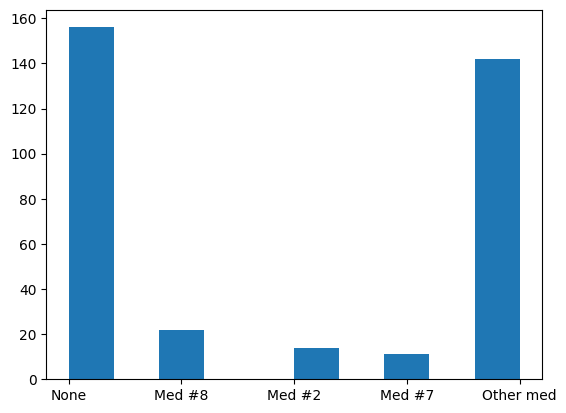

In [ ]:
plt.hist(drugs_ult,bins='auto')
plt.xticks([0,1,2,3,4],['None','Med #8','Med #2','Med #7','Other med'],rotation=0)


# 5. OBJECTIVE 1: PREDICTING SURVIVAL TIME

## BINARY : <500D, > 500D

In [ ]:
df_deaths = pd.DataFrame()
df_deaths['SEX'] = sex_array
df_deaths['AGE'] = age_array
df_deaths['DAYSTODEATH']=death_array
df_deaths['GPA']=gpa_array
df_deaths['NLESIONS']=nlesions
df_deaths['TYPE']=type_array

media_gpa = int(np.mean(df_deaths.GPA))

df_deaths = df_deaths.fillna(media_gpa)

df_deaths['DAYSTODEATH']= df_deaths['DAYSTODEATH']>500

X = df_deaths.drop(['DAYSTODEATH'],axis=1)
y =  df_deaths['DAYSTODEATH']

In [ ]:
X.head()

SEX   AGE  GPA  NLESIONS  TYPE
0  1.0  40.0  1.0       2.0   1.0
1  1.0  44.0  2.0       7.0   1.0
2  2.0  67.0  1.0       2.0   2.0
3  1.0  65.0  1.0       2.0   1.0
4  1.0  63.0  2.0       1.0   1.0

In [ ]:
y.head()

0    True
1    True
2    True
3    True
4    True
Name: DAYSTODEATH, dtype: bool

### LOGISTIC REGRESSION

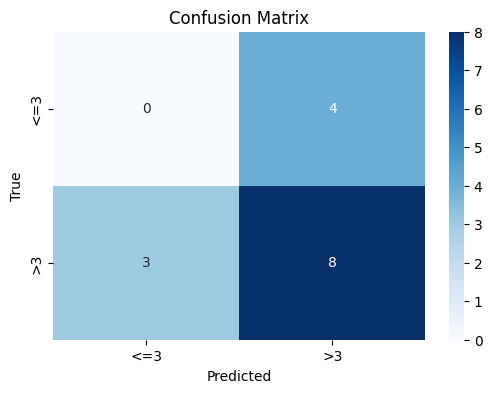

Accuracy (proporcion de aciertos) 0.5333
Precision (proporcion de verdaderos positivos entre todos los positivos) 0.6667
Recall (proporcion de verdaderos positivos) 0.7273
Especificidad (proporcion de verdaderos negativos) 0.0


In [ ]:
# A FIRST EXAMPLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=.20, stratify=y, random_state=1)


logreg = LogisticRegression(solver="liblinear", max_iter=1000) #class_weight='balanced')
logreg.fit(xtrain, ytrain)


# Create the confusion matrix from true values and predictions on test dataset
predictions = logreg.predict(xtest)
cm = confusion_matrix(ytest, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(["<=3",">3"]),
            yticklabels=np.unique(["<=3",">3"]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Define the values of the confusion matrix
TN = cm[0,0]
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]


print("Accuracy (proporcion de aciertos)", round((TP+TN)/(TP+TN+FN+FP),4))
print("Precision (proporcion de verdaderos positivos entre todos los positivos)", round((TP)/(TP+FP),4))
print("Recall (proporcion de verdaderos positivos)", round((TP)/(TP+FN),4))
print("Especificidad (proporcion de verdaderos negativos)", round((TN)/(TN+FP),4))



In [ ]:
#NOW WE WANT THE MEAN ACCURACY FOR MANY SEEDS


def LogReg2C(X,y,n_states):
  acc = []
  for i in range(n_states):
    xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, stratify=y, random_state=i)


    logreg = LogisticRegression(solver="liblinear", max_iter=1000) #class_weight='balanced')
    logreg.fit(xtrain, ytrain)


    # Create the confusion matrix from true values and predictions on test dataset
    predictions = logreg.predict(xtest)
    cm = confusion_matrix(ytest, predictions)
    TN = cm[0,0]
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]


    acc.append(round((TP+TN)/(TP+TN+FN+FP),4))
  print(np.mean(acc))
  print(np.sqrt(np.var(acc)))
  plt.hist(acc,bins='auto')
  plt.xlabel('Accuracy')




0.7119866799999999
0.044242891525957014


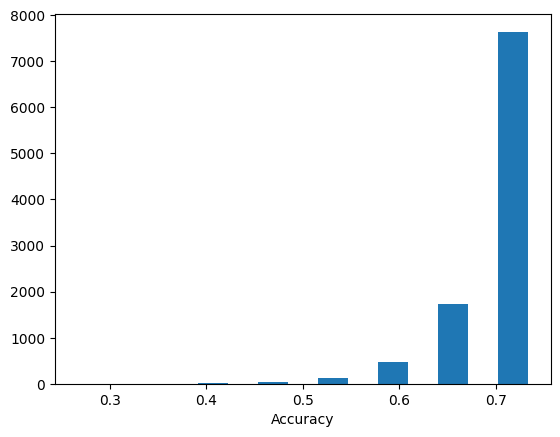

In [ ]:
LogReg2C(X,y,10000)

A VERY GOOD RESULT: WE GET AN ACCURACY OF $ 0.71 \pm 0.04 $ FOR 10,000 DIFFERENT SEEDS

### DECISION TREE CLASSIFIER

In [ ]:
# WE DEFINE A FUNCTION THAT WILL CALC THE AUC FOR 5000 SEEDS (RANDOM STATES) IN ORDER TO CHECK THE MODEL
def DecisionTreeClass(X,y,t_s,n_states,m_d):
  aucs = []
  for i in range(n_states):

    train_errors = {}
    test_errors = {}
    val_errors = {}

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_s,random_state=i, stratify=y)

    # Decision Tree training
    dt_model = DecisionTreeClassifier(max_depth=m_d)
    dt_model.fit(X_train, y_train)


    # Train estimations
    preds_dt_train = dt_model.predict(X_train)
    probs_dt_train = dt_model.predict_proba(X_train)
    probs_dt_train = [x[1] for x in probs_dt_train]


    accuracy_dt_train = accuracy_score(y_train, preds_dt_train)
    precision_dt_train = precision_score(y_train, preds_dt_train)#
    recall_dt_train = recall_score(y_train, preds_dt_train)#
    f1_dt_train = f1_score(y_train, preds_dt_train)#
    auc_dt_train = roc_auc_score(y_train, probs_dt_train) #

    # Test estimations
    preds_dt_test = dt_model.predict(X_test)
    probs_dt_test = dt_model.predict_proba(X_test)
    probs_dt_test = [x[1] for x in probs_dt_test]#

    accuracy_dt_test = accuracy_score(y_test, preds_dt_test)
    precision_dt_test = precision_score(y_test, preds_dt_test)#
    recall_dt_test = recall_score(y_test, preds_dt_test)#
    f1_dt_test = f1_score(y_test, preds_dt_test)#
    auc_dt_test = roc_auc_score(y_test, probs_dt_test)


    aux_error_train = {'accuracy': accuracy_dt_train, 'precision': precision_dt_train, 'recall': recall_dt_train, 'f1': f1_dt_train, 'auc': auc_dt_train}
    aux_error_test = {'accuracy': accuracy_dt_test, 'precision': precision_dt_test, 'recall': recall_dt_test, 'f1': f1_dt_test, 'auc': auc_dt_test}

    train_errors['DT'] = aux_error_train
    test_errors['DT'] = aux_error_test


    dt_fpr_test, dt_tpr_test, dt_threshold_test = roc_curve(y_test, probs_dt_test)
    dt_roc_auc_test = auc(dt_fpr_test, dt_tpr_test) # auc: area under curve
    aucs.append(dt_roc_auc_test)
    # print(dt_roc_auc_test)
  return aucs


1
0.5859431818181818
-------
2
0.6084886363636363
-------
3
0.6331704545454546
-------
4
0.6699772727272727
-------
5
0.6570568181818183
-------
6
0.6484204545454545
-------
7
0.6366590909090909
-------
8
0.6334659090909092
-------
9
0.6348068181818183
-------
10
0.6308863636363637
-------


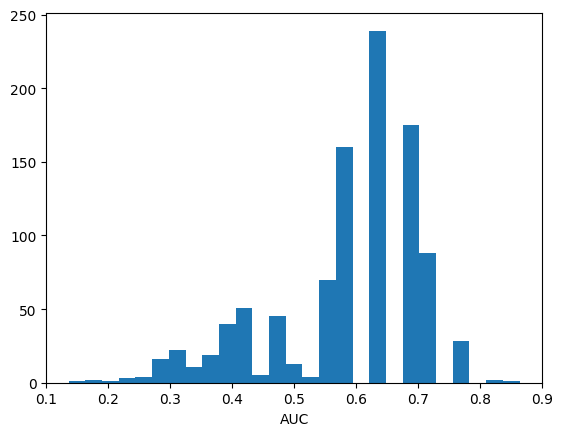

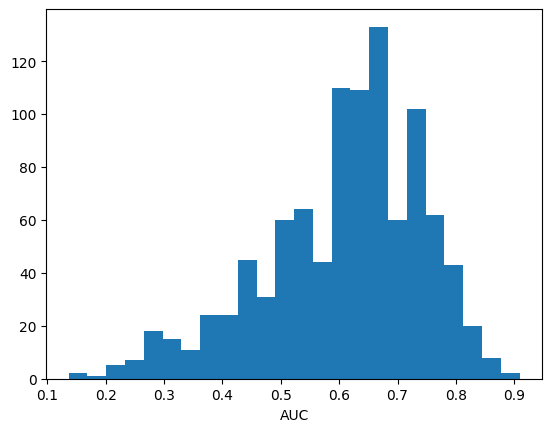

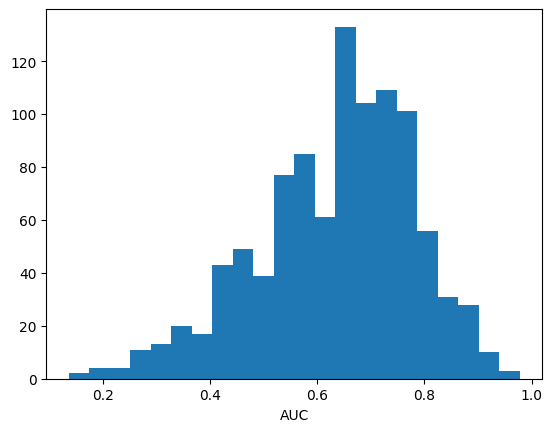

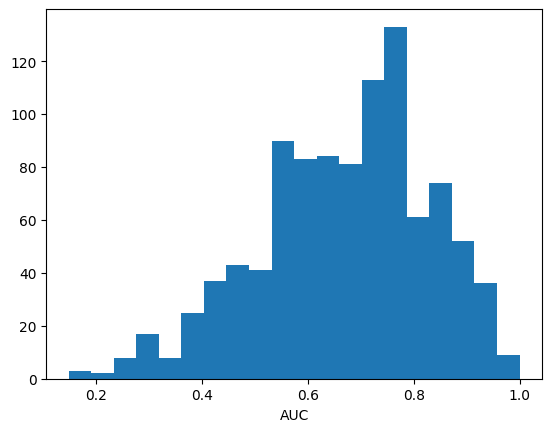

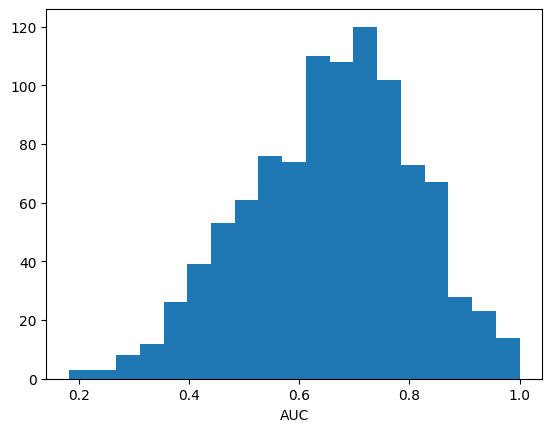

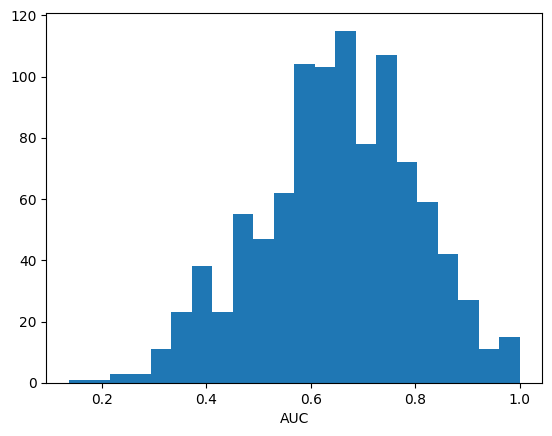

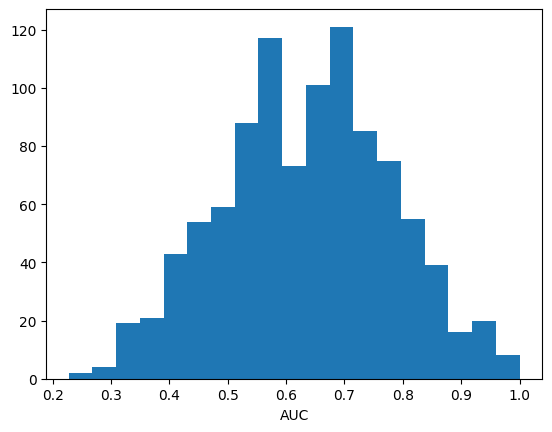

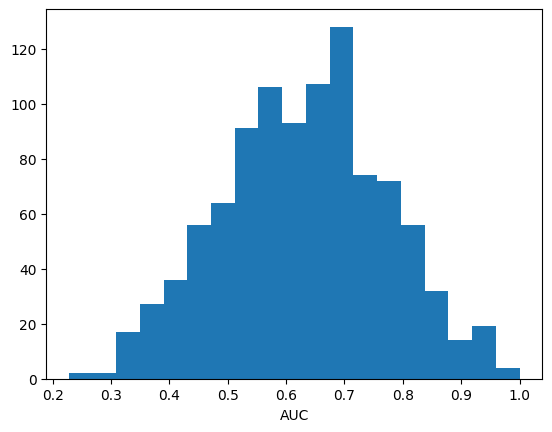

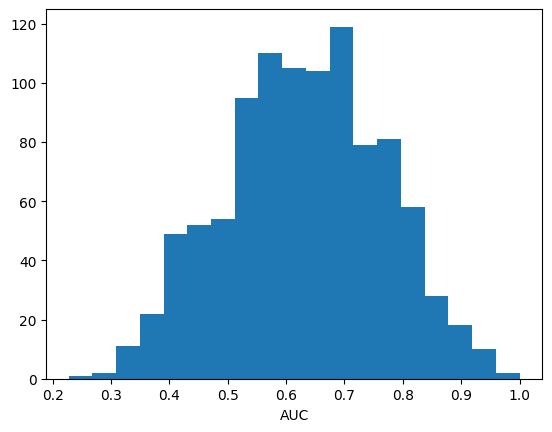

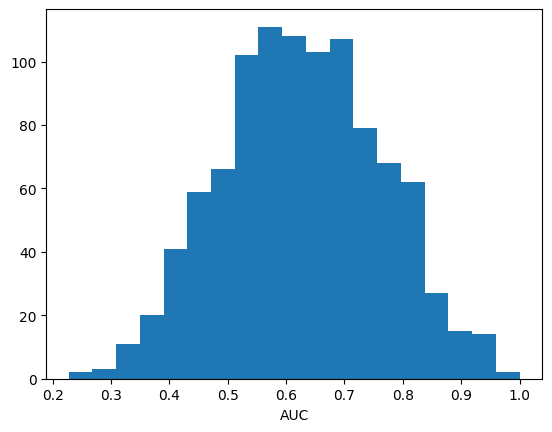

In [ ]:
# NOW WE WANT TO FIND THE OPTIMUM DEPTH OF THE TREE
# THIS WILL TAKE SOME TIME, YOU CAN GO MAKE YOURSELF A SANDWICH (OR REDUCE THE NUMBER OF SEEDS)
for i in range(1,11):
  aucs = DecisionTreeClass(X,y,0.2,1000,i)
  print(i)
  print(np.mean(aucs))
  print('-------')
  plt.figure()
  plt.hist(aucs,bins='auto')
  # plt.title()
  plt.xlabel('AUC')

THE BEST RESULT IS FOR MAX_DEPTH = 4, SO LET'S PLOT ITS ROC CURVE

In [ ]:
def DecisionTreeClass2(X,y,t_s,n_states,m_d):
  aucs = []
  accs = []
  for i in range(n_states):

    train_errors = {}
    test_errors = {}
    val_errors = {}

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_s,random_state=i, stratify=y)

    # Decision Tree training
    dt_model = DecisionTreeClassifier(max_depth=m_d)
    dt_model.fit(X_train, y_train)


    # Train estimations
    preds_dt_train = dt_model.predict(X_train)
    probs_dt_train = dt_model.predict_proba(X_train)
    probs_dt_train = [x[1] for x in probs_dt_train]

    # Test estimations
    preds_dt_test = dt_model.predict(X_test)
    probs_dt_test = dt_model.predict_proba(X_test)
    probs_dt_test = [x[1] for x in probs_dt_test]#

    accuracy_dt_test = accuracy_score(y_test, preds_dt_test)
    precision_dt_test = precision_score(y_test, preds_dt_test)#
    recall_dt_test = recall_score(y_test, preds_dt_test)#
    f1_dt_test = f1_score(y_test, preds_dt_test)#
    auc_dt_test = roc_auc_score(y_test, probs_dt_test)


    aux_error_test = {'accuracy': accuracy_dt_test, 'precision': precision_dt_test, 'recall': recall_dt_test, 'f1': f1_dt_test, 'auc': auc_dt_test}




    dt_fpr_test, dt_tpr_test, dt_threshold_test = roc_curve(y_test, probs_dt_test)
    dt_roc_auc_test = auc(dt_fpr_test, dt_tpr_test) # auc: area under curve
    aucs.append(dt_roc_auc_test)
    accs.append(accuracy_score(y_test,preds_dt_test))



  print('ACCURACY:')
  print(np.mean(accs))
  print(np.sqrt(np.var(accs)))
  print('-----')
  print('AUC:')
  print(np.mean(aucs))
  print(np.sqrt(np.var(aucs)))
  plt.hist(aucs,bins='auto')
  plt.xlabel('AUC')

  plt.figure()
  plt.title('Receiver Operating Characteristic')
  plt.plot(dt_fpr_test, dt_tpr_test, 'b', label = 'AUC = %0.2f' % dt_roc_auc_test)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

ACCURACY:
0.7192333333333333
0.11799374277195099
-----
AUC:
0.6714022727272728
0.1560843520456564


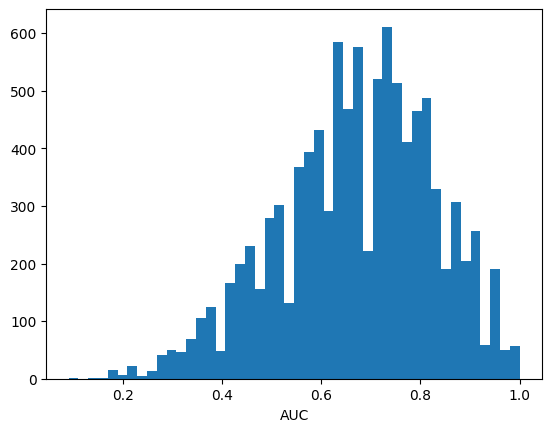

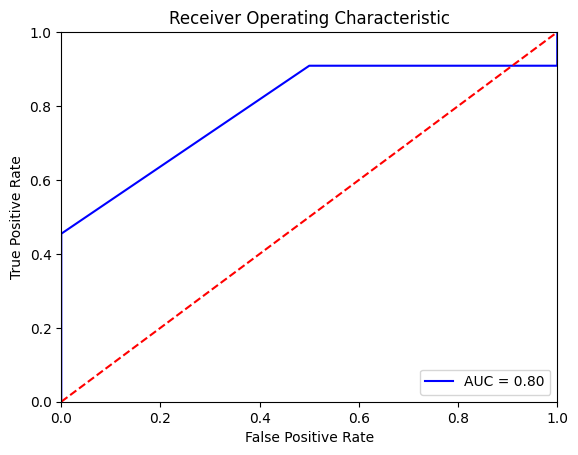

In [ ]:
DecisionTreeClass2(X,y,0.2,10000,4)

FOR 10'000 SEEDS, WE OBTAIN AN AUC OF $0.67 \pm 0.16$ \
AND AN ACCURACY OF $0.72 \pm 0.12$ \
TO COMPARE WITH LOGISTIC REGRESSION, THE MEAN IS THE SAME. BUT FOR SOME SEEDS WE MAY OBTAIN MUCH HIGHER ACCURACIES THAN WITH LOG REG, HOWEVER THE RISK IS HIGHER

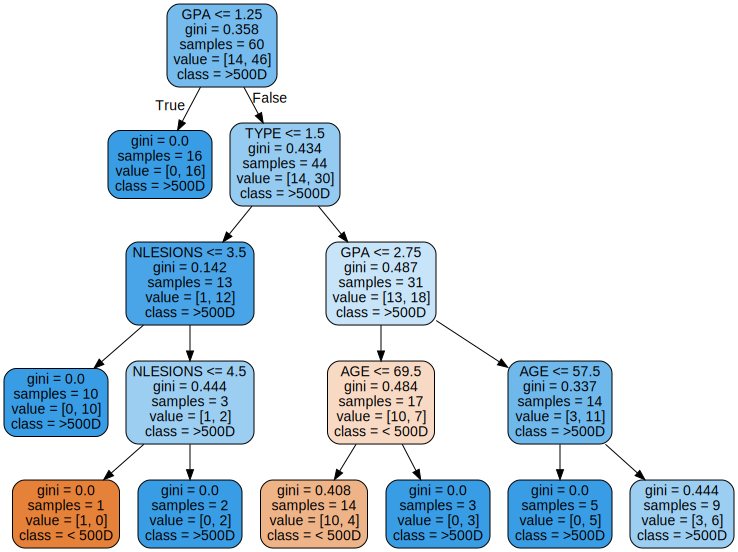

In [ ]:
# Visualize the tree by graphiz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=4999, stratify=y)

# Decision Tree training
dt_model = DecisionTreeClassifier(max_depth=4)
dt_model.fit(X_train, y_train)

feature_names = ['SEX','AGE', 'GPA', 'NLESIONS', 'TYPE']
class_names = ['< 500D','>500D']
dot_data = tree.export_graphviz(dt_model, out_file=None, filled=True, rounded = True, feature_names=feature_names,class_names=class_names)
graph = graphviz.Source(dot_data)
graph

### RANDOM FOREST

In [ ]:
# A FUNCTION THAT CALCS THE MEAN ACCURACY FOR 5000 DIFFERENT SEEDS, RANDOM FOREST MULTI CLASS (2 CLASSES)

def Random_Tree_2C(X, y, test_size = 0.2,ne = 10,md=5,nr=5000):
  rtm_acc = []
  for i in range(nr):
    factor = pd.factorize(y)
    definitions = factor[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = i)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    classifier = RandomForestClassifier(n_estimators = ne, random_state = i,max_depth=md)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
    reversefactor = dict(zip(range(2),definitions))

    y_test = np.vectorize(reversefactor.get)(y_test)
    y_pred = np.vectorize(reversefactor.get)(y_pred)

    accuracy = accuracy_score(y_test,y_pred)
    # print(accuracy)
    rtm_acc.append(accuracy)

  print(np.mean(rtm_acc))
  print(np.sqrt(np.var(rtm_acc)))
  plt.hist(rtm_acc,bins='auto')
  plt.title('ACCURACY')



0.6953733333333334
0.08425315397986925


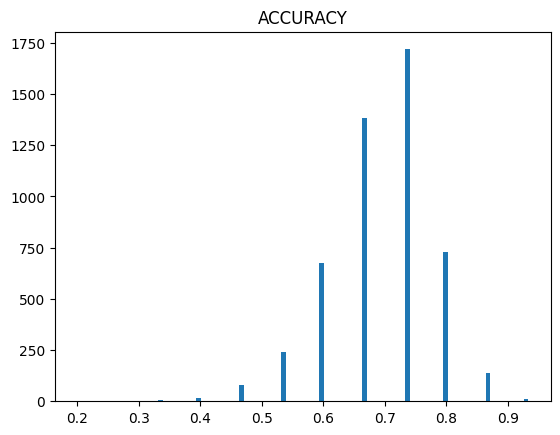

In [ ]:
Random_Tree_2C(X, y)

In [ ]:
# A FUNCTION WE'LL USE TO OPTOMIZE THE NUMBER OF ESTIMATORS AND MAX DEPTH
def Random_Tree_2C2(X, y, test_size = 0.2,ne = 10,md=5,nr=5000):
  rtm_acc = []
  for i in range(nr):
    factor = pd.factorize(y)
    definitions = factor[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = i)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    classifier = RandomForestClassifier(n_estimators = ne, random_state = i,max_depth=md)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    #Reverse factorize (converting y_pred from 0s,1s and 2s to ...)
    reversefactor = dict(zip(range(2),definitions))

    y_test = np.vectorize(reversefactor.get)(y_test)
    y_pred = np.vectorize(reversefactor.get)(y_pred)

    accuracy = accuracy_score(y_test,y_pred)
    # print(accuracy)
    rtm_acc.append(accuracy)
  return np.mean(rtm_acc)

In [ ]:
# NOW WE WANT TO OPTIMIZE MAX DEPTH AND N ESTIMATORS



def Optimize_RT(X, y, test_size,max_ne,max_md,nr):
  rt_matrix = np.zeros((max_ne-1,max_md-1))

  for i in range(1,max_ne):
    for j in range(1,max_md):
      rt_matrix[i-1,j-1] = Random_Tree_2C2(X,y,test_size=test_size,ne = i, md = j, nr = nr)
  return rt_matrix



Text(0.5, 1.0, 'MEAN ACCURACY')

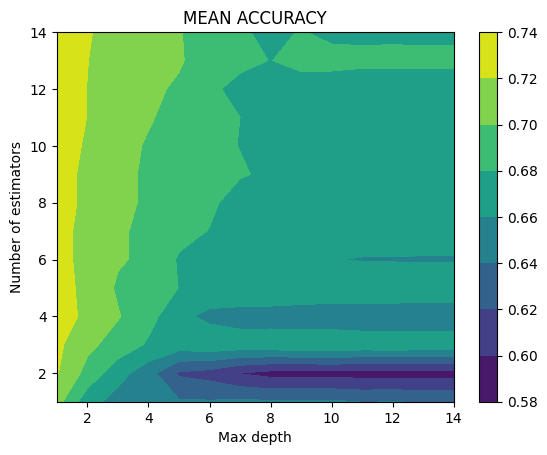

In [ ]:
# YOU MIGHT WANT TO TAKE A REST WHILE THIS WORKS
mne = 15
mmd = 15
nr0 = 200
matriz = Optimize_RT(X,y,test_size = 0.2, max_ne = mne,max_md = mmd, nr=nr0)
plt.contourf(range(1,mmd),range(1,mne),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN ACCURACY')

Text(0.5, 1.0, 'MEAN ACCURACY')

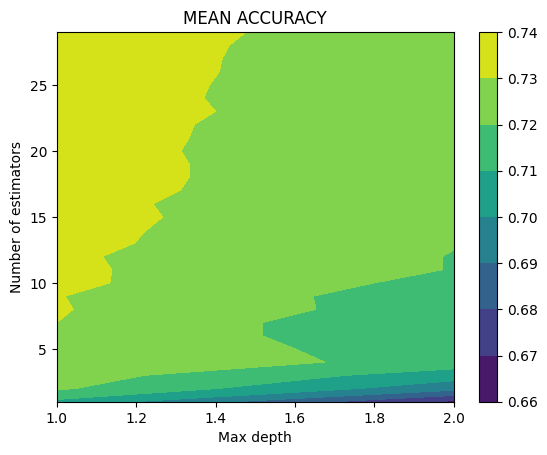

In [ ]:
mne = 30
mmd = 3
nr0 = 200
matriz = Optimize_RT(X,y,test_size = 0.2, max_ne = mne,max_md = mmd, nr=nr0)
plt.contourf(range(1,mmd),range(1,mne),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN ACCURACY')

In [ ]:
# TAKES TOO LONG
# mne = 20
# mmd = 3
# nr0 = 2000
# matriz = Optimize_RT(X,y,test_size = 0.2, max_ne = mne,max_md = mmd, nr=nr0)
# plt.contourf(range(1,mmd),range(1,mne),matriz)
# plt.colorbar()
# plt.xlabel('Max depth')
# plt.ylabel('Number of estimators')
# plt.title('MEAN ACCURACY')

0.7274666666666666
0.025910615585122636


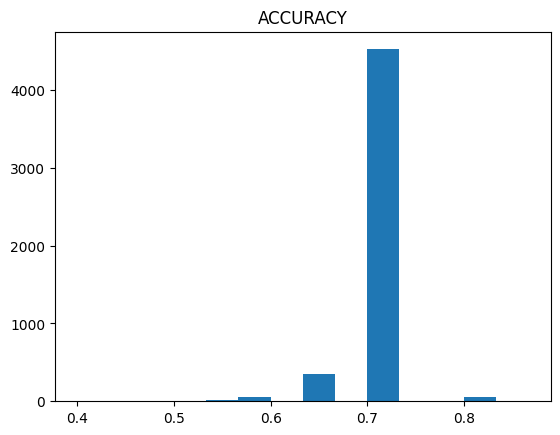

In [ ]:
# SO LET'S TRY AGAIN
Random_Tree_2C(X, y,test_size=0.2,ne = 15,md = 2, nr = 5000)

FOR RANDOM FOREST AND 5000 SEEDS, WE OBTAIN AN ACCURACY OF $ 0.73 \pm 0.03$. THIS IS MUCH BETTER THAN THE PREVIOUS ONE DUE TO THE REDUCED UNCERTAINTY

### XBG

In [ ]:
# A FIRST TRY
train_errors = {}
test_errors = {}
val_errors = {}
# Split train-test


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Model training
xgb_model = xgb.XGBClassifier(n_estimators=500, eval_metric= 'auc', seed= 123, booster= 'gbtree', eta= 0.2, gamma= 0, max_depth=3, scale_pos_weight=2,  objective="binary:logistic")

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=20,
              verbose=True)

# Train estimations
preds_xgb_train = xgb_model.predict(X_train)
probs_xgb_train = xgb_model.predict_proba(X_train)
probs_xgb_train = [x[1] for x in probs_xgb_train]

accuracy_xgb_train = accuracy_score(y_train, preds_xgb_train)
precision_xgb_train = precision_score(y_train, preds_xgb_train)
recall_xgb_train = recall_score(y_train, preds_xgb_train)
f1_xgb_train = f1_score(y_train, preds_xgb_train)
auc_xgb_train = roc_auc_score(y_train, probs_xgb_train)

# Test estimations
preds_xgb_test = xgb_model.predict(X_test)
probs_xgb_test = xgb_model.predict_proba(X_test)
probs_xgb_test = [x[1] for x in probs_xgb_test]

accuracy_xgb_test = accuracy_score(y_test, preds_xgb_test)
precision_xgb_test = precision_score(y_test, preds_xgb_test)
recall_xgb_test = recall_score(y_test, preds_xgb_test)
f1_xgb_test = f1_score(y_test, preds_xgb_test)
auc_xgb_test = roc_auc_score(y_test, probs_xgb_test)


aux_error_train = {'accuracy': accuracy_xgb_train, 'precision': precision_xgb_train, 'recall': recall_xgb_train, 'f1': f1_xgb_train, 'auc': auc_xgb_train}
aux_error_test = {'accuracy': accuracy_xgb_test, 'precision': precision_xgb_test, 'recall': recall_xgb_test, 'f1': f1_xgb_test, 'auc': auc_xgb_test}

train_errors['xgb'] = aux_error_train
test_errors['xgb'] = aux_error_test

[0]	validation_0-auc:0.86491	validation_1-auc:0.65909
[1]	validation_0-auc:0.86491	validation_1-auc:0.65909
[2]	validation_0-auc:0.88820	validation_1-auc:0.70455
[3]	validation_0-auc:0.88820	validation_1-auc:0.70455
[4]	validation_0-auc:0.87578	validation_1-auc:0.70455
[5]	validation_0-auc:0.90994	validation_1-auc:0.72727
[6]	validation_0-auc:0.93168	validation_1-auc:0.59091
[7]	validation_0-auc:0.94720	validation_1-auc:0.72727
[8]	validation_0-auc:0.94410	validation_1-auc:0.72727
[9]	validation_0-auc:0.95885	validation_1-auc:0.70455
[10]	validation_0-auc:0.96506	validation_1-auc:0.72727
[11]	validation_0-auc:0.96506	validation_1-auc:0.72727
[12]	validation_0-auc:0.96739	validation_1-auc:0.65909
[13]	validation_0-auc:0.97127	validation_1-auc:0.68182
[14]	validation_0-auc:0.97671	validation_1-auc:0.68182
[15]	validation_0-auc:0.97671	validation_1-auc:0.68182
[16]	validation_0-auc:0.98370	validation_1-auc:0.59091
[17]	validation_0-auc:0.98680	validation_1-auc:0.61364
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


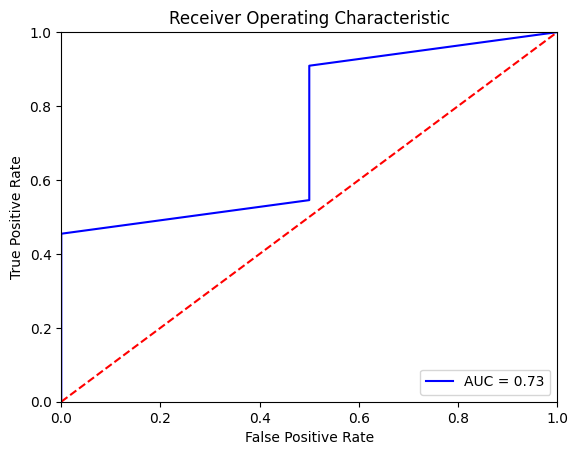

In [ ]:
xgb_fpr_test, xgb_tpr_test, xgb_threshold_test = roc_curve(y_test, probs_xgb_test)
xgb_roc_auc_test = auc(xgb_fpr_test, xgb_tpr_test)

plt.title('Receiver Operating Characteristic')
plt.plot(xgb_fpr_test, xgb_tpr_test, 'b', label = 'AUC = %0.2f' % xgb_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ALRIGHT, NOT BAD.

In [ ]:
# WE DEFINE A FUNCTION WHICH CALCS THE ACCURACY AND AUC FOR 5000 SEEDS, WE'LL USE IT TO OPTIMIZE THE PARAMETERS

def XGB_2C(X,y,ts = 0.2,ne = 10, md = 5, nr = 5000):
  xgb2c_acc = []
  xgb2c_auc = []
  for i in range(nr):
    # Split train-test


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=i, stratify=y)

    # Model training
    xgb_model = xgb.XGBClassifier(n_estimators=ne, eval_metric= 'auc', seed= i, booster= 'gbtree', eta= 0.2, gamma= 0, max_depth=md, scale_pos_weight=2,  objective="binary:logistic")

    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  early_stopping_rounds=20,
                  verbose=False)

    # Train estimations
    preds_xgb_train = xgb_model.predict(X_train)
    probs_xgb_train = xgb_model.predict_proba(X_train)
    probs_xgb_train = [x[1] for x in probs_xgb_train]

    # Test estimations
    preds_xgb_test = xgb_model.predict(X_test)
    probs_xgb_test = xgb_model.predict_proba(X_test)
    probs_xgb_test = [x[1] for x in probs_xgb_test]

    accuracy_xgb_test = accuracy_score(y_test, preds_xgb_test)
    auc_xgb_test = roc_auc_score(y_test, probs_xgb_test)
    xgb2c_acc.append(accuracy_xgb_test)
    xgb2c_auc.append(auc_xgb_test)

  return xgb2c_acc, xgb2c_auc



In [ ]:
accs,aucs = XGB_2C(X,y,ts = 0.2,ne = 10, md = 5, nr = 5000)

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with s

0.7302799999999999
0.024376888872682488


(array([3.000e+00, 0.000e+00, 6.000e+00, 0.000e+00, 4.100e+01, 0.000e+00,
        2.550e+02, 0.000e+00, 0.000e+00, 4.567e+03, 0.000e+00, 1.180e+02,
        0.000e+00, 1.000e+01]),
 array([0.46666667, 0.4952381 , 0.52380952, 0.55238095, 0.58095238,
        0.60952381, 0.63809524, 0.66666667, 0.6952381 , 0.72380952,
        0.75238095, 0.78095238, 0.80952381, 0.83809524, 0.86666667]),
 <BarContainer object of 14 artists>)

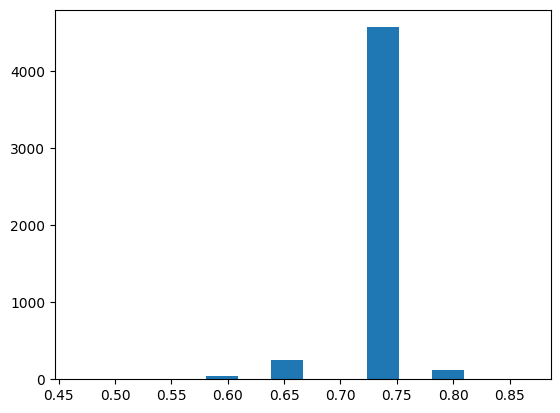

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

0.7716727272727273
0.14913896647863045


(array([  2.,   0.,   1.,   6.,   2.,   4.,   5.,  12.,  10.,  13.,  25.,
         27.,  36.,  41.,  56.,  77.,  93., 108., 164., 110., 128., 130.,
        153., 167., 182., 198., 244., 258., 321., 327., 400., 412., 316.,
        354., 222., 211., 185.]),
 array([0.13636364, 0.15970516, 0.18304668, 0.20638821, 0.22972973,
        0.25307125, 0.27641278, 0.2997543 , 0.32309582, 0.34643735,
        0.36977887, 0.39312039, 0.41646192, 0.43980344, 0.46314496,
        0.48648649, 0.50982801, 0.53316953, 0.55651106, 0.57985258,
        0.6031941 , 0.62653563, 0.64987715, 0.67321867, 0.6965602 ,
        0.71990172, 0.74324324, 0.76658477, 0.78992629, 0.81326781,
        0.83660934, 0.85995086, 0.88329238, 0.90663391, 0.92997543,
        0.95331695, 0.97665848, 1.        ]),
 <BarContainer object of 37 artists>)

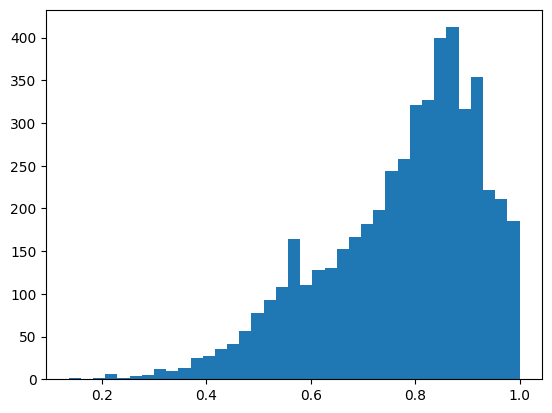

In [ ]:
print(np.mean(aucs))
print(np.sqrt(np.var(aucs)))
plt.hist(aucs,bins='auto')

SO FOR XGB, N_ESTIMATORS = 3, MAX_DEPTH = 5, WE OBTAIN AN ACCURACY OF $0.73 \pm 0.02$ AND AN AUC OF $0.77 \pm 0.15$

 NOW WE WANT TO OPTIMIZE THE PARAMETERS MAX_DEPTH AND N_ESTIMATORS

In [ ]:

def Optimize_XGB(X,y,test_size,max_ne,max_md,nr):
  xgb_acc_matrix = np.zeros((max_ne-1,max_md-1))
  xgb_auc_matrix = np.zeros((max_ne-1,max_md-1))
  for i in range(1,max_ne):
    for j in range(1,max_md):
      accs, aucs = XGB_2C(X,y,ts = test_size,ne = i, md = j, nr = nr)
      xgb_acc_matrix[i-1,j-1] = np.mean(accs)
      xgb_auc_matrix[i-1,j-1] = np.mean(aucs)
  return xgb_acc_matrix,xgb_auc_matrix


In [ ]:
# THIS'LL TAKE A BIT
mne = 10
mmd = 10
nr0 = 500
matriz_acc, matriz_auc = Optimize_XGB(X,y,test_size=0.2,max_ne=mne,max_md = mmd, nr = nr0)

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with s

Text(0.5, 1.0, 'MEAN ACCURACY')

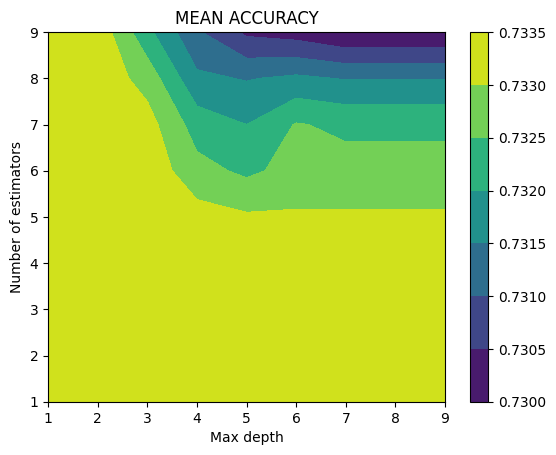

In [ ]:
plt.contourf(range(1,mmd),range(1,mne),matriz_acc)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN ACCURACY')

Text(0.5, 1.0, 'MEAN AUC')

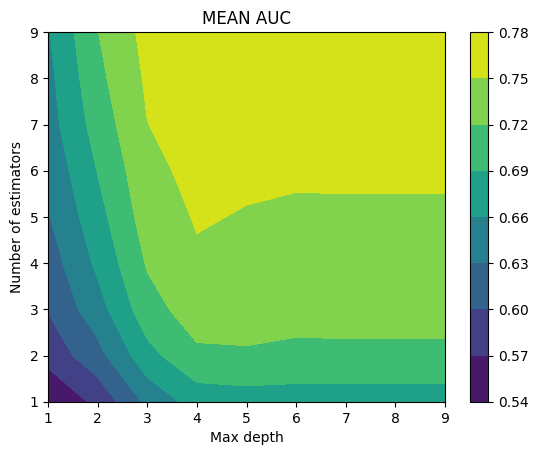

In [ ]:
plt.contourf(range(1,mmd),range(1,mne),matriz_auc)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN AUC')

In [ ]:
# SO LET'S TRY WITH 4,4

accs,aucs = XGB_2C(X,y,ts = 0.2,ne = 4, md = 4, nr = 10000)

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with s

0.7333199999999997
0.0013332666649999167
-----------
0.7487238636363638
0.16430737135553758


Text(0.5, 0, 'AUC')

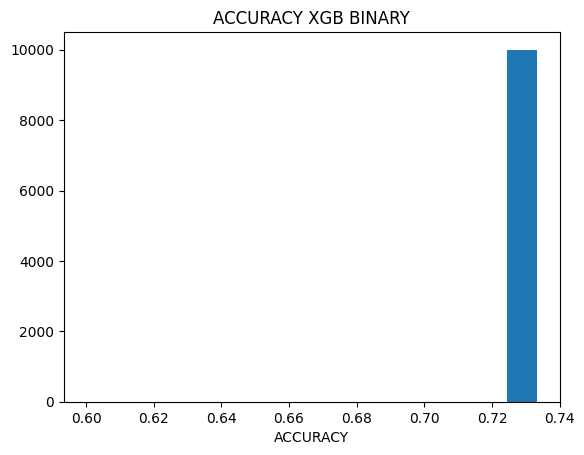

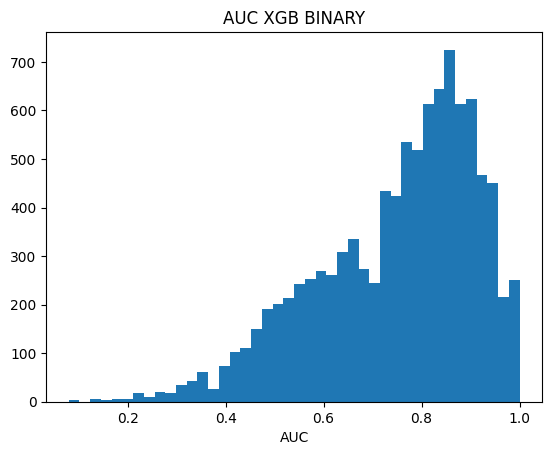

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
print('-----------')

print(np.mean(aucs))
print(np.sqrt(np.var(aucs)))
plt.figure()
plt.title('ACCURACY XGB BINARY')
plt.hist(accs,bins='auto')
plt.xlabel('ACCURACY')

plt.figure()
plt.title('AUC XGB BINARY')
plt.hist(aucs,bins='auto')
plt.xlabel('AUC')

WE OBTAIN, FOR 10'000 DIFFERENT SEEDS, XGBOOST MAX DEPTH = 4, ESTIMATORS = 4 : ACCURACY $0.733 \pm 0.001$ AND AUC $0.75 \pm 0.16 $

### -NN

Epoch 1/3
1/1 [==============================] - 3s 3s/step - loss: 0.6891 - accuracy: 0.7593 - val_loss: 0.6886 - val_accuracy: 0.6667
Epoch 2/3
1/1 [==============================] - 0s 33ms/step - loss: 0.6855 - accuracy: 0.7593 - val_loss: 0.6862 - val_accuracy: 0.6667
Epoch 3/3
1/1 [==============================] - 0s 25ms/step - loss: 0.6777 - accuracy: 0.8000
Test Accuracy: 0.800000011920929
1/1 [==============================] - 0s 80ms/step


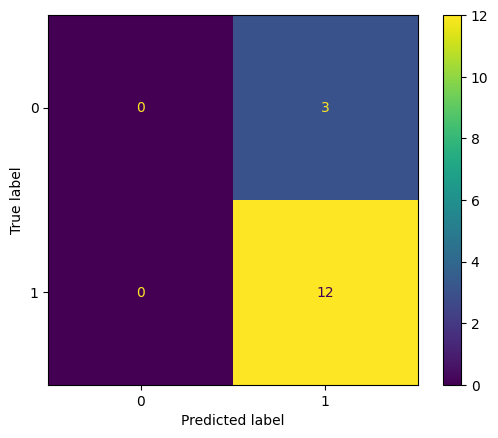

In [ ]:
# Normalize the data if needed
X = X / 255.0 if X.max().max() > 1 else X



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

# Check the shape of your input data
input_shape = X_train.shape[1]

# Build the model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Output the accuracy
print(f'Test Accuracy: {test_accuracy}')


y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

In [ ]:
def NN_2C(X,y,test_size,nr,epochs):
  accs =[]
  for i in range(nr):
    X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=i)

    # Check the shape of your input data
    input_shape = X_train.shape[1]

    # Build the model
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split=0.1)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accs.append(test_accuracy)

  return accs

In [ ]:
accs = NN_2C(X,y,test_size=0.2,nr = 1000,epochs=5)

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 4/5
1/1 [==============================] - 0s 33ms/step - loss: 0.6944 - accuracy: 0.3704 - val_loss: 0.6878 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 0.6870 - accuracy: 0.8667
Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.6927 - accuracy: 0.6667 - val_loss: 0.6854 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 0s 34ms/step - loss: 0.6899 - accuracy: 0.7037 - val_loss: 0.6781 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 33ms/step - loss: 0.6869 - accuracy: 0.7037 - val_loss: 0.6707 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 34ms/step - loss: 0.6840 - accuracy: 0.7037 - val_loss: 0.6633 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 26ms/step - loss: 0.6662 - accuracy: 0.8667
Epoch 1/5
1/1 [==============================] - 1s 1s/step

0.7477333472445608
0.12905371475638397


(array([  1.,   0.,   4.,   0.,   0.,   6.,   0.,   5.,   0.,   0.,   6.,
          0.,   3.,   0.,   0.,   7.,   0.,   0.,  20.,   0.,  81.,   0.,
          0., 169.,   0., 216.,   0.,   0., 236.,   0., 164.,   0.,   0.,
         77.,   0.,   5.]),
 array([0.06666667, 0.0925926 , 0.11851852, 0.14444445, 0.17037037,
        0.1962963 , 0.22222223, 0.24814815, 0.27407408, 0.3       ,
        0.32592593, 0.35185185, 0.37777778, 0.40370371, 0.42962963,
        0.45555556, 0.48148148, 0.50740741, 0.53333334, 0.55925926,
        0.58518519, 0.61111111, 0.63703704, 0.66296296, 0.68888889,
        0.71481482, 0.74074074, 0.76666667, 0.79259259, 0.81851852,
        0.84444445, 0.87037037, 0.8962963 , 0.92222222, 0.94814815,
        0.97407407, 1.        ]),
 <BarContainer object of 36 artists>)

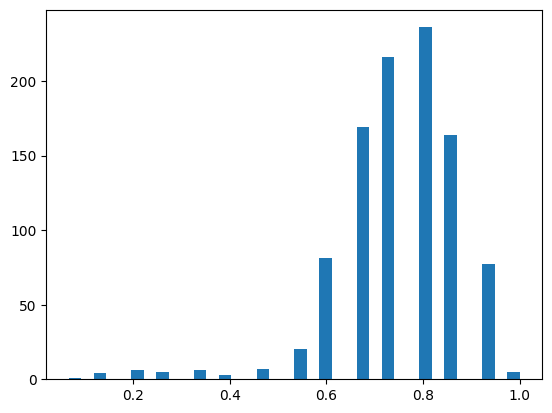

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

WE OBTAIN, FOR A NN, 5 EPOCHS AND 1000 SEEDS, AN ACCURACY OF $0.75 \pm 0.12 $. HIGHER UNCERTAINTY THAN PREVIOUSLY

## MULTICLASS: X<500D, 500D< X <1500D, X>1500D

(array([18.,  0.,  0.,  0., 30.,  0.,  0., 27.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 <BarContainer object of 8 artists>)

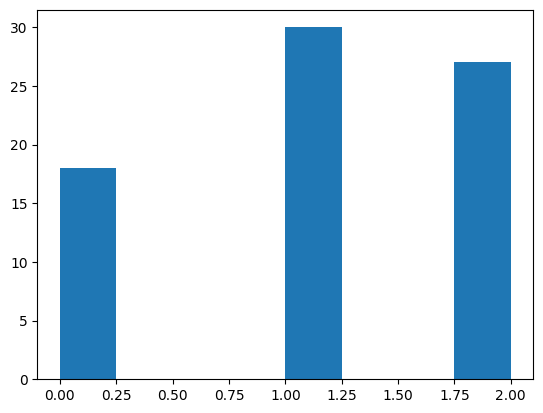

In [ ]:
df_deaths = pd.DataFrame()
df_deaths['SEX'] = sex_array
df_deaths['AGE'] = age_array
df_deaths['DAYSTODEATH']=death_array
df_deaths['GPA']=gpa_array
df_deaths['NLESIONS']=nlesions
df_deaths['TYPE']=type_array

media_gpa = int(np.mean(df_deaths.GPA))

df_deaths = df_deaths.fillna(media_gpa)


X = df_deaths.drop(['DAYSTODEATH'],axis=1)
y =  df_deaths['DAYSTODEATH']


yy =[]

for i in y:
  if i<500:
    yy.append(0)
  elif i>500 and i<1000:
    yy.append(1)
  elif i>1000:
    yy.append(2)
y = pd.DataFrame(yy)[0]
plt.hist(y,bins='auto')

### LOGISTIC REGRESSION

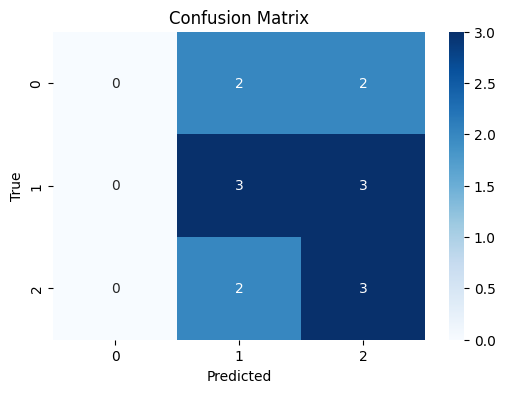

THE ACCURACY IS 0.4


In [ ]:
# A FIRST EXAMPLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=.20, stratify=y, random_state=1)


logreg = LogisticRegression(solver="liblinear", max_iter=1000) #class_weight='balanced')
logreg.fit(xtrain, ytrain)


# Create the confusion matrix from true values and predictions on test dataset
predictions = logreg.predict(xtest)
cm = confusion_matrix(ytest, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('THE ACCURACY IS '+str(accuracy_score(ytest,predictions)))

In [ ]:
# LET'S CALC THE ACCURACY FOR MANY SEEDS
def LogRegMC(X,y,n_states):
  acc = []
  for i in range(n_states):
    xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, stratify=y, random_state=i)


    logreg = LogisticRegression(solver="liblinear", max_iter=1000) #class_weight='balanced')
    logreg.fit(xtrain, ytrain)


    # Create the confusion matrix from true values and predictions on test dataset
    predictions = logreg.predict(xtest)
    acc.append(accuracy_score(ytest,predictions))


  print(np.mean(acc))
  print(np.sqrt(np.var(acc)))
  plt.hist(acc,bins='auto')
  plt.xlabel('Accuracy')

0.3639733333333333
0.09318483042975516


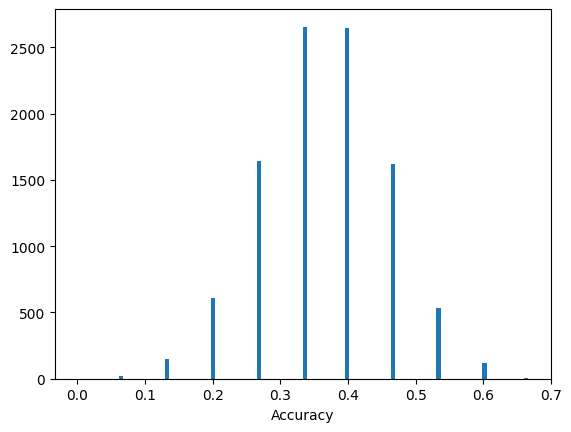

In [ ]:
LogRegMC(X,y,10000)

NOT REALLY GOOD RESULT: AN ACCURACY OF $0.36 \pm 0.09 $ FOR 10'000 SEEDS (0.33 IS RANDOM)

### DECISION TREE CLASSIFIER

Accuracy: 0.40
Confusion Matrix: 
 [[0 2 2]
 [0 4 2]
 [1 2 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      0.67      0.57         6
           2       0.33      0.40      0.36         5

    accuracy                           0.40        15
   macro avg       0.28      0.36      0.31        15
weighted avg       0.31      0.40      0.35        15



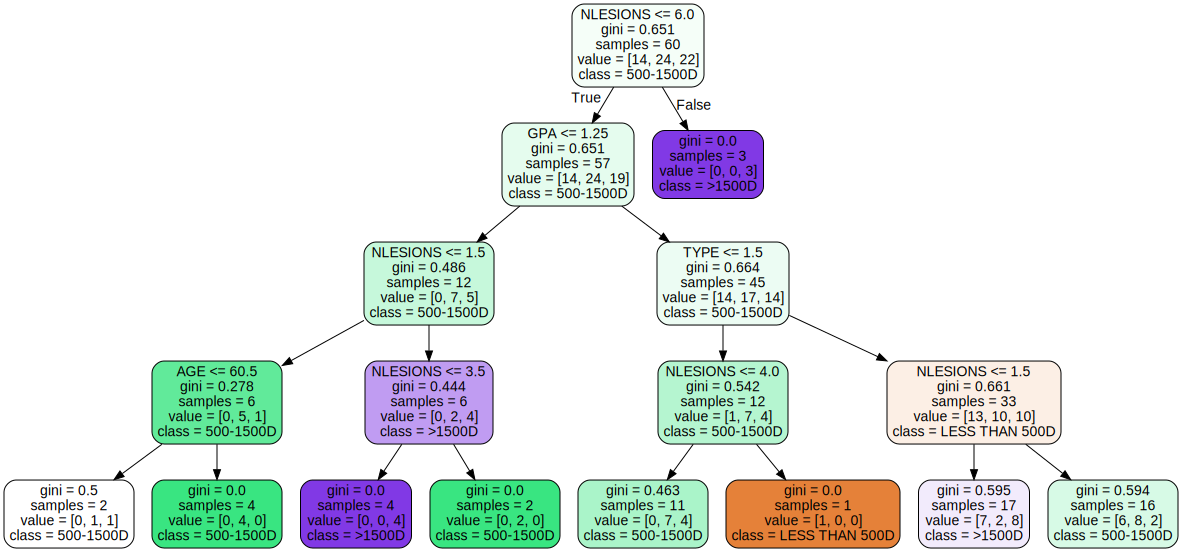

In [ ]:
#AN EXAMPLE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

classifier = DecisionTreeClassifier(max_depth=4, random_state=42)
classifier.fit(X_train, y_train)

y_pred_test =classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_test,y_pred_test)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred_test))

# Visualize the tree by graphiz
feature_names = ['SEX','AGE', 'GPA', 'NLESIONS', 'TYPE']
class_names = ['LESS THAN 500D','500-1500D','>1500D']
dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True, feature_names=feature_names,class_names=class_names)
graph = graphviz.Source(dot_data)
graph

2
-----------
0.35571333333333344
0.09056380218755541
-----------
3
-----------
0.35391999999999996
0.09085379121301311
-----------
4
-----------
0.37018
0.10509726098555883
-----------
5
-----------
0.3790733333333333
0.11301851942639018
-----------
6
-----------
0.38116000000000005
0.11751760605685146
-----------
7
-----------
0.37924666666666673
0.11885738064307716
-----------
8
-----------
0.37346666666666667
0.1189023128454615
-----------
9
-----------
0.3694866666666667
0.11902587412454113
-----------
10
-----------
0.3685933333333334
0.11853859737092669
-----------
11
-----------
0.3675133333333333
0.11868611657083852
-----------
12
-----------
0.36689333333333335
0.11884608982489356
-----------
13
-----------
0.36690666666666666
0.11899182119419431
-----------
14
-----------
0.36665333333333333
0.11887995737998339
-----------


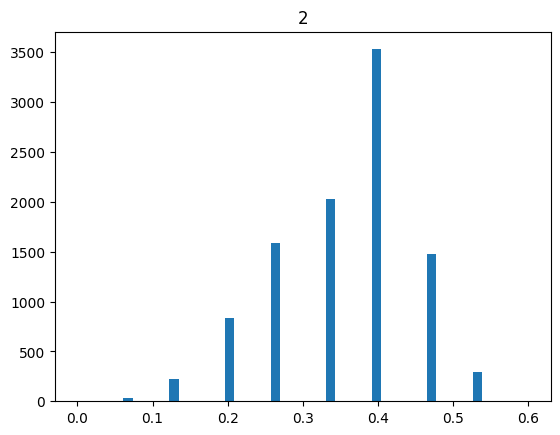

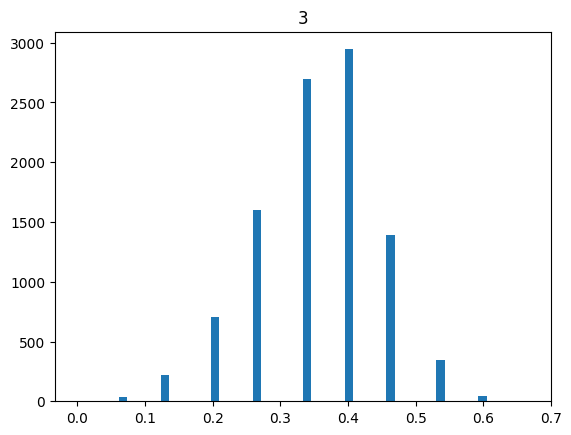

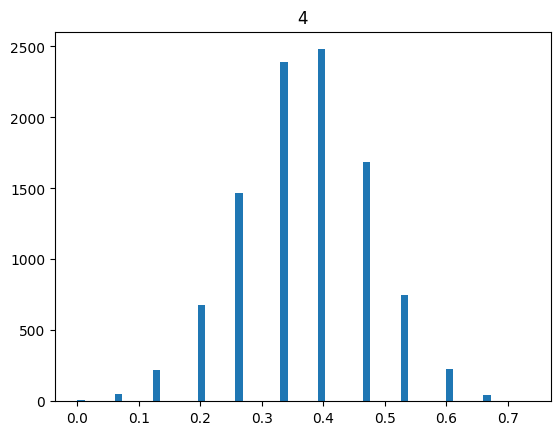

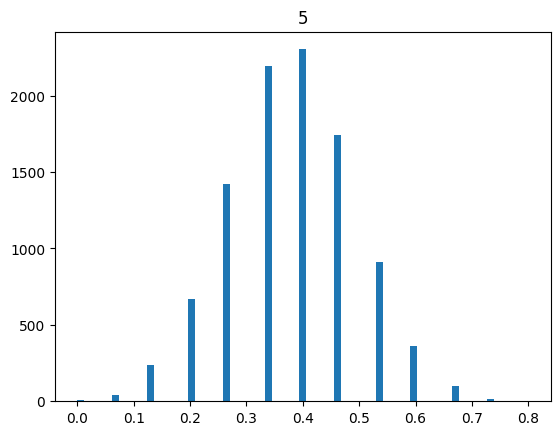

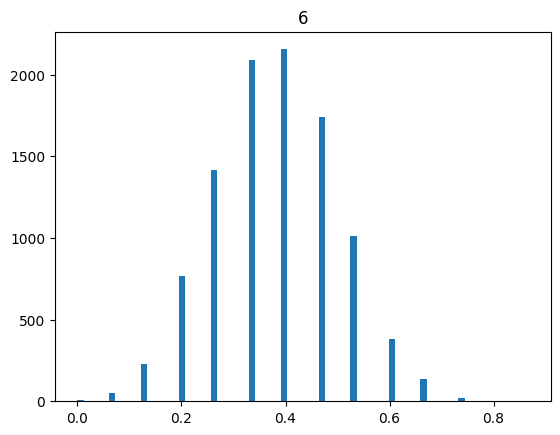

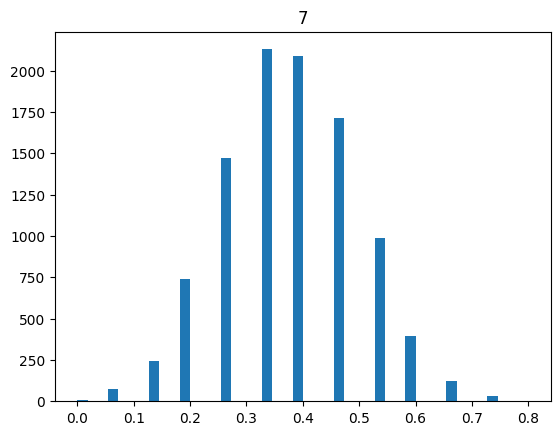

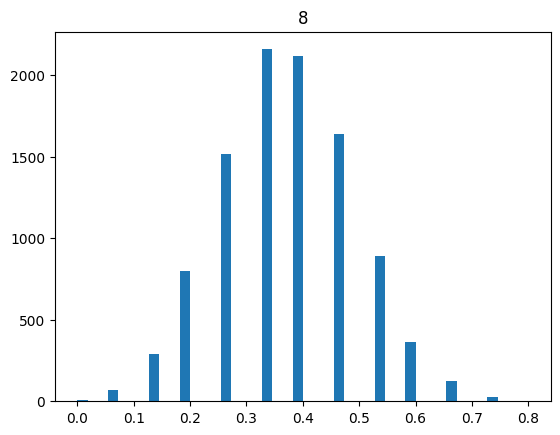

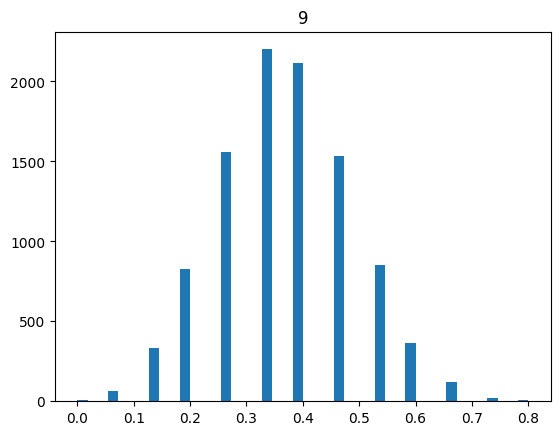

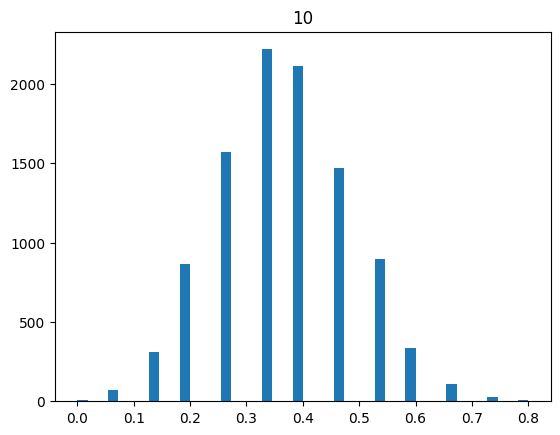

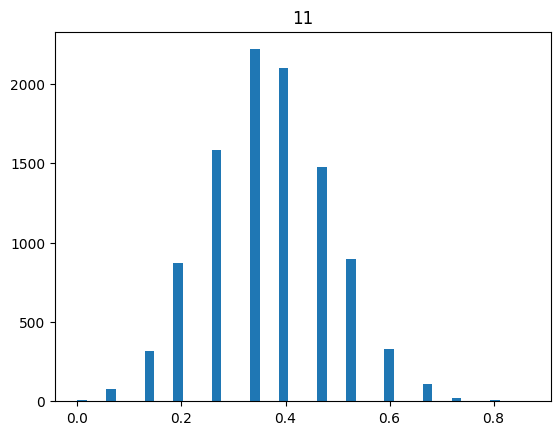

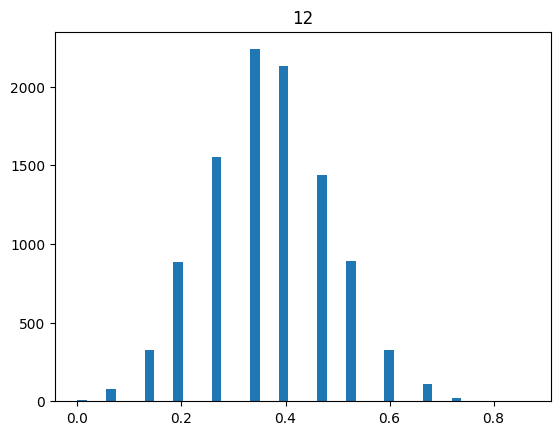

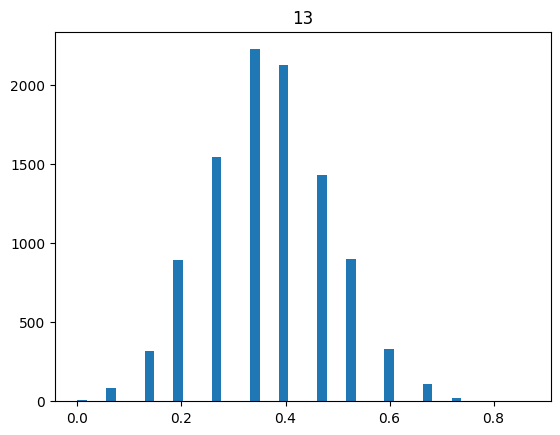

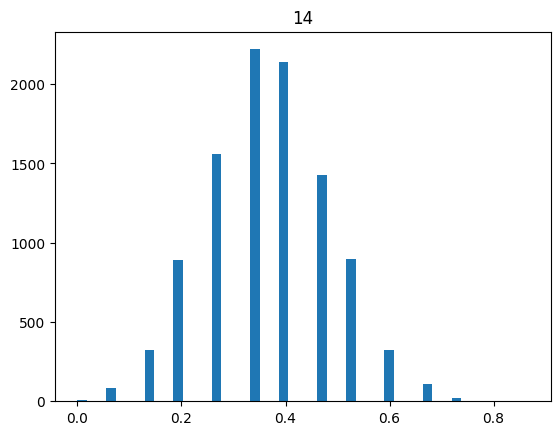

In [ ]:
#OPTIMIZE DEPTH TREE

for j in range(2,15):
  acc = []
  for i in range(10000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = i)

    classifier = DecisionTreeClassifier(max_depth=j, random_state=i)
    classifier.fit(X_train, y_train)

    y_pred_test =classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test)
    cm=confusion_matrix(y_test,y_pred_test)
    acc.append(accuracy)

  print(j)
  print('-----------')
  print(np.mean(acc))
  print(np.sqrt(np.var(acc)))
  print('-----------')
  plt.figure()
  plt.title(j)
  plt.hist(acc,bins='auto')

NO ONE IS GOOD ENOUGH. FOR 10'000 DIFFERENT SEEDS,THE BEST ONE IS MAX_DEPTH=6, WITH MEAN ACCURACY OF 0.38 (0.33 IS COMPLETELY RANDOM)

###RANDOM FOREST

In [ ]:
y.head()

0    2
1    2
2    2
3    2
4    2
Name: 0, dtype: int64

In [ ]:
# A FUNCTION THAT CALCS THE MEAN ACCURACY FOR 5000 DIFFERENT SEEDS, RANDOM FOREST MULTI CLASS

def Random_Tree_MC(X, y, test_size = 0.2,ne = 10,md=5,nr=5000):
  rtm_acc = []
  for i in range(nr):
    factor = pd.factorize(y)
    definitions = factor[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = i)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    classifier = RandomForestClassifier(n_estimators = ne, random_state = i,max_depth=md)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
    reversefactor = dict(zip(range(3),definitions))

    y_test = np.vectorize(reversefactor.get)(y_test)
    y_pred = np.vectorize(reversefactor.get)(y_pred)

    accuracy = accuracy_score(y_test,y_pred)
    # print(accuracy)
    rtm_acc.append(accuracy)

  print(np.mean(rtm_acc))
  plt.hist(rtm_acc,bins='auto')





0.3750266666666666


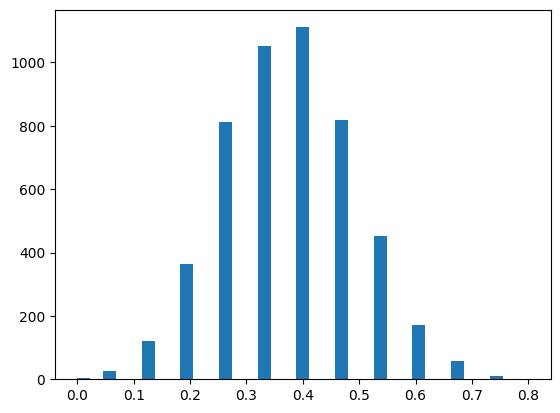

In [ ]:
Random_Tree_MC(X, y)

In [ ]:
# A FUNCTION WE'LL USE TO OPTOMIZE THE NUMBER OF ESTIMATORS AND MAX DEPTH
def Random_Tree_MC2(X, y, test_size = 0.2,ne = 10,md=5,nr=5000):
  rtm_acc = []
  for i in range(nr):
    factor = pd.factorize(y)
    definitions = factor[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = i)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    classifier = RandomForestClassifier(n_estimators = ne, random_state = i,max_depth=md)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    #Reverse factorize (converting y_pred from 0s,1s and 2s to ...)
    reversefactor = dict(zip(range(3),definitions))

    y_test = np.vectorize(reversefactor.get)(y_test)
    y_pred = np.vectorize(reversefactor.get)(y_pred)

    accuracy = accuracy_score(y_test,y_pred)
    # print(accuracy)
    rtm_acc.append(accuracy)
  return np.mean(rtm_acc)

In [ ]:
# NOW WE WANT TO OPTIMIZE MAX DEPTH AND N ESTIMATORS



def Optimize_RTMC(X, y, test_size,max_ne,max_md,nr):
  rt_matrix = np.zeros((max_ne-1,max_md-1))

  for i in range(1,max_ne):
    for j in range(1,max_md):
      rt_matrix[i-1,j-1] = Random_Tree_MC2(X,y,test_size=test_size,ne = i, md = j, nr = nr)
  return rt_matrix



In [ ]:
'''
# IT'LL TAKE TOO LONG, GO TAKE A 2H NAP (OR REDUCE THE NUMBERS)
mne = 15
mmd = 15
nr0 = 2000
matriz = Optimize_RTMC(X,y,test_size = 0.2, max_ne = mne,max_md = mmd, nr=nr0)
plt.contourf(range(1,mmd),range(1,mne),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of estimators')
plt.title('MEAN ACCURACY')
'''
# I TOOK A NAP AND WHEN I GOT UP IT WAS NOT DONE YET, BUT AS I AM A PATIENT PERSON HERE YOU GOT THE RESULT

"\n# IT'LL TAKE TOO LONG, GO TAKE A 2H NAP (OR REDUCE THE NUMBERS)\nmne = 15\nmmd = 15\nnr0 = 2000\nmatriz = Optimize_RTMC(X,y,test_size = 0.2, max_ne = mne,max_md = mmd, nr=nr0)\nplt.contourf(range(1,mmd),range(1,mne),matriz)\nplt.colorbar()\nplt.xlabel('Max depth')\nplt.ylabel('Number of estimators')\nplt.title('MEAN ACCURACY')\n"

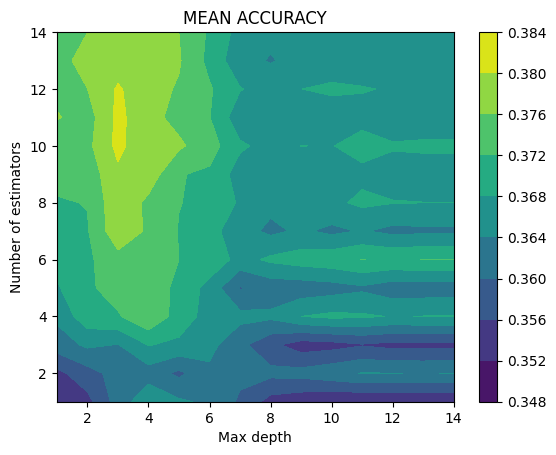

THE BEST MEAN ACCURACY IS 0.38, NOT REALLY GOOD

### XBG

In [ ]:
# A FIRST TRY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)




dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


param = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train)),
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'eta': 0.3,
    'seed': 42
}


num_round = 200


bst = xgb.train(param, dtrain, num_round)

y_pred = bst.predict(dtest)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))



Accuracy: 0.4667
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.60      0.50      0.55         6
           2       0.29      0.40      0.33         5

    accuracy                           0.47        15
   macro avg       0.52      0.47      0.48        15
weighted avg       0.51      0.47      0.48        15



In [ ]:
# A FUNCTION THAT CALCS THE ACCURACY FOR 1000 SEEDS
def XGB_MC(X,y,ts=0.2,md = 5,n_round = 100, nr = 1000 ):
  accs = []
  for i in range(nr):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, stratify=y, random_state = i)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    param = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train)),
    'eval_metric': 'mlogloss',
    'max_depth': md,
    'eta': 0.3,
    'seed': i
    }

    num_round = n_round

    bst = xgb.train(param, dtrain, num_round)

    y_pred = bst.predict(dtest)

    accuracy = accuracy_score(y_test, y_pred)

    accs.append(accuracy)

  return accs


In [ ]:
accs = XGB_MC(X,y)

0.3857333333333334
0.11454652620951308


(array([  2.,   0.,   1.,   0.,   0.,  14.,   0.,  82.,   0.,   0., 128.,
          0., 207.,   0.,   0., 225.,   0., 187.,   0.,   0., 102.,   0.,
         36.,   0.,   0.,  11.,   0.,   5.]),
 array([0.        , 0.02619048, 0.05238095, 0.07857143, 0.1047619 ,
        0.13095238, 0.15714286, 0.18333333, 0.20952381, 0.23571429,
        0.26190476, 0.28809524, 0.31428571, 0.34047619, 0.36666667,
        0.39285714, 0.41904762, 0.4452381 , 0.47142857, 0.49761905,
        0.52380952, 0.55      , 0.57619048, 0.60238095, 0.62857143,
        0.6547619 , 0.68095238, 0.70714286, 0.73333333]),
 <BarContainer object of 28 artists>)

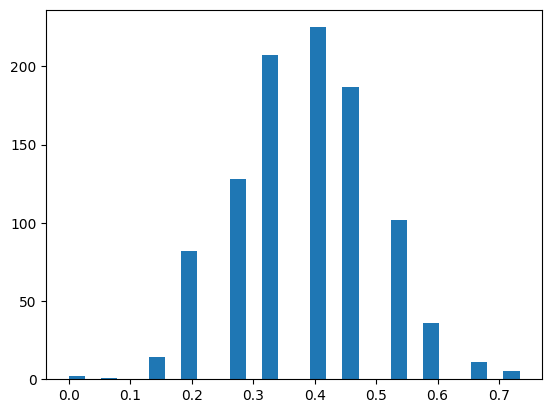

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

In [ ]:
# NOW LET'S OPTIMIZE THIS
def Optimize_XGB_MC(X,y,test_size,max_md,max_nround,nr):
  acc_matrix = np.zeros((max_nround-1,max_md-1))
  for i in range(1,max_nround):
    for j in range(1,max_md):
      accuracies = XGB_MC(X,y,ts=0.2,md = j, n_round = i, nr = nr)
      acc_matrix[i-1,j-1] = np.mean(accuracies)
  return acc_matrix


In [ ]:
mmd = 5
mnr = 10
nr0 = 20

matriz = Optimize_XGB_MC(X,y,test_size = 0.2, max_md = mmd, max_nround = mnr, nr = nr0)

Text(0.5, 1.0, 'MEAN ACCURACY')

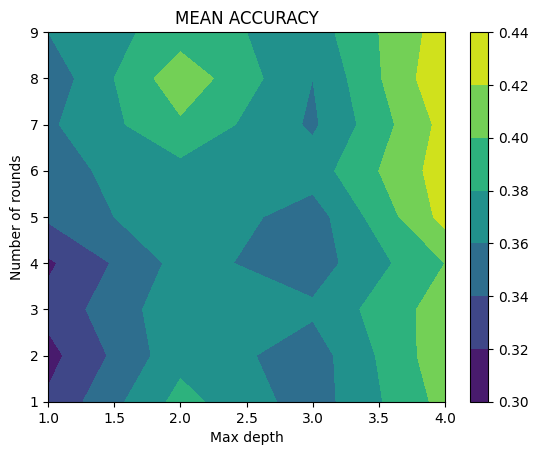

In [ ]:
plt.contourf(range(1,mmd),range(1,mnr),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of rounds')
plt.title('MEAN ACCURACY')

Text(0.5, 1.0, 'MEAN ACCURACY')

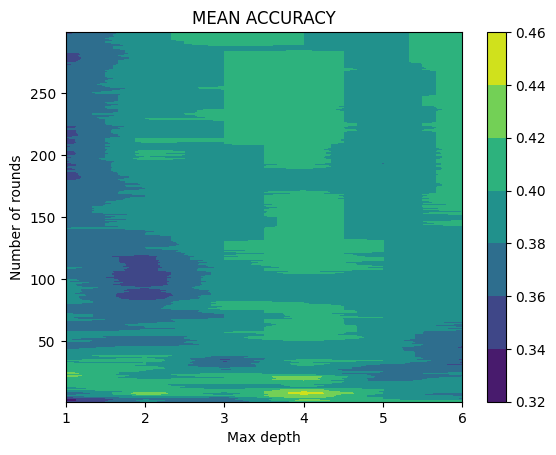

In [ ]:
mmd = 7
mnr = 300
nr0 = 10

matriz = Optimize_XGB_MC(X,y,test_size = 0.2, max_md = mmd, max_nround = mnr, nr = nr0)
plt.contourf(range(1,mmd),range(1,mnr),matriz)
plt.colorbar()
plt.xlabel('Max depth')
plt.ylabel('Number of rounds')
plt.title('MEAN ACCURACY')

In [ ]:
# mmd = 7
# mnr = 200
# nr0 = 1000

# matriz = Optimize_XGB_MC(X,y,test_size = 0.2, max_md = mmd, max_nround = mnr, nr = nr0)
# plt.contourf(range(1,mmd),range(1,mnr),matriz)
# plt.colorbar()
# plt.xlabel('Max depth')
# plt.ylabel('Number of rounds')
# plt.title('MEAN ACCURACY')

 THE BEST WE OBTAIN IS AN ACCURACY OF 0.46, MUCH BETTER. ACCEPTABLE?

### NN

In [ ]:
# Normalize the data if needed
X = X / 255.0 if X.max().max() > 1 else X


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

# Check the shape of your input data
input_shape = X_train.shape[1]

# Determine the number of classes
num_classes = len(np.unique(y))

# Build the model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # For multiclass classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 1.0941 - accuracy: 0.4259 - val_loss: 1.0968 - val_accuracy: 0.3333
Epoch 2/5
1/1 [==============================] - 0s 35ms/step - loss: 1.0923 - accuracy: 0.4259 - val_loss: 1.0968 - val_accuracy: 0.3333
Epoch 3/5
1/1 [==============================] - 0s 33ms/step - loss: 1.0906 - accuracy: 0.4259 - val_loss: 1.0968 - val_accuracy: 0.3333
Epoch 4/5
1/1 [==============================] - 0s 32ms/step - loss: 1.0891 - accuracy: 0.4259 - val_loss: 1.0969 - val_accuracy: 0.3333
Epoch 5/5
1/1 [==============================] - 0s 26ms/step - loss: 1.0883 - accuracy: 0.3333
Test Accuracy: 0.3333333432674408


In [ ]:
def NN_MC(X,y,test_size,nr,epochs=5):
  accs = []
  for i in range(nr):
    X = X / 255.0 if X.max().max() > 1 else X


    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=i)

    # Check the shape of your input data
    input_shape = X_train.shape[1]

    # Determine the number of classes
    num_classes = len(np.unique(y))

    # Build the model
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # For multiclass classification
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split=0.1)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accs.append(test_accuracy)
  return accs

In [ ]:
accs = NN_MC(X,y,test_size=0.2,nr = 500,epochs = 3)

Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 1.0984 - accuracy: 0.3148 - val_loss: 1.0927 - val_accuracy: 0.3333
Epoch 2/3
1/1 [==============================] - 0s 34ms/step - loss: 1.0973 - accuracy: 0.2963 - val_loss: 1.0901 - val_accuracy: 0.5000
Epoch 3/3
1/1 [==============================] - 0s 25ms/step - loss: 1.0972 - accuracy: 0.2667
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 1.1057 - accuracy: 0.2407 - val_loss: 1.1249 - val_accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 34ms/step - loss: 1.1041 - accuracy: 0.2407 - val_loss: 1.1204 - val_accuracy: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 0s 26ms/step - loss: 1.0966 - accuracy: 0.2667
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 1.0967 - accuracy: 0.3889 - val_loss: 1.0971 - val_accuracy: 0.3333
Epoch 2/3
1/1 [==============================] - 0s 35ms/step - loss: 1.0959 - accuracy: 0.3889 - val_loss: 1.0968 -

1/1 [==============================] - 1s 1s/step - loss: 1.0923 - accuracy: 0.3889 - val_loss: 1.0907 - val_accuracy: 0.3333
Epoch 2/3
1/1 [==============================] - 0s 36ms/step - loss: 1.0904 - accuracy: 0.3889 - val_loss: 1.0879 - val_accuracy: 0.3333
Epoch 3/3
1/1 [==============================] - 0s 25ms/step - loss: 1.0977 - accuracy: 0.2667
Epoch 1/3


1/1 [==============================] - 1s 1s/step - loss: 1.1002 - accuracy: 0.3519 - val_loss: 1.0955 - val_accuracy: 0.5000
Epoch 2/3
1/1 [==============================] - 0s 35ms/step - loss: 1.0989 - accuracy: 0.3519 - val_loss: 1.0935 - val_accuracy: 0.5000
Epoch 3/3
1/1 [==============================] - 0s 26ms/step - loss: 1.0921 - accuracy: 0.5333
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 1.0965 - accuracy: 0.3889 - val_loss: 1.0925 - val_accuracy: 0.5000
Epoch 2/3
1/1 [==============================] - 0s 34ms/step - loss: 1.0952 - accuracy: 0.3889 - val_loss: 1.0905 - val_accuracy: 0.5000
Epoch 3/3
1/1 [==============================] - 0s 25ms/step - loss: 1.0979 - accuracy: 0.4000
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 1.0927 - accuracy: 0.4074 - val_loss: 1.0806 - val_accuracy: 0.5000
Epoch 2/3
1/1 [==============================] - 0s 35ms/step - loss: 1.0914 - accuracy: 0.4074 - val_loss: 1.0767 - val_accuracy: 0.5

0.3502666760087013
0.11611266749198357


(array([  1.,   4.,  21.,   0.,  51.,  96.,   0., 112.,  87.,  81.,   0.,
         30.,  15.,   2.]),
 array([0.        , 0.04761905, 0.0952381 , 0.14285715, 0.1904762 ,
        0.23809525, 0.28571429, 0.33333334, 0.38095239, 0.42857144,
        0.47619049, 0.52380954, 0.57142859, 0.61904764, 0.66666669]),
 <BarContainer object of 14 artists>)

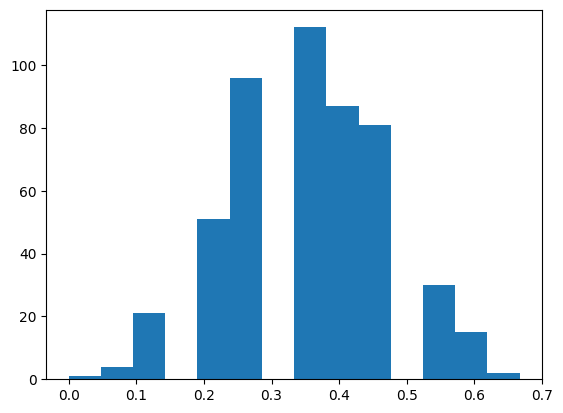

In [ ]:
print(np.mean(accs))
print(np.sqrt(np.var(accs)))
plt.hist(accs,bins='auto')

ACCURACY OF $0.35 \pm 0.12 $: GROSS  